### Sleep simulations

#### Installation:

In [ ]:
#!pip install numpy==1.24.2
#!pip tensorflow-macos==2.11.0

#### Imports:

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/updated files continual learning january

/content/gdrive/MyDrive/updated files continual learning january


In [ ]:
!pwd

/content/gdrive/MyDrive/updated files continual learning january


In [ ]:
!ls

config.py	decoder_non_inv.h5  encoder_non_inv.h5	 gitignore.txt	       README.md
decoder.h5	encoder.h5	    generative_model.py  number_of_epochs.png  sleep_utils.py
decoder_inv.h5	encoder_inv.h5	    generative_tests.py  __pycache__	       utils.py


In [ ]:
from sleep_utils import *
from random import shuffle

#### Train initial VAEs

Train initial VAEs to avoid repeating this each time (leave commented out to use the VAE weights provided):

In [ ]:
# seeds = range(0, 1)
# train_with_schedule_multiple_seeds(seeds,
#                        num_cycles=10,
#                        start_fraction_rem=0,
#                        end_fraction_rem=0,
#                        inverted=True,
#                        use_initial_weights=False)

# !mv decoder.h5 decoder_inv.h5
# !mv encoder.h5 encoder_inv.h5

In [ ]:
# seeds = range(0, 1)
# train_with_schedule_multiple_seeds(seeds,
#                        num_cycles=10,
#                        start_fraction_rem=0,
#                        end_fraction_rem=0,
#                        inverted=False,
#                        use_initial_weights=False)

# !mv decoder.h5 decoder_non_inv.h5
# !mv encoder.h5 encoder_non_inv.h5

#### Baselines without sleep phase alternation

Before modelling how differing schedules of REM / NREM sleep stages affect learning, let's just test whether generative replay helps avoid catastrophic forgeting of representations.

The shuffled_baselines() function below can be used to do this. With baseline_type='new' only the new memories are used to train the VAE. With baseline_type='old' only self-generated memories (i.e. samples from the existing VAE) are used to train the VAE. With baseline_type='both' both of the above are.

In [ ]:
def shuffled_baselines(baseline_type='both',
                       num_epochs=20,
                       use_initial_weights=True,
                       latent_dim=5,
                       seed=0,
                       inverted=True,
                       lr=0.001,
                       num=1000,
                       continue_training=True):

    np.random.seed(seed)

    if inverted is True:
        mnist_train, mnist_test, fmnist_train, fmnist_test = prepare_datasets(split_by_digits=False,
                                                                              split_by_inversion=True)
    else:
        mnist_train, mnist_test, fmnist_train, fmnist_test = prepare_datasets(split_by_digits=True,
                                                                              split_by_inversion=False)

    if use_initial_weights is False:
        vae = train_mnist_vae(mnist_train, 'mnist', generative_epochs=25, learning_rate=0.001, latent_dim=latent_dim)
    else:
        print("Starting with saved weights:")

    encoder, decoder = models_dict['mnist'](latent_dim=latent_dim)
    vae = VAE(encoder, decoder, kl_weighting=1)
    if inverted is True:
        vae.encoder.load_weights("encoder_inv.h5")
        vae.decoder.load_weights("decoder_inv.h5")
    if inverted is False:
        vae.encoder.load_weights("encoder_non_inv.h5")
        vae.decoder.load_weights("decoder_non_inv.h5")
    opt = keras.optimizers.Adam(learning_rate=lr, jit_compile=False)
    vae.compile(optimizer=opt)

    m_err, f_err = plot_error_dists(vae, mnist_test, fmnist_test)
    check_generative_recall(vae, mnist_test, noise_level=0.0)

    sampled_digits = [sample_item(vae, latent_dim=latent_dim) for i in range(100)]
    sampled_digits = np.array(sampled_digits)
    show_samples(sampled_digits)

    mnist_errors = []
    fmnist_errors = []

    mnist_errors.append(np.mean(m_err))
    fmnist_errors.append(np.mean(f_err))

    random_indices = np.random.choice(fmnist_train.shape[0], num, replace=False)
    fmnist_subset = fmnist_train[random_indices]
    sampled_digits = [sample_item(vae, latent_dim=latent_dim) for i in range(num)]

    if baseline_type == 'new':
        train_data = fmnist_subset
    if baseline_type == 'old':
        train_data = np.array(sampled_digits)
    if baseline_type == 'both':
        train_data = sampled_digits + list(fmnist_subset)
        shuffle(train_data)
        train_data = np.array(train_data[0:num])

    print("Show training samples:")
    show_samples(train_data)

    vae.fit(train_data, epochs=num_epochs, verbose=0, batch_size=1, shuffle=True)

    # test reconstruction error of mnist_test and fmnist_test
    m_err, f_err = plot_error_dists(vae, mnist_test, fmnist_test)
    mnist_errors.append(np.mean(m_err))
    fmnist_errors.append(np.mean(f_err))

    check_generative_recall(vae, mnist_test, noise_level=0.0)
    check_generative_recall(vae, fmnist_test, noise_level=0.0)

    return mnist_errors, fmnist_errors

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


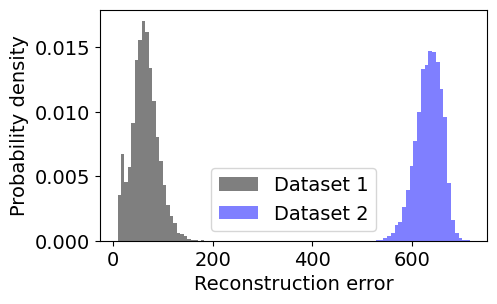

313/313 [==============================] - 0s 2ms/step


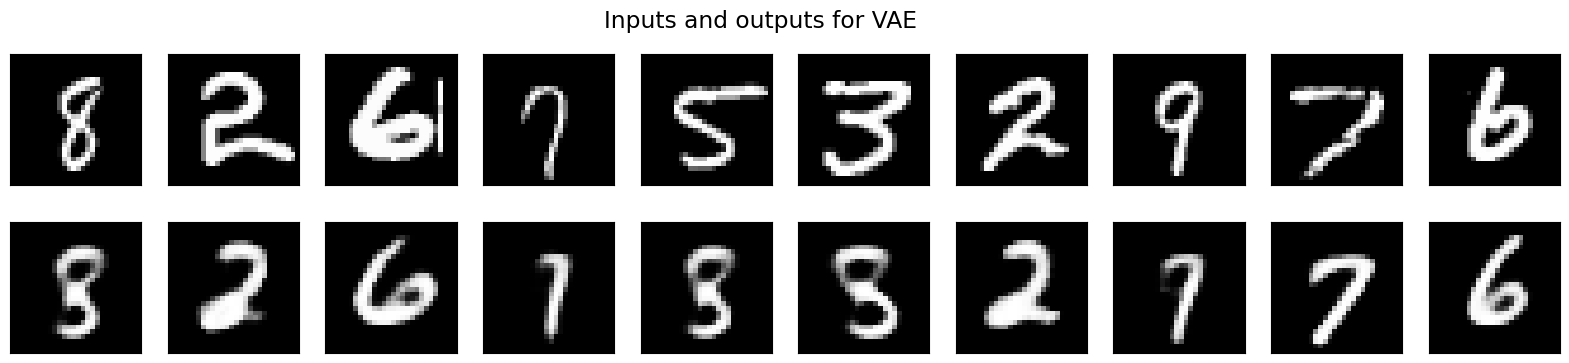

<Figure size 500x300 with 0 Axes>

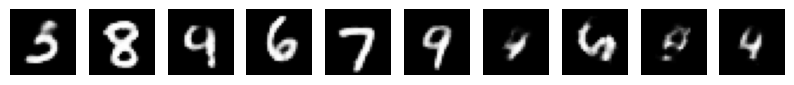

Show training samples:


<Figure size 500x300 with 0 Axes>

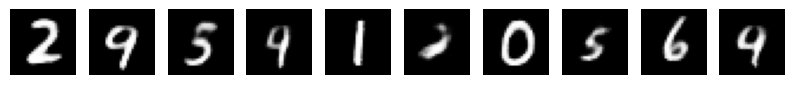

313/313 [==============================] - 1s 2ms/step


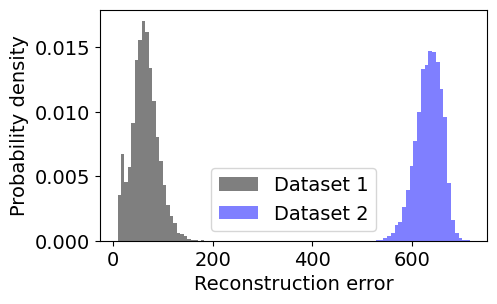

313/313 [==============================] - 1s 2ms/step


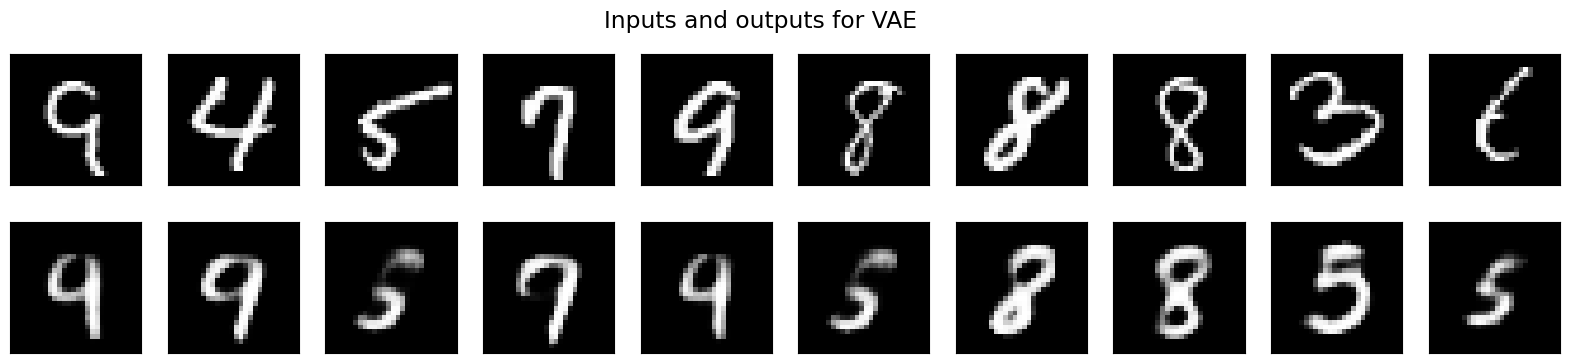

313/313 [==============================] - 1s 2ms/step


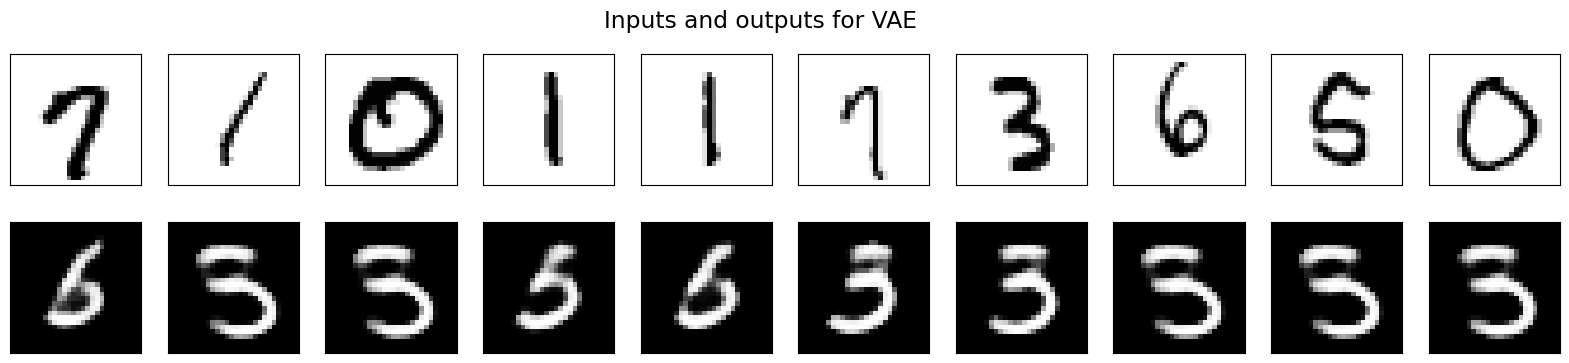

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


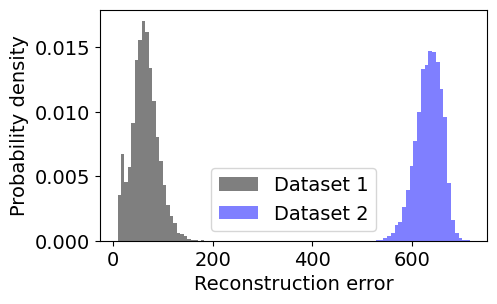

313/313 [==============================] - 1s 2ms/step


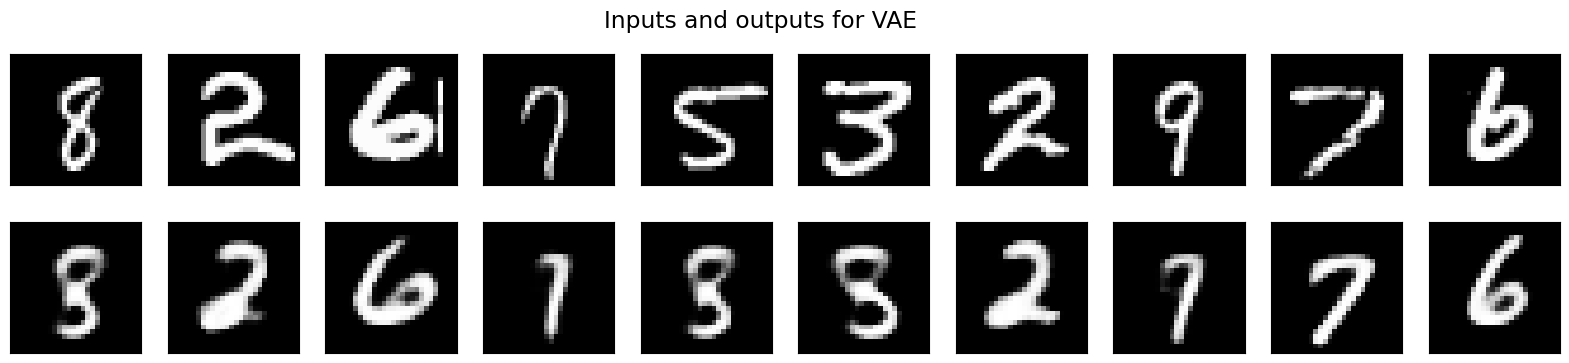

<Figure size 500x300 with 0 Axes>

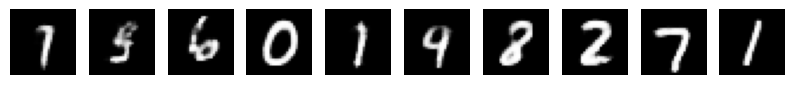

Show training samples:


<Figure size 500x300 with 0 Axes>

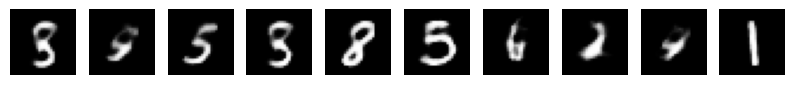

313/313 [==============================] - 1s 2ms/step


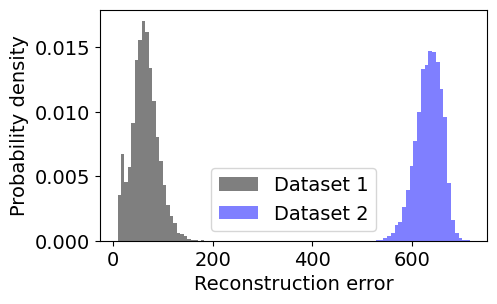

313/313 [==============================] - 1s 2ms/step


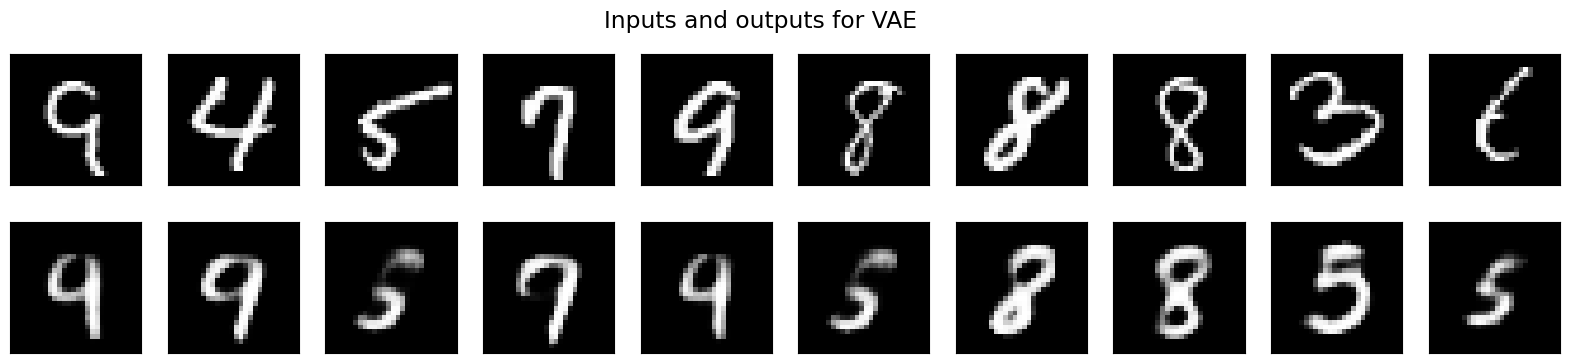

313/313 [==============================] - 1s 2ms/step


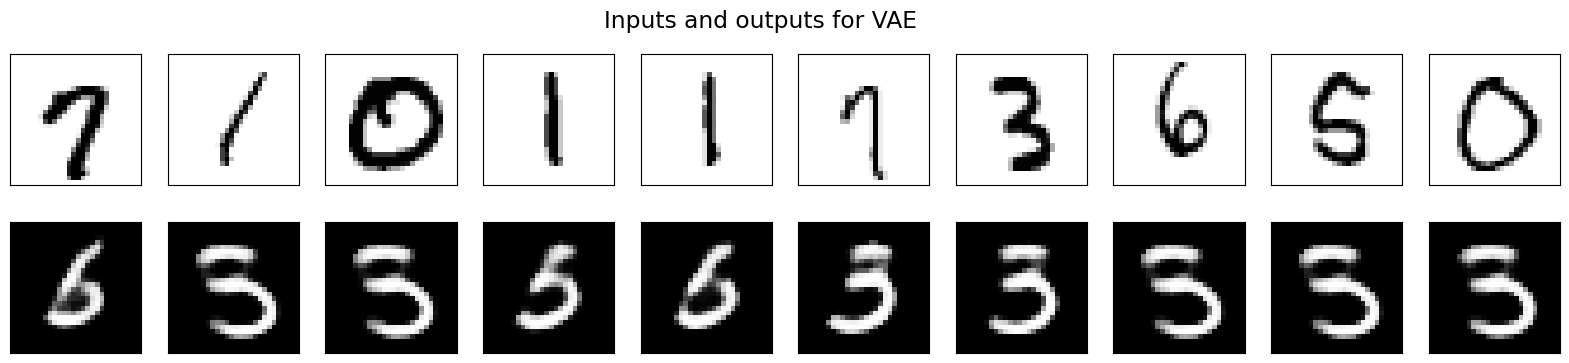

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


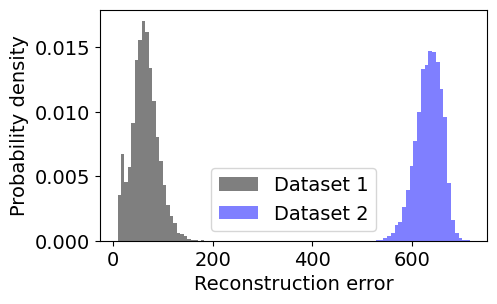

313/313 [==============================] - 1s 2ms/step


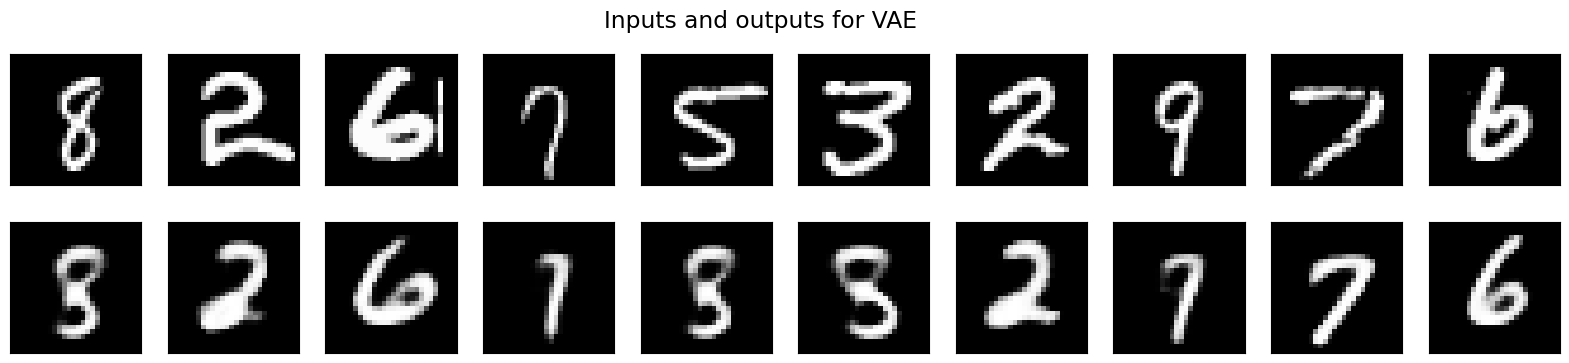

<Figure size 500x300 with 0 Axes>

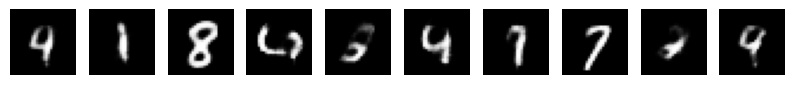

Show training samples:


<Figure size 500x300 with 0 Axes>

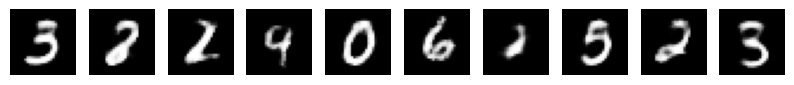

313/313 [==============================] - 1s 2ms/step


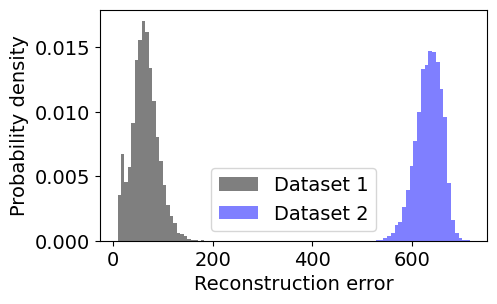

313/313 [==============================] - 1s 2ms/step


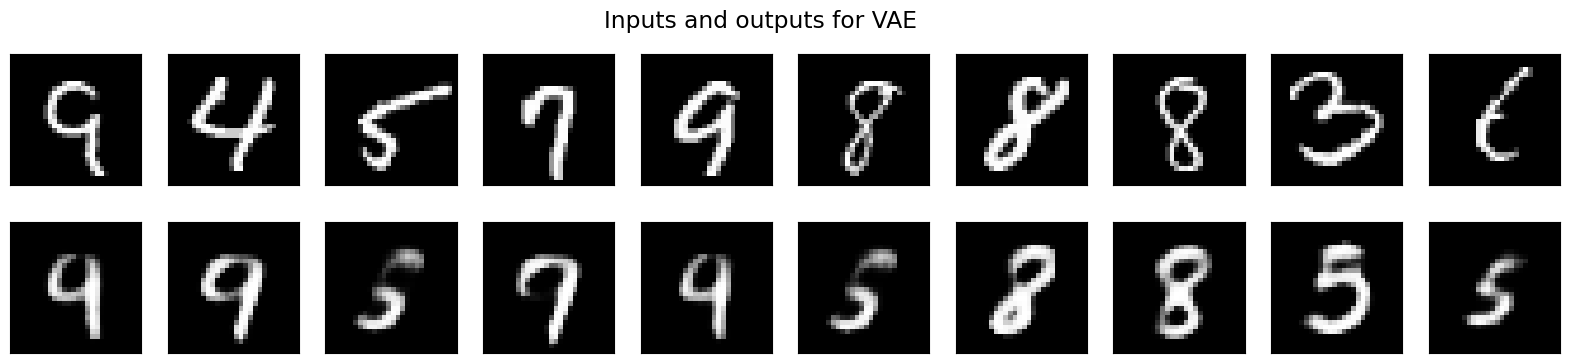

313/313 [==============================] - 1s 2ms/step


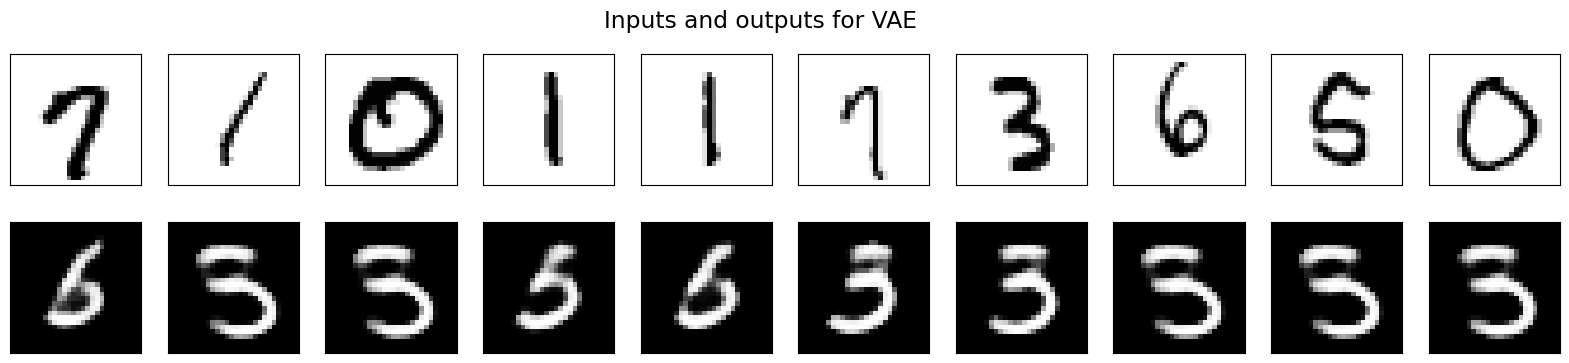

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


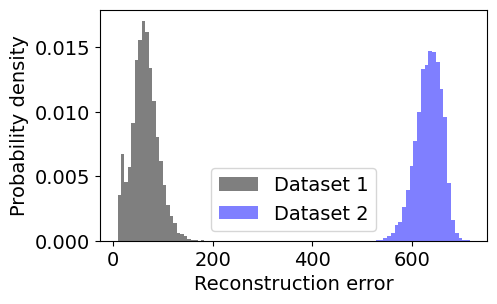

313/313 [==============================] - 1s 2ms/step


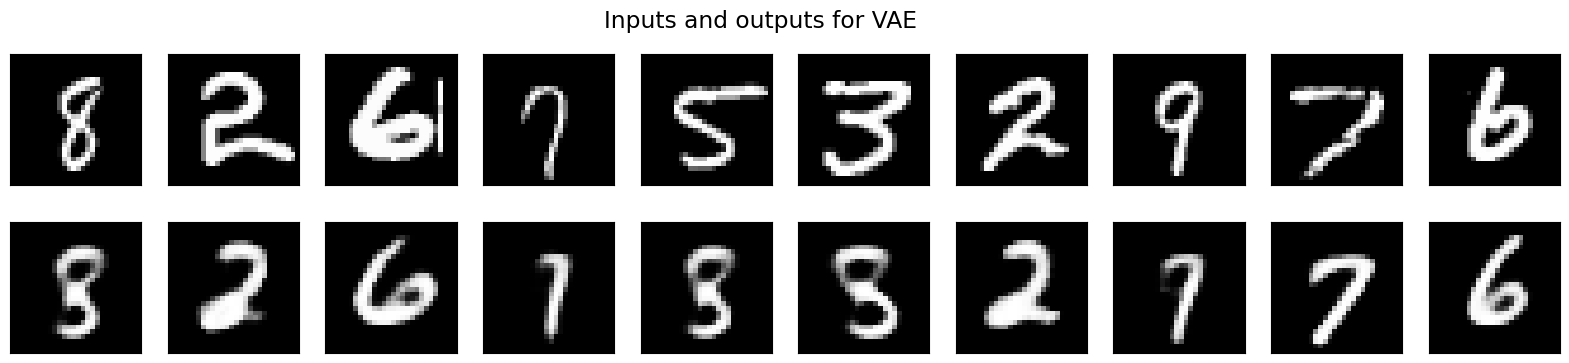

<Figure size 500x300 with 0 Axes>

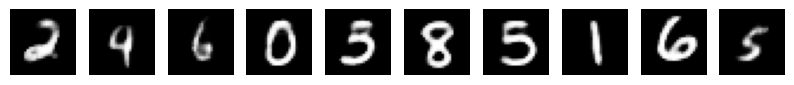

Show training samples:


<Figure size 500x300 with 0 Axes>

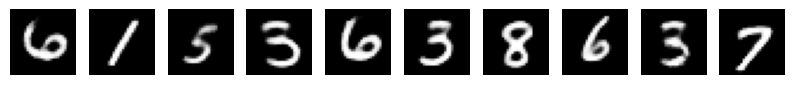

313/313 [==============================] - 1s 2ms/step


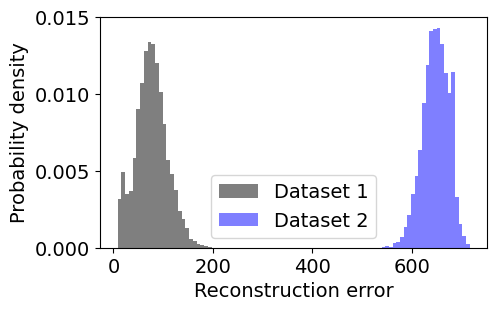

313/313 [==============================] - 1s 2ms/step


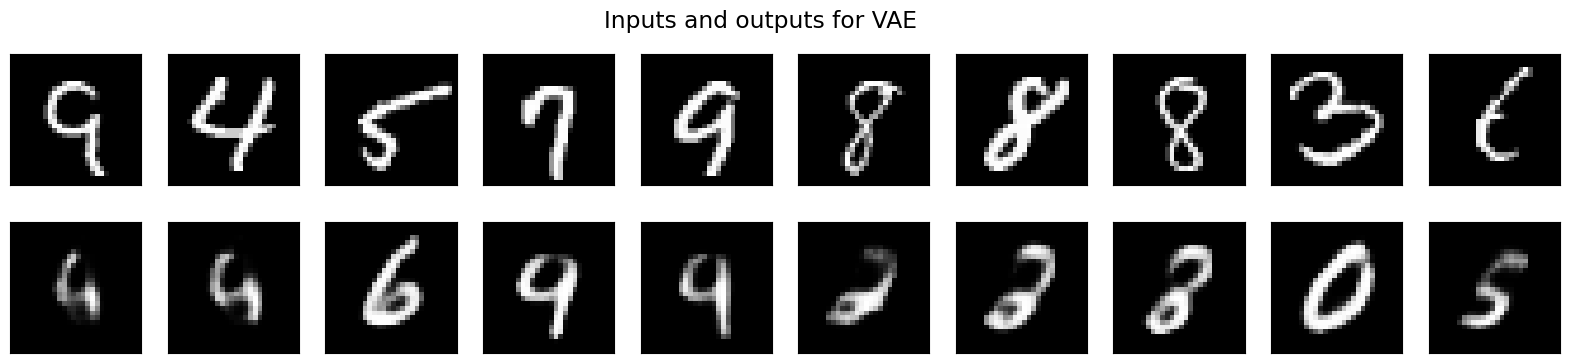

313/313 [==============================] - 1s 3ms/step


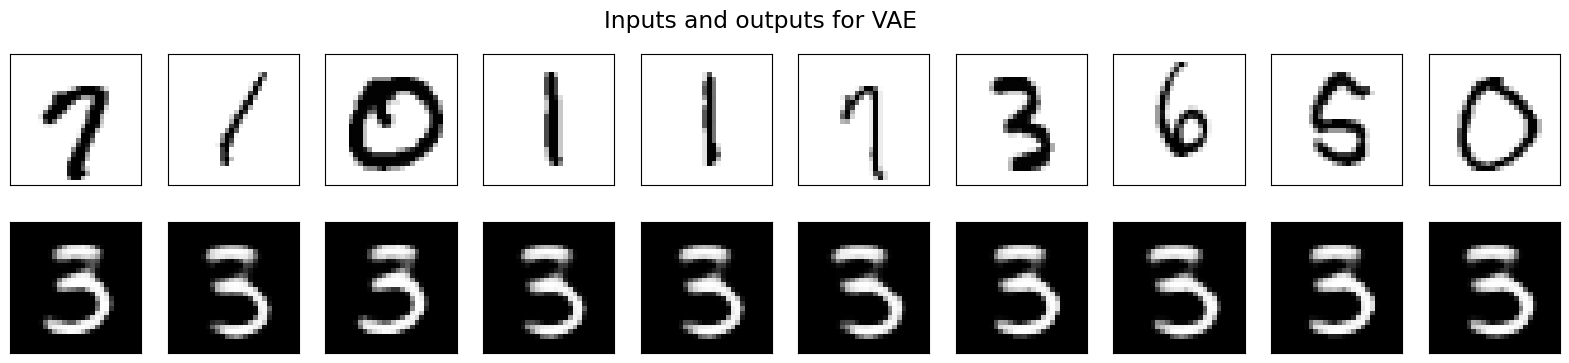

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


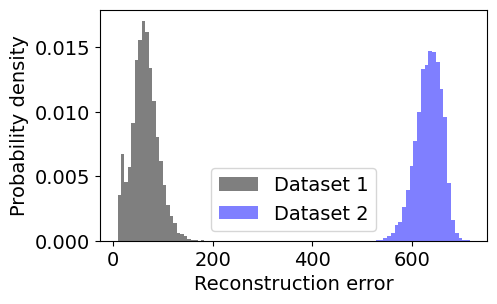

313/313 [==============================] - 1s 2ms/step


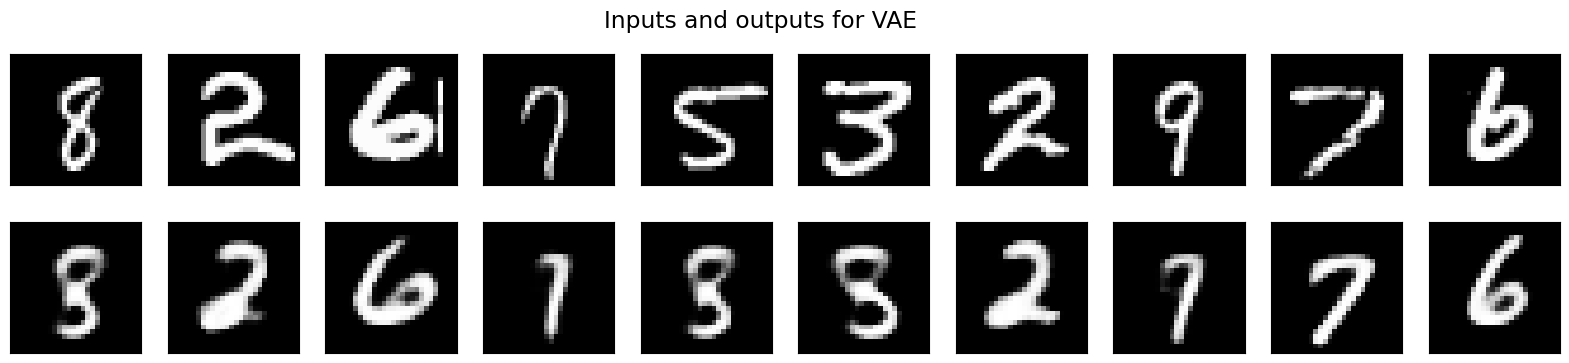

<Figure size 500x300 with 0 Axes>

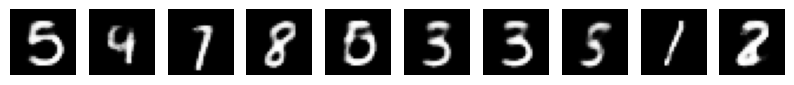

Show training samples:


<Figure size 500x300 with 0 Axes>

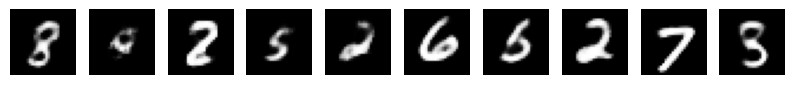

313/313 [==============================] - 1s 2ms/step


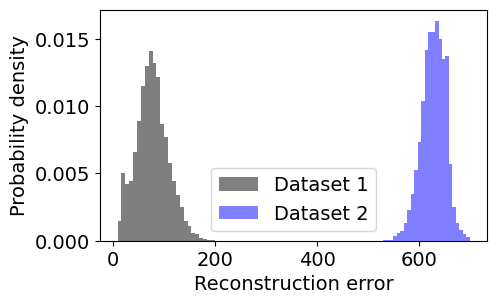

313/313 [==============================] - 1s 2ms/step


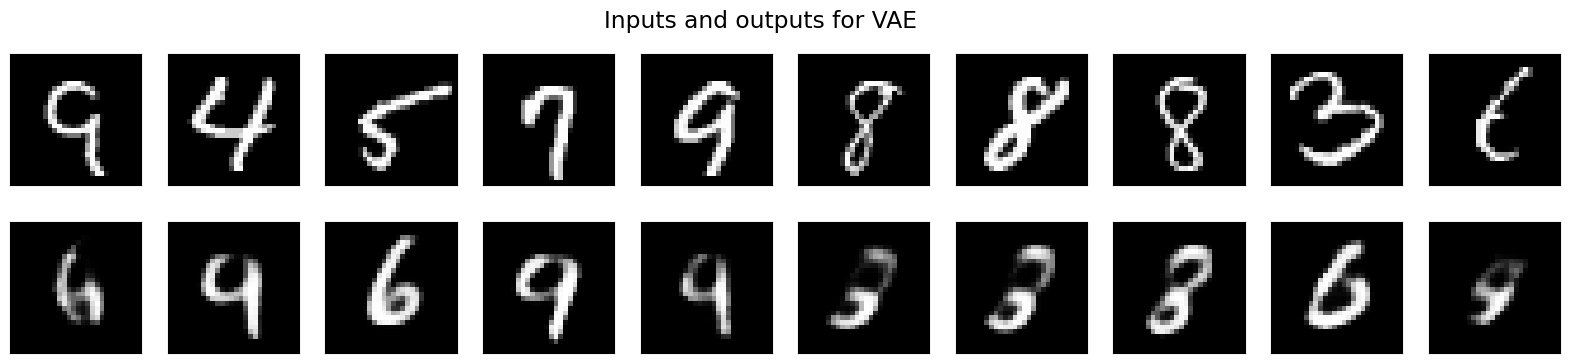

313/313 [==============================] - 1s 2ms/step


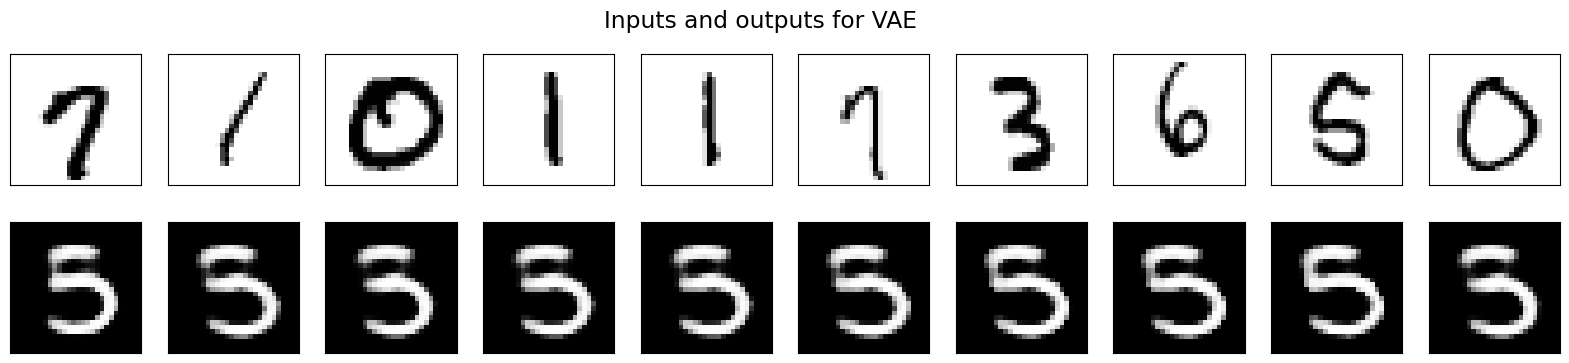

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


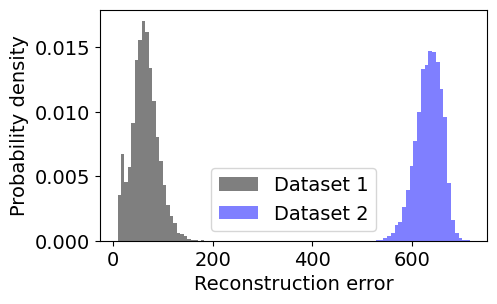

313/313 [==============================] - 1s 2ms/step


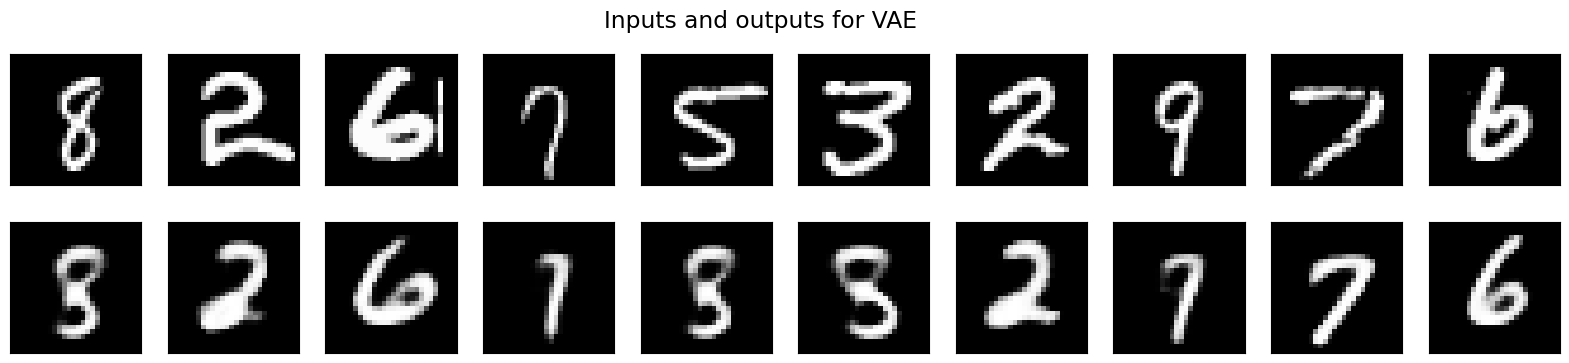

<Figure size 500x300 with 0 Axes>

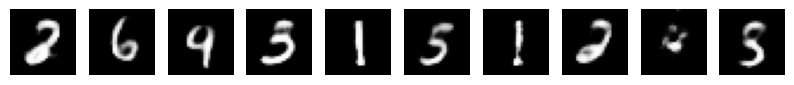

Show training samples:


<Figure size 500x300 with 0 Axes>

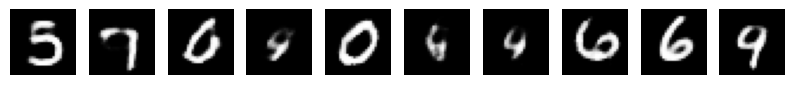

KeyboardInterrupt: 

In [ ]:
all_mnist_errors = {}
all_fmnist_errors = {}

#for num_sampled in [0,10,20,25,30,35,40,50,60]:
for num_epochs in [0,200,400,600,800,1000]:
    all_mnist_errors[num_epochs] = []
    all_fmnist_errors[num_epochs] = []
    for trial in range(3):
        mnist_errors, fmnist_errors = shuffled_baselines(baseline_type='old',
                                                         inverted=True)
        all_mnist_errors[num_epochs].append(mnist_errors)
        all_fmnist_errors[num_epochs].append(fmnist_errors)

In [ ]:
epoch_sizes = sorted(all_mnist_errors.keys())

mnist_means = [np.mean([x[1] for x in all_mnist_errors[s]]) for s in epoch_sizes]
mnist_sems = [np.std([x[1] for x in all_mnist_errors[s]]) / np.sqrt(len([x[1] for x in all_mnist_errors[s]])) for s in epoch_sizes]

fmnist_means = [np.mean([x[1] for x in all_fmnist_errors[s]]) for s in epoch_sizes]
fmnist_sems = [np.std([x[1] for x in all_fmnist_errors[s]]) / np.sqrt(len([x[1] for x in all_mnist_errors[s]])) for s in epoch_sizes]

plt.figure(figsize=(5, 3))
plt.plot(epoch_sizes, mnist_means, label='Dataset 1 (MNIST)', color='black', marker='o', alpha=0.5)
plt.plot(epoch_sizes, fmnist_means, label='Dataset 2 (Inverted MNIST)', color='blue', marker='o', alpha=0.5)

plt.xlabel('Number of epochs')
plt.ylabel('Mean reconstruction error')
#plt.xticks(range(0,60,10))
plt.xticks(range(0,1000,200))
#have to change above for each plot
plt.title('Mean reconstruction error according to the number of epochs, ratio_old=1 and ratio_new=0')
# have to change above for each plot
plt.legend()
plt.savefig('number_of_epochs.png', bbox_inches='tight')
plt.show()

In [ ]:
shuffled_baselines(baseline_type='both', use_initial_weights=False, latent_dim=10, inverted=True)
#this does not work

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/25
1875/1875 [==============================] - 94s 49ms/step - loss: 112.8517 - reconstruction_loss: 96.7971 - kl_loss: 1.4808
Epoch 2/25
1875/1875 [==============================] - 91s 49ms/step - loss: 70.9026 - reconstruction_loss: 60.5063 - kl_loss: 7.5004
Epoch 3/25
1875/1875 [==============================] - 100s 53ms/step - loss: 64.0306 - reconstruction_loss: 55.6242 - kl_loss: 7.9042
Epoch 4/25
1875/1875 [==============================] - 99s 53ms/step - loss: 62.3840 - reconstruction_loss: 53.9976 - kl_loss: 8.1318
Epoch 5/25
1875/1875 [==============================] - 99s 53ms/step - loss: 61.5264 - reconstruction_loss: 53.0451 - kl_loss: 8.2644
Epoch 6/25
1875/1875 [==============================] - 93s 50ms/step - loss: 60.8351 - reconstruction_loss: 52.3206 - kl_loss: 8.3532
Epoch 7/25
1875/1875 [==============================] - 90s 48ms/step - loss: 60.3002 - reconstruction_loss: 51.8732 - kl_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


ValueError: Cannot assign value to variable ' dense_4/kernel:0': Shape mismatch.The variable shape (16, 10), and the assigned value shape (16, 5) are incompatible.

In [ ]:
print(tf.debugging.disable_traceback_filtering())

None


11490434/11490434 [==============================] - 0s 0us/step
Starting with saved weights:
313/313 [==============================] - 5s 16ms/step


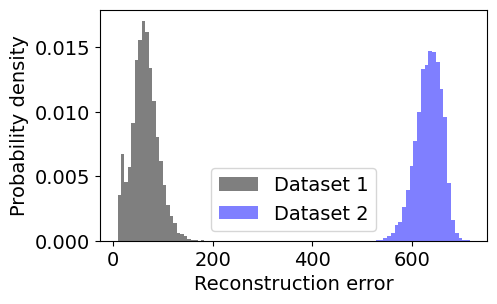

313/313 [==============================] - 6s 19ms/step


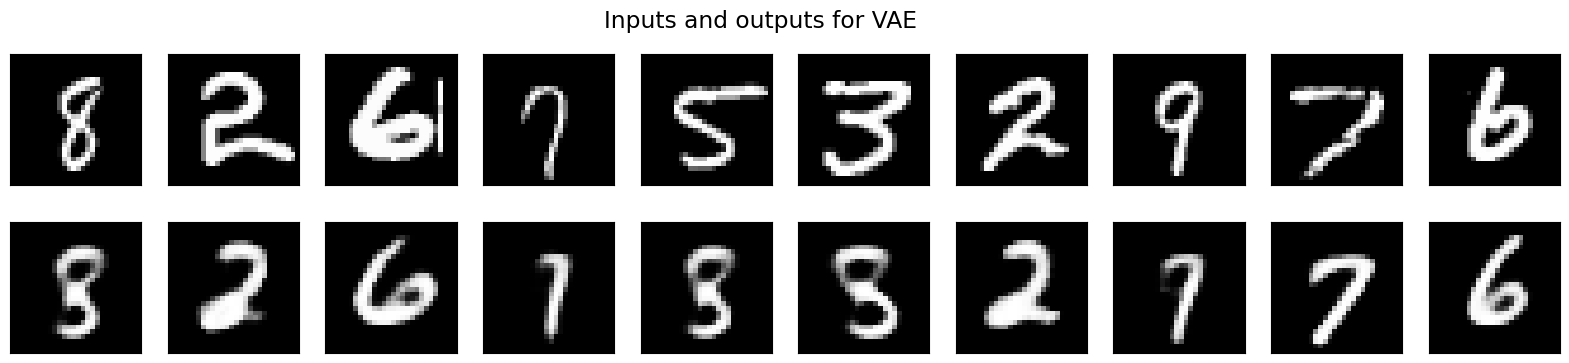

<Figure size 500x300 with 0 Axes>

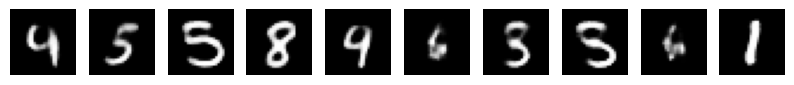

Show training samples:


<Figure size 500x300 with 0 Axes>

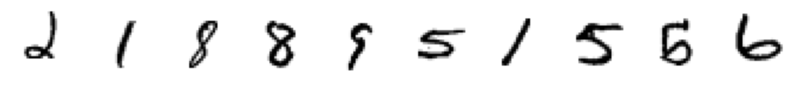

313/313 [==============================] - 4s 14ms/step


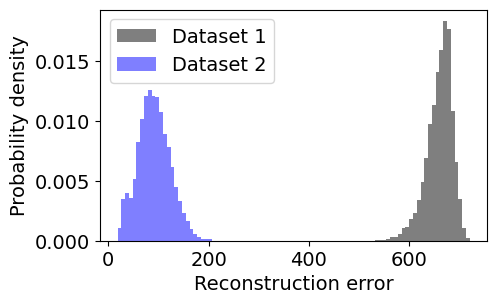

313/313 [==============================] - 4s 14ms/step


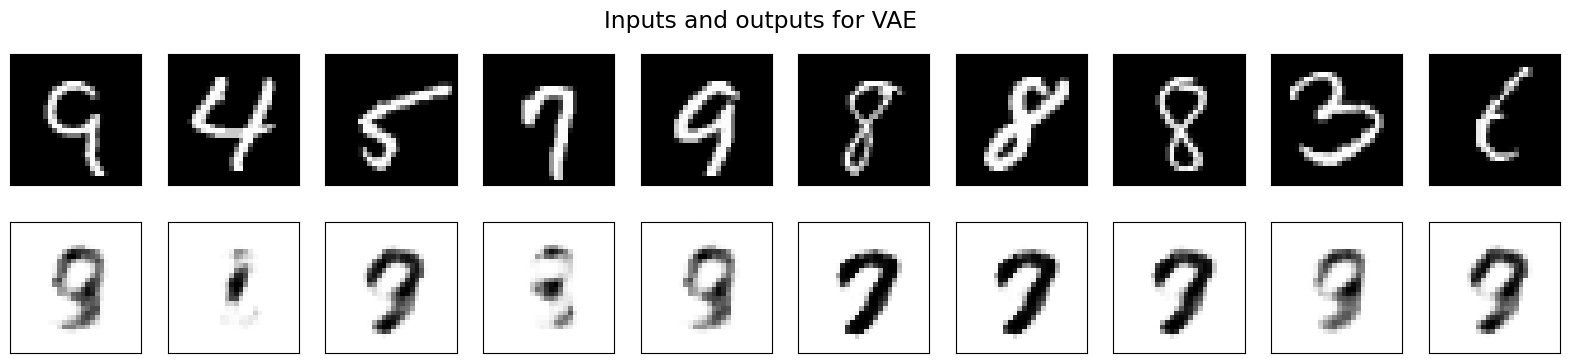

313/313 [==============================] - 5s 17ms/step


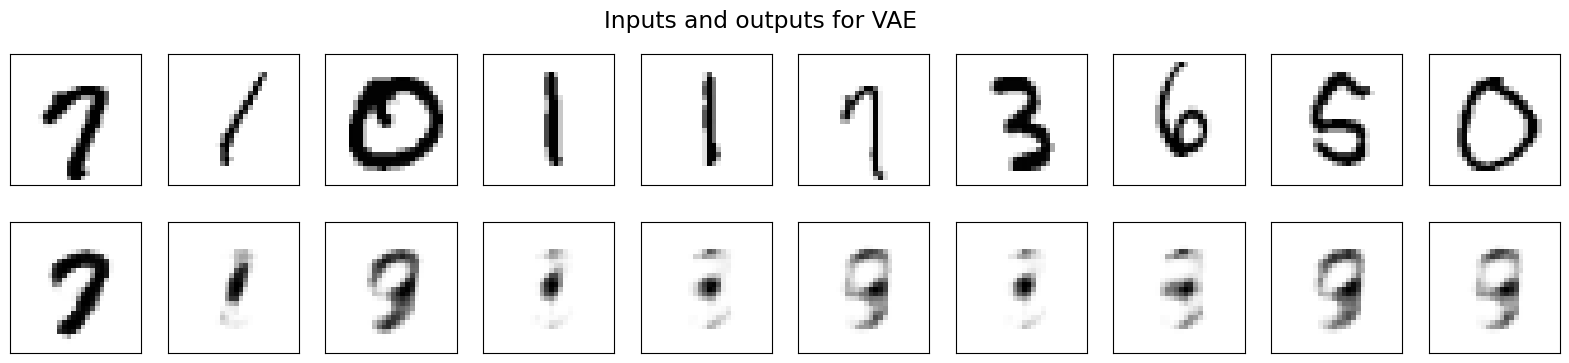

([63.9686407084465, 659.9254831848144], [633.9462630371094, 91.08414349365235])

In [ ]:
shuffled_baselines(baseline_type='new', inverted=True)

11490434/11490434 [==============================] - 0s 0us/step
Starting with saved weights:
313/313 [==============================] - 5s 17ms/step


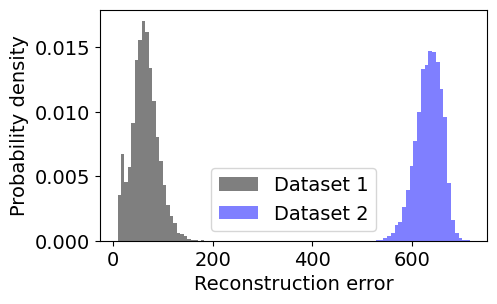

313/313 [==============================] - 4s 14ms/step


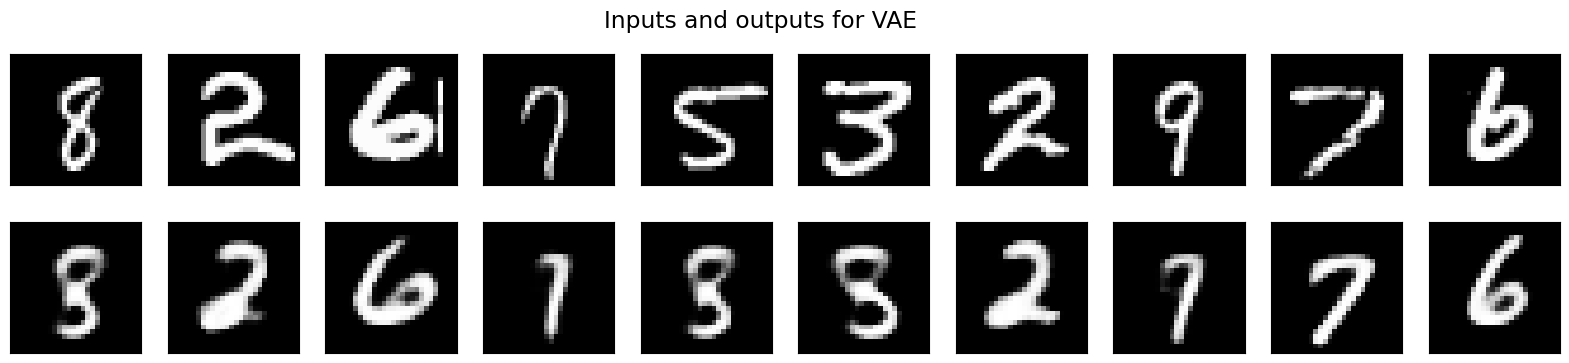

<Figure size 500x300 with 0 Axes>

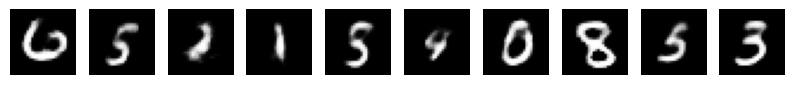

Show training samples:


<Figure size 500x300 with 0 Axes>

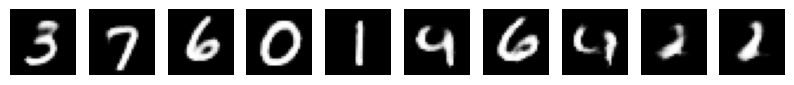

313/313 [==============================] - 5s 17ms/step


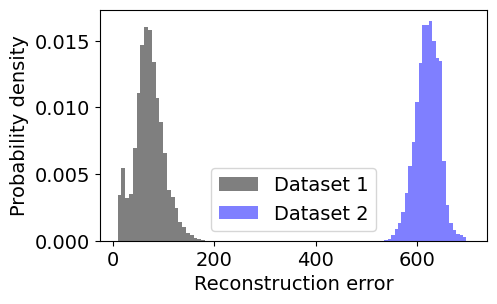

313/313 [==============================] - 5s 17ms/step


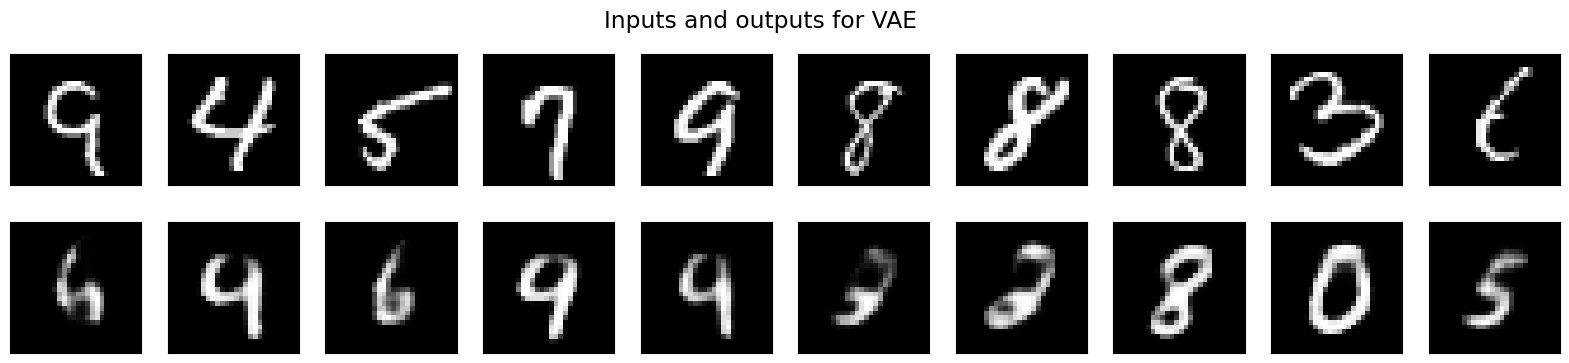

313/313 [==============================] - 5s 17ms/step


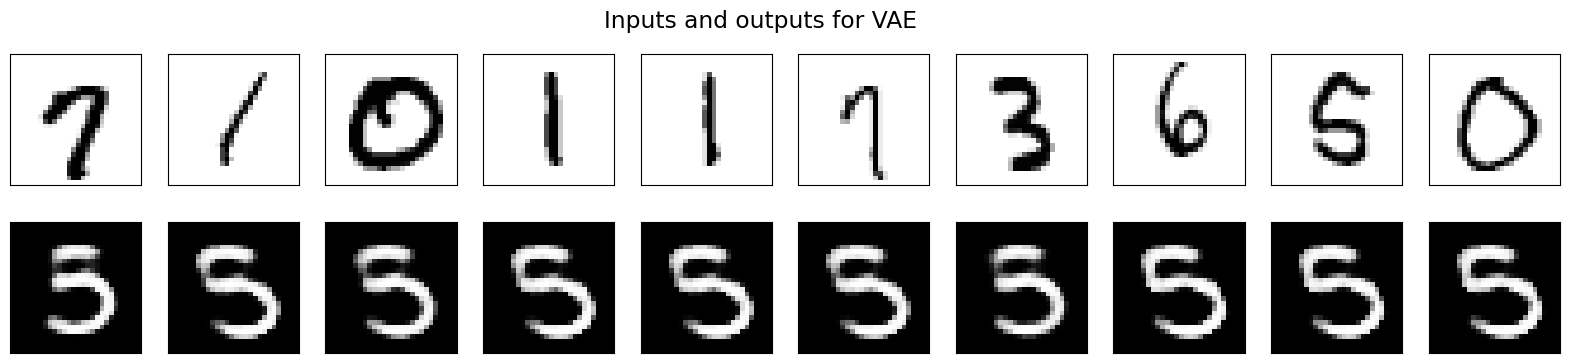

([63.9686407084465, 71.36228525266647], [633.9462630371094, 621.2521473999024])

In [ ]:
shuffled_baselines(baseline_type='old', inverted=True)

Starting with saved weights:
313/313 [==============================] - 4s 14ms/step


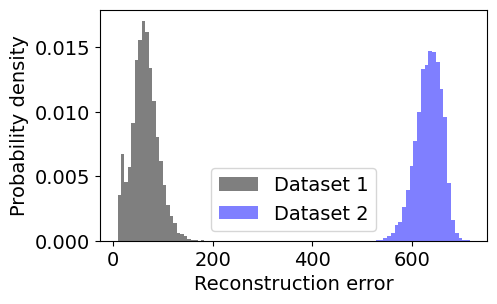

313/313 [==============================] - 4s 12ms/step


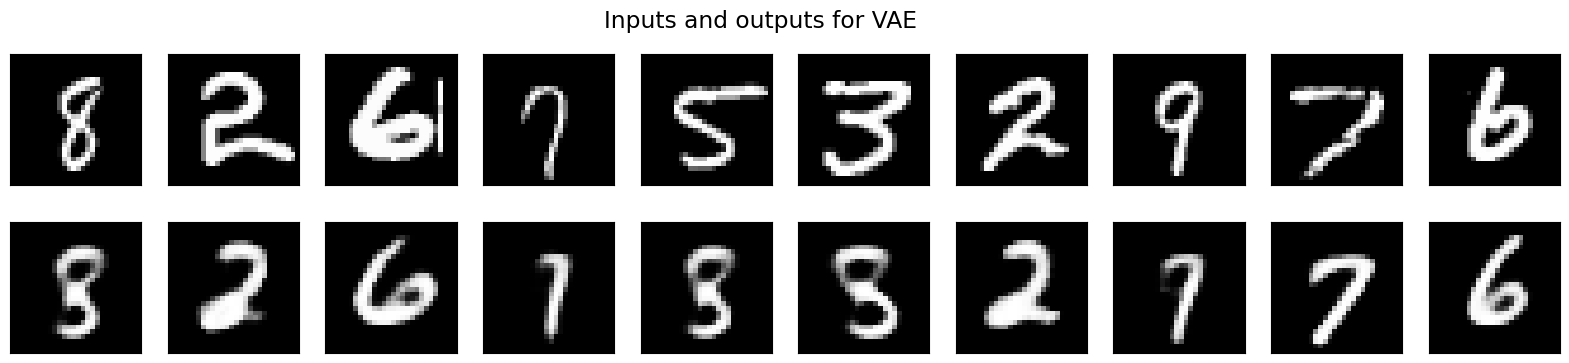

<Figure size 500x300 with 0 Axes>

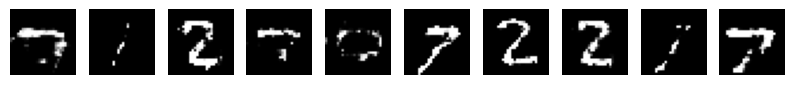

Show training samples:


<Figure size 500x300 with 0 Axes>

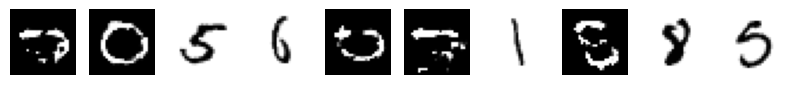

313/313 [==============================] - 4s 14ms/step


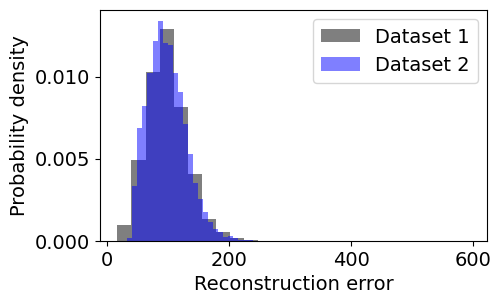

313/313 [==============================] - 4s 13ms/step


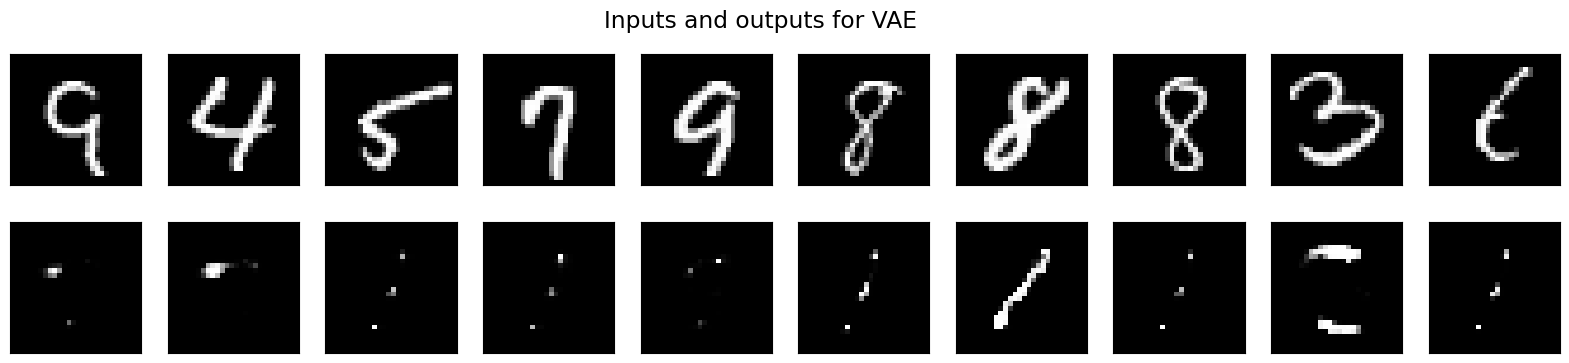

313/313 [==============================] - 4s 13ms/step


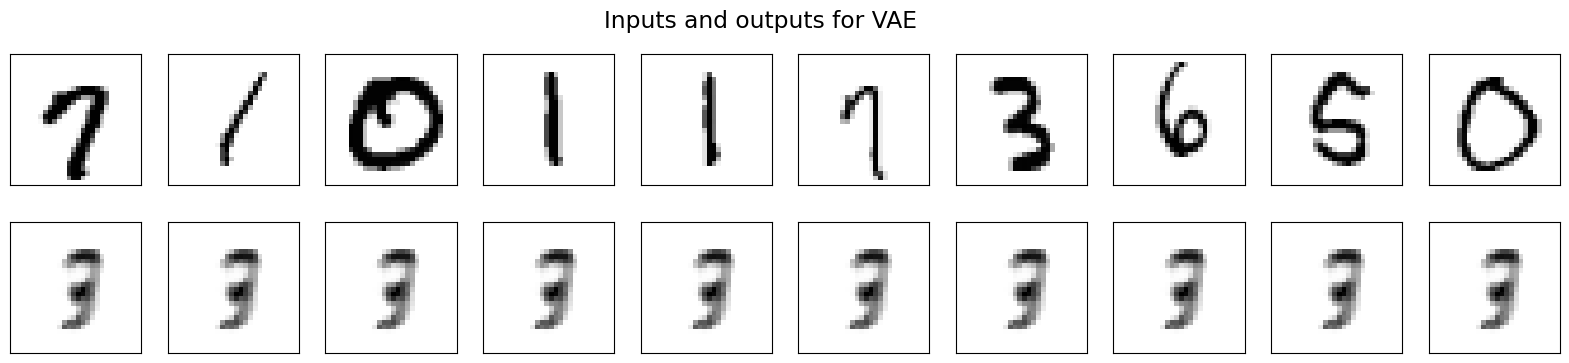

([63.9686407084465, 98.66882679958343], [633.9462630371094, 98.82895973052979])

In [ ]:
shuffled_baselines(baseline_type='both', inverted=True, num_epochs=20)

In [ ]:
def shuffled_baselines_with_ratio(baseline_type='both',
                       num_epochs=10,
                       ratio_old=0.5,
                       ratio_new=0.5,
                       use_initial_weights=True,
                       latent_dim=5,
                       seed=0,
                       inverted=True,
                       lr=0.001,
                       num=1000,
                       continue_training=True):

    np.random.seed(seed)

    if baseline_type == 'new':
        #train_data = fmnist_subset
        raise ValueError('baseline type can only be both')
    if baseline_type == 'old':
        #train_data = np.array(sampled_digits)
        raise ValueError('baseline type can only be both')
    if ((ratio_old+ratio_new) != 1):
      raise ValueError('incorrect ratio')

    if inverted is True:
        mnist_train, mnist_test, fmnist_train, fmnist_test = prepare_datasets(split_by_digits=False,
                                                                              split_by_inversion=True)
    else:
        mnist_train, mnist_test, fmnist_train, fmnist_test = prepare_datasets(split_by_digits=True,
                                                                              split_by_inversion=False)

    if use_initial_weights is False:
        vae = train_mnist_vae(mnist_train, 'mnist', generative_epochs=25, learning_rate=0.001, latent_dim=latent_dim)
    else:
        print("Starting with saved weights:")

    encoder, decoder = models_dict['mnist'](latent_dim=latent_dim)
    vae = VAE(encoder, decoder, kl_weighting=1)
    if inverted is True:
        vae.encoder.load_weights("encoder_inv.h5")
        vae.decoder.load_weights("decoder_inv.h5")
    if inverted is False:
        vae.encoder.load_weights("encoder_non_inv.h5")
        vae.decoder.load_weights("decoder_non_inv.h5")
    opt = keras.optimizers.Adam(learning_rate=lr, jit_compile=False)
    vae.compile(optimizer=opt)

    m_err, f_err = plot_error_dists(vae, mnist_test, fmnist_test)
    check_generative_recall(vae, mnist_test, noise_level=0.0)

    sampled_digits = [sample_item(vae, latent_dim=latent_dim) for i in range(100)]
    sampled_digits = np.array(sampled_digits)
    show_samples(sampled_digits)

    mnist_errors = []
    fmnist_errors = []

    mnist_errors.append(np.mean(m_err))
    fmnist_errors.append(np.mean(f_err))

    random_indices = np.random.choice(fmnist_train.shape[0], int(num*ratio_new), replace=False)
    #changing number of new data (dataset 2) sampling from according to ratio_new
    fmnist_subset = fmnist_train[random_indices]
    sampled_digits = [sample_item(vae, latent_dim=latent_dim) for i in range(int(num*ratio_old))]
    #changing number of old data (dataset 1) sampling from according to ratio_old

    if baseline_type == 'both':
        train_data = sampled_digits + list(fmnist_subset)
        shuffle(train_data)
        train_data = np.array(train_data[0:num])

    print("Show training samples:")
    show_samples(train_data)

    #vae.fit(train_data, epochs=10, verbose=0, batch_size=1, shuffle=True)
    vae.fit(train_data, epochs=num_epochs, verbose=0, batch_size=1, shuffle=True)

    # test reconstruction error of mnist_test and fmnist_test
    m_err, f_err = plot_error_dists(vae, mnist_test, fmnist_test)
    mnist_errors.append(np.mean(m_err))
    fmnist_errors.append(np.mean(f_err))

    check_generative_recall(vae, mnist_test, noise_level=0.0)
    check_generative_recall(vae, fmnist_test, noise_level=0.0)

    return mnist_errors, fmnist_errors


     #shuffle(sampled_digits)
        #shuffle(fmnist_subset)
        #ratio_sampled_digits=len(sampled_digits)*ratio_old
        #ratio_fmnist_subset=fmnist_subset.shape*ratio_new
        #sampled_digits=np.array(sampled_digits[0:ratio_sampled_digits])
        #fmnist_subset=np.array(fmnist_subset[0:fmnist_subset])

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


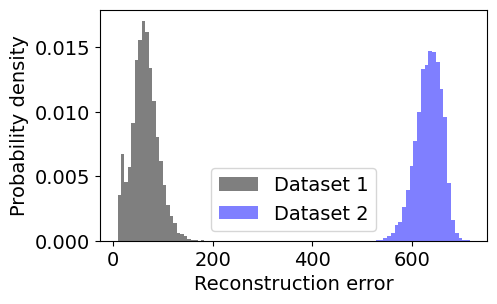

313/313 [==============================] - 1s 2ms/step


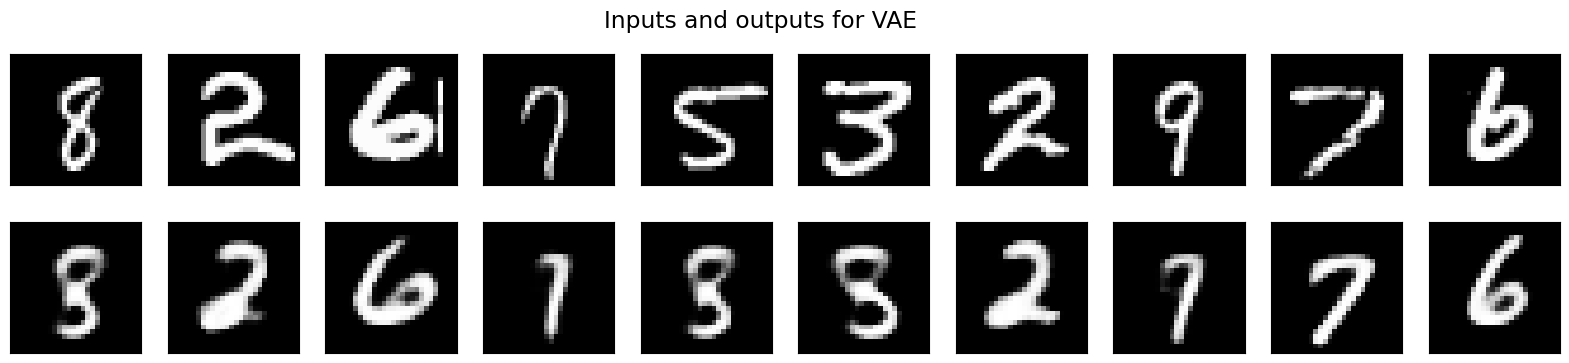

<Figure size 500x300 with 0 Axes>

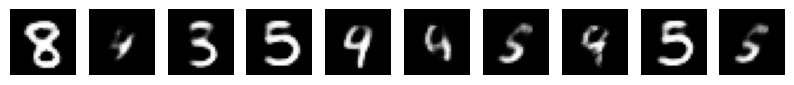

Show training samples:


<Figure size 500x300 with 0 Axes>

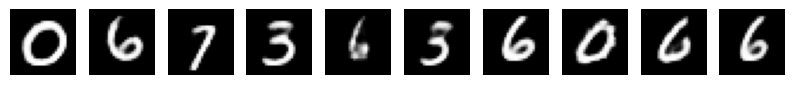

313/313 [==============================] - 1s 2ms/step


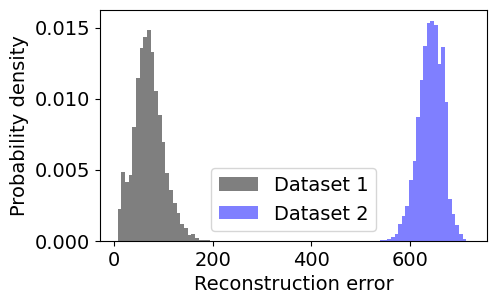

313/313 [==============================] - 1s 2ms/step


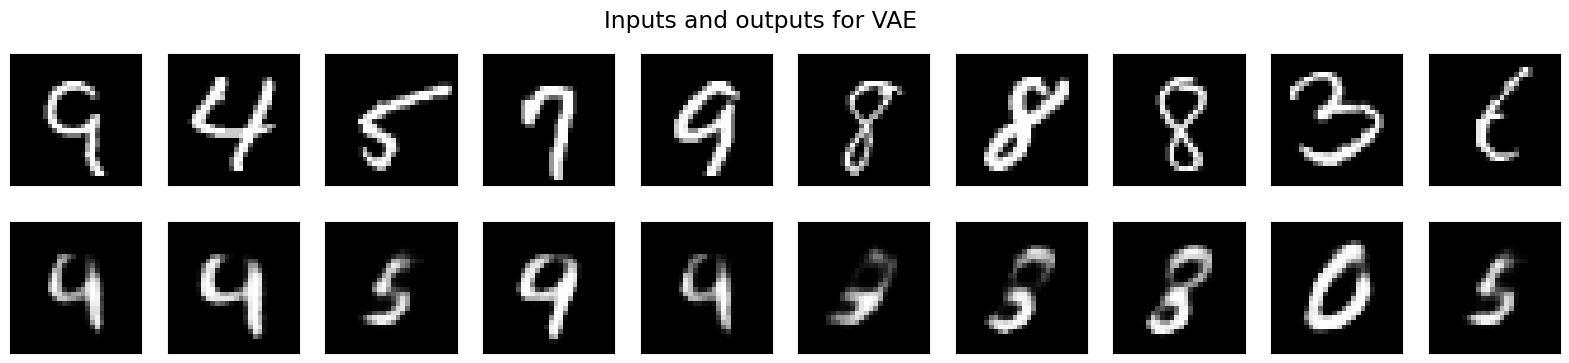

313/313 [==============================] - 1s 2ms/step


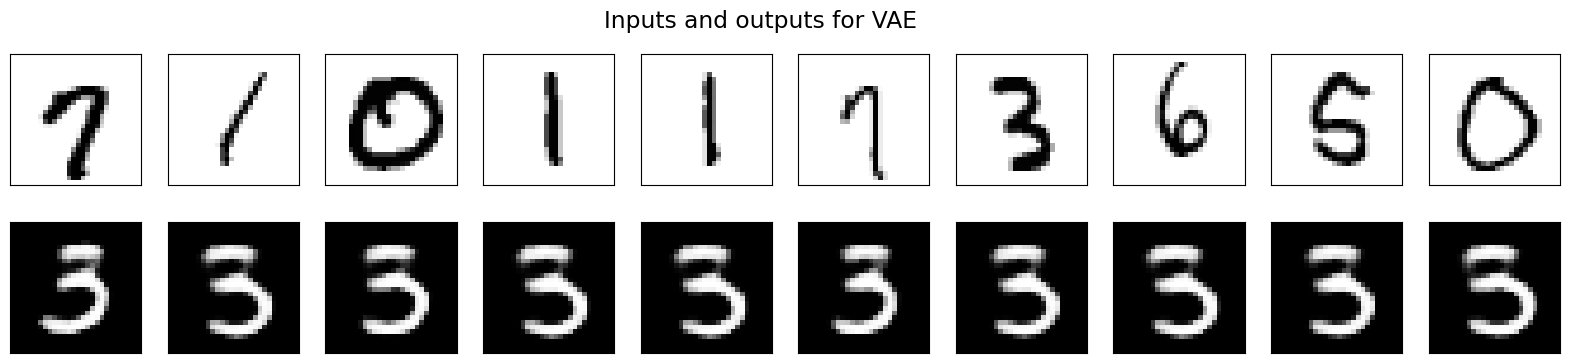

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


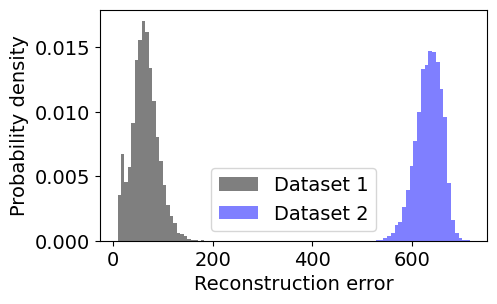

313/313 [==============================] - 1s 2ms/step


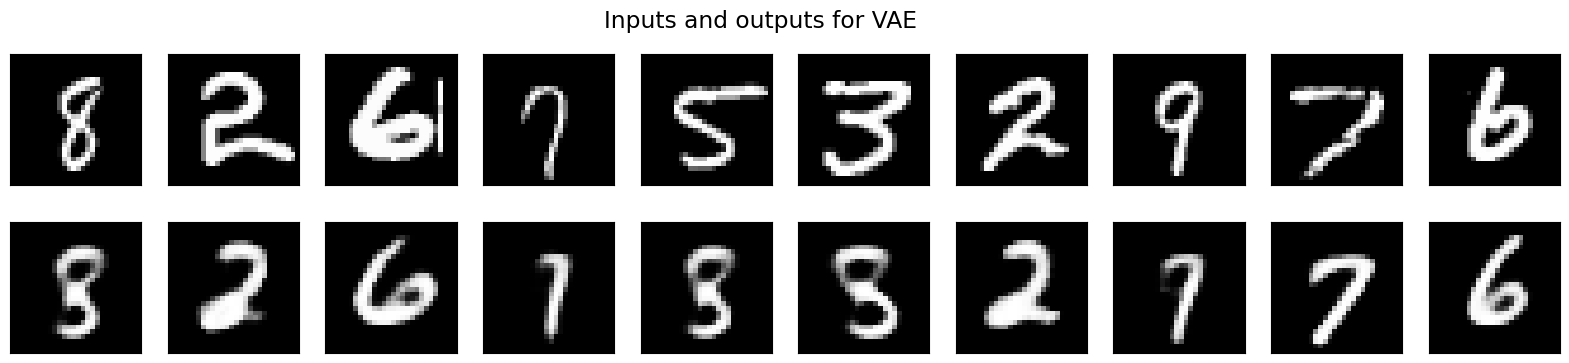

<Figure size 500x300 with 0 Axes>

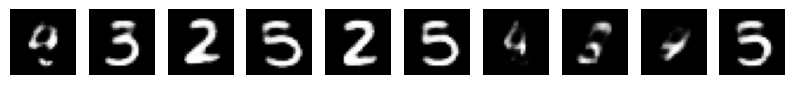

Show training samples:


<Figure size 500x300 with 0 Axes>

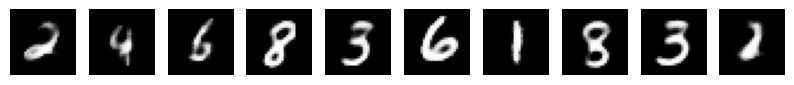

313/313 [==============================] - 1s 2ms/step


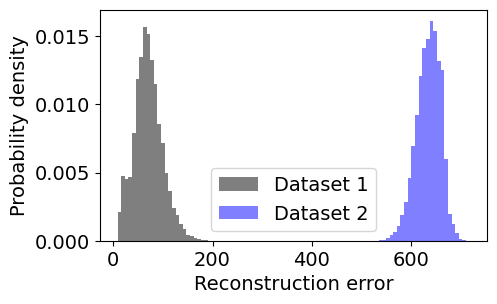

313/313 [==============================] - 1s 2ms/step


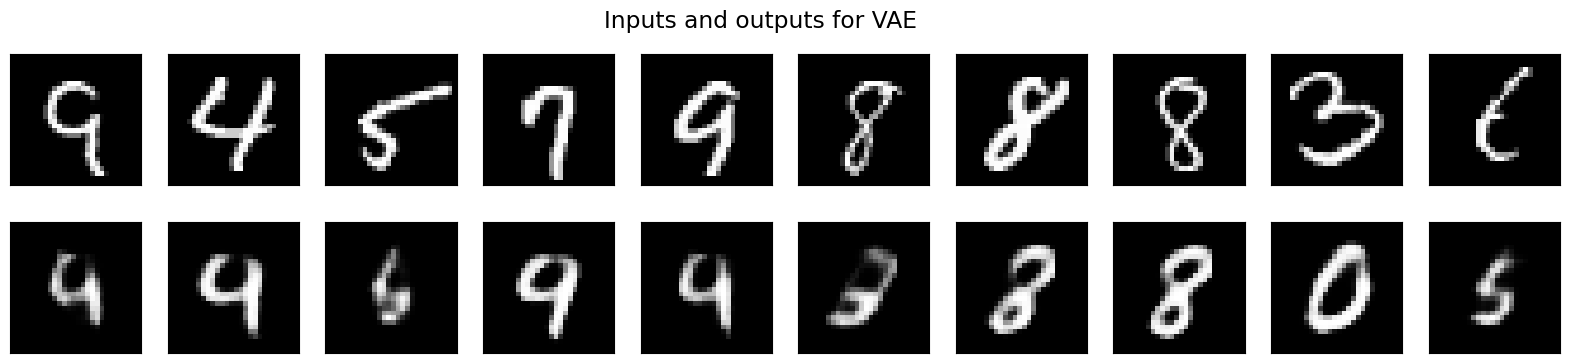

313/313 [==============================] - 1s 2ms/step


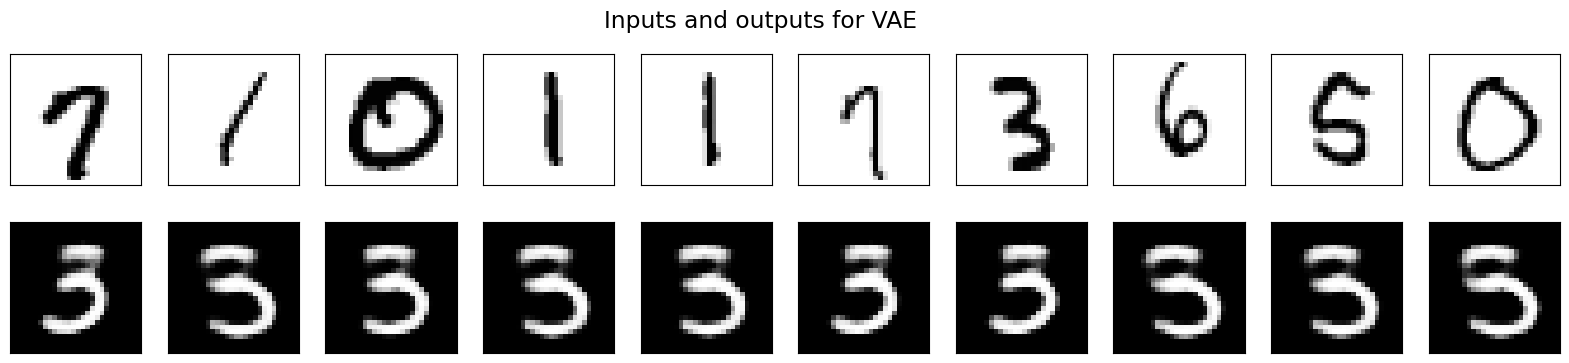

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


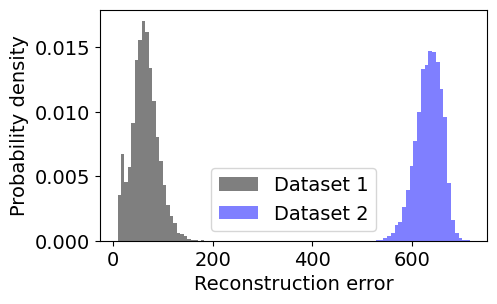

313/313 [==============================] - 1s 2ms/step


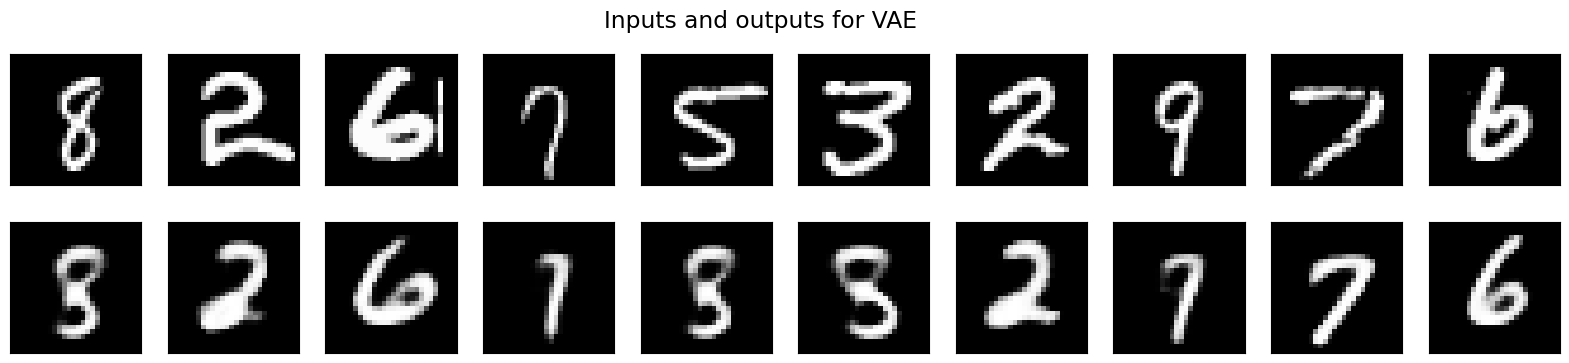

<Figure size 500x300 with 0 Axes>

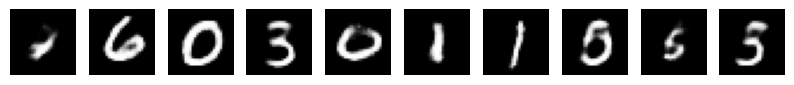

Show training samples:


<Figure size 500x300 with 0 Axes>

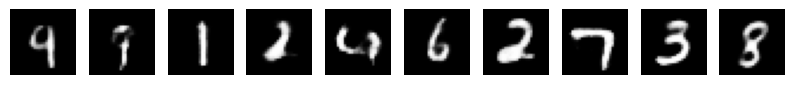

313/313 [==============================] - 1s 2ms/step


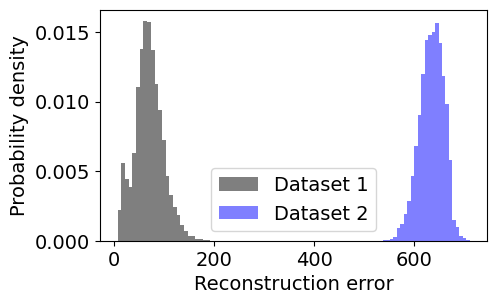

313/313 [==============================] - 1s 2ms/step


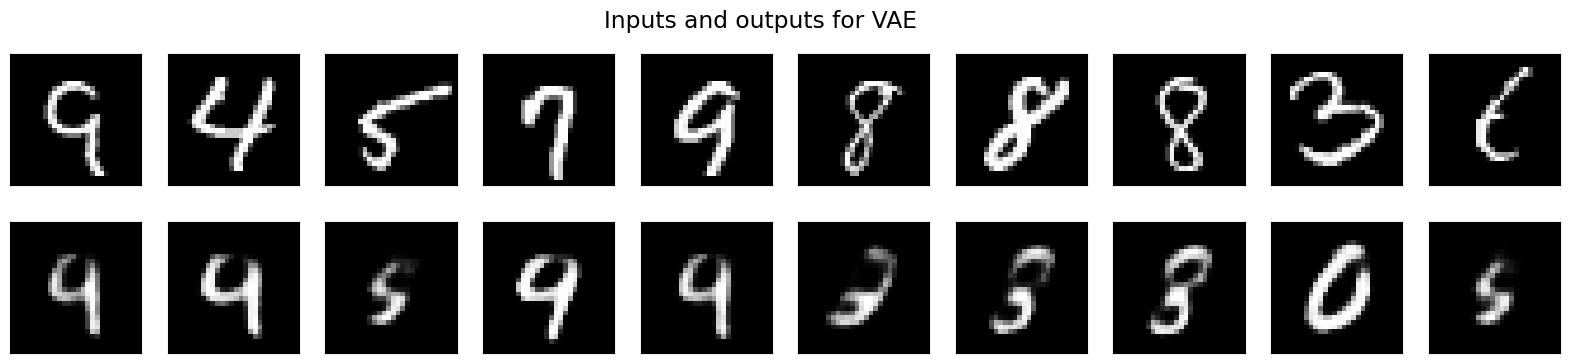

313/313 [==============================] - 1s 2ms/step


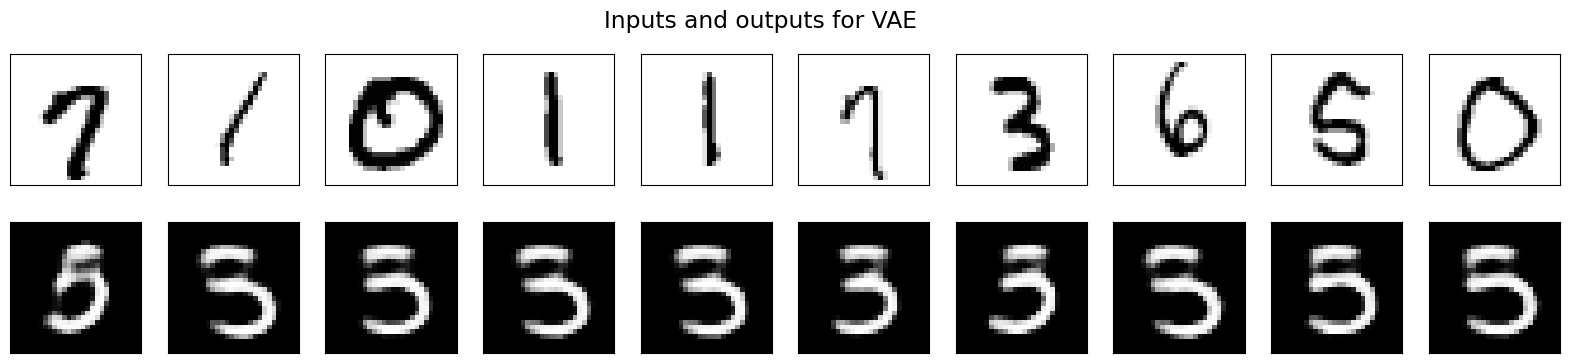

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


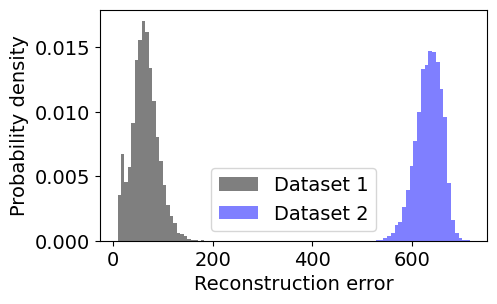

313/313 [==============================] - 1s 2ms/step


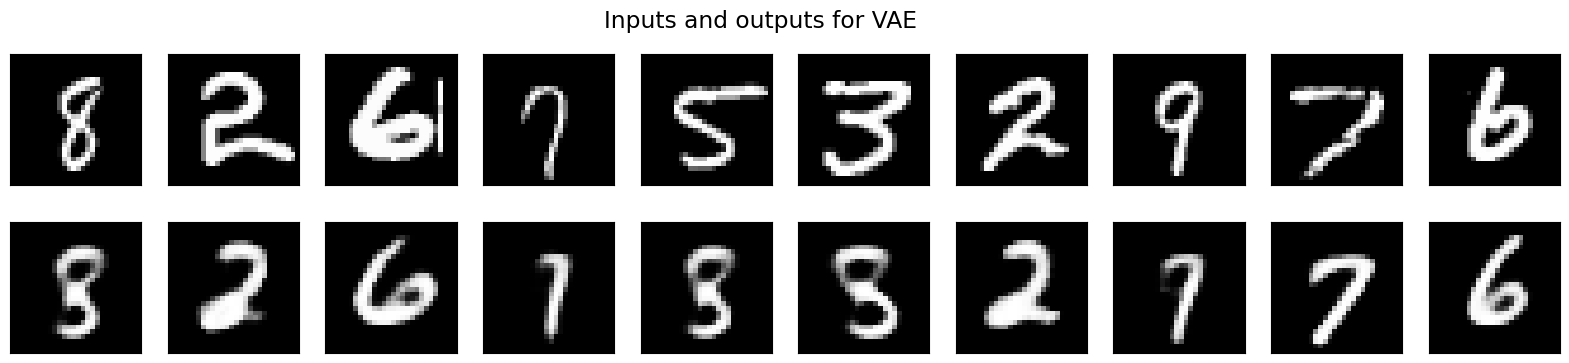

<Figure size 500x300 with 0 Axes>

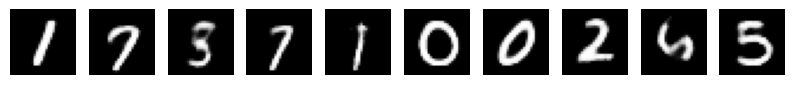

Show training samples:


<Figure size 500x300 with 0 Axes>

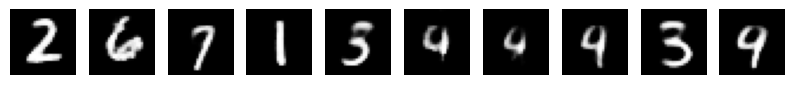

313/313 [==============================] - 1s 2ms/step


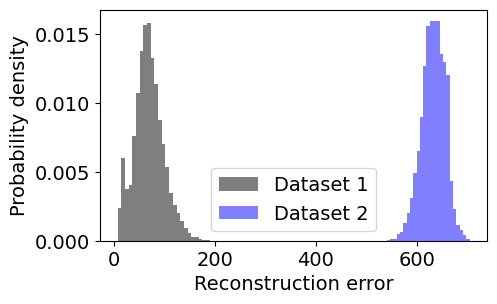

313/313 [==============================] - 1s 2ms/step


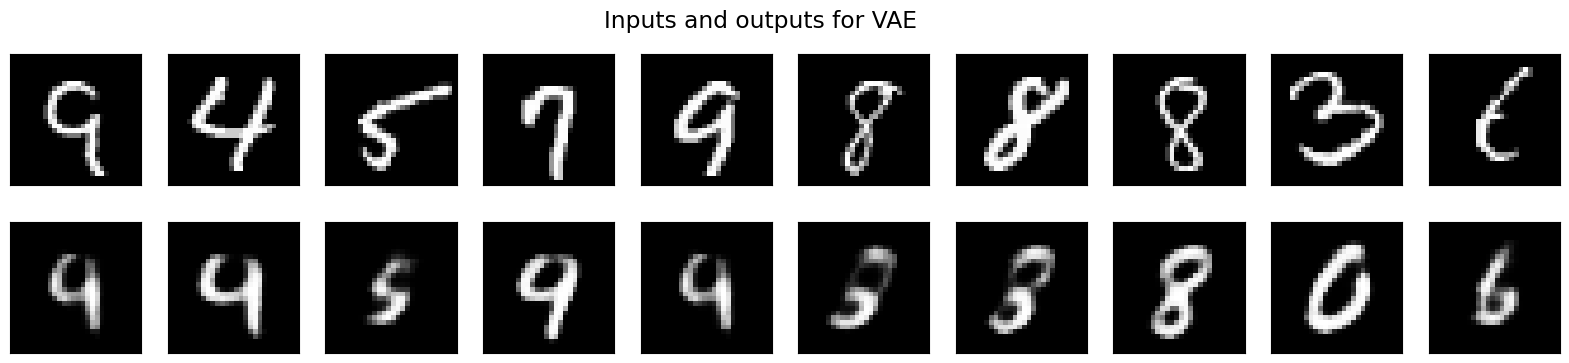

313/313 [==============================] - 1s 2ms/step


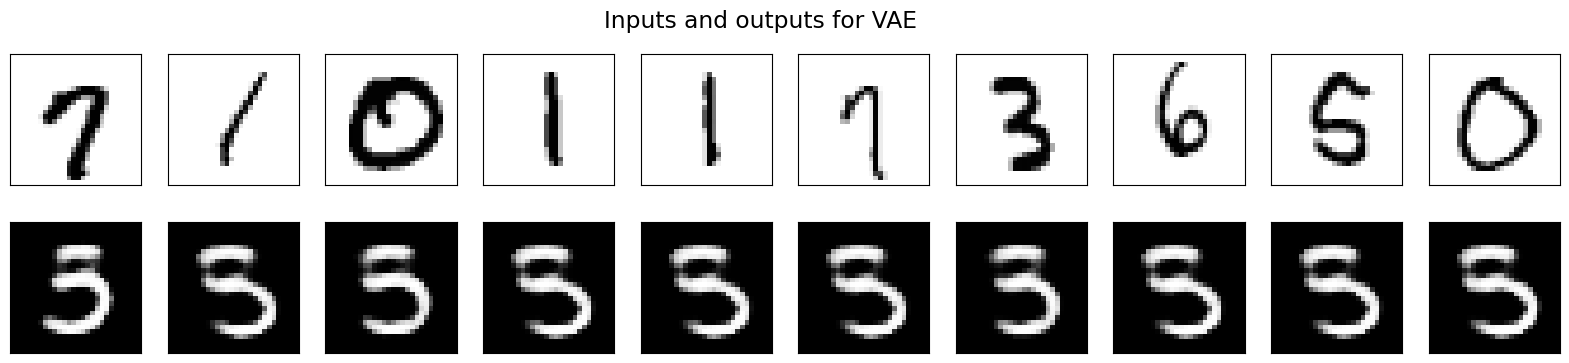

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


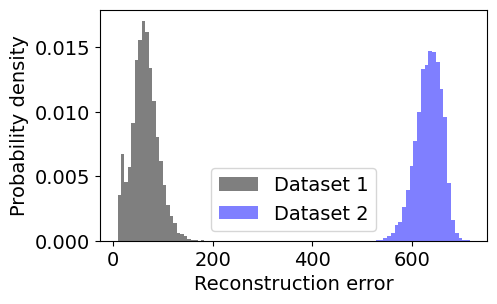

313/313 [==============================] - 1s 2ms/step


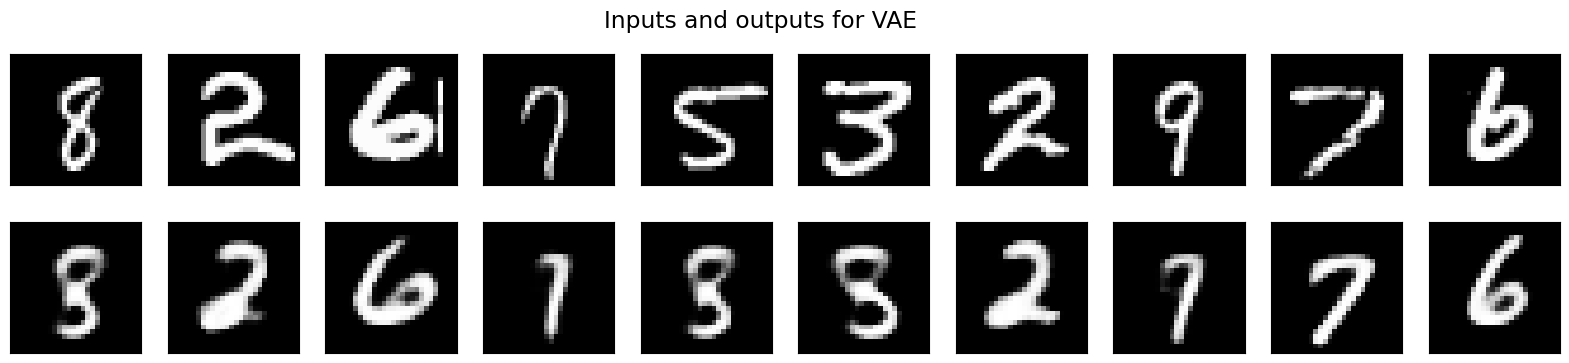

<Figure size 500x300 with 0 Axes>

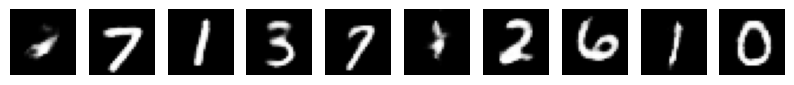

Show training samples:


<Figure size 500x300 with 0 Axes>

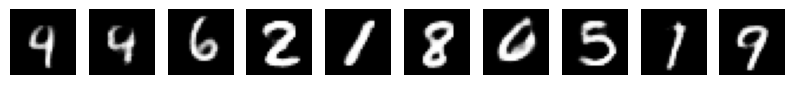

313/313 [==============================] - 1s 2ms/step


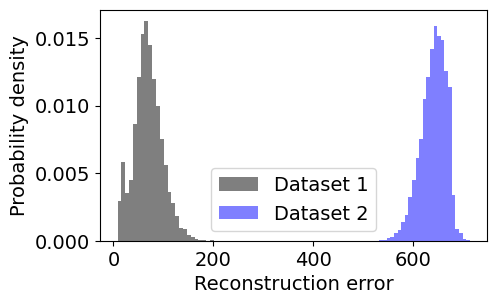

313/313 [==============================] - 1s 2ms/step


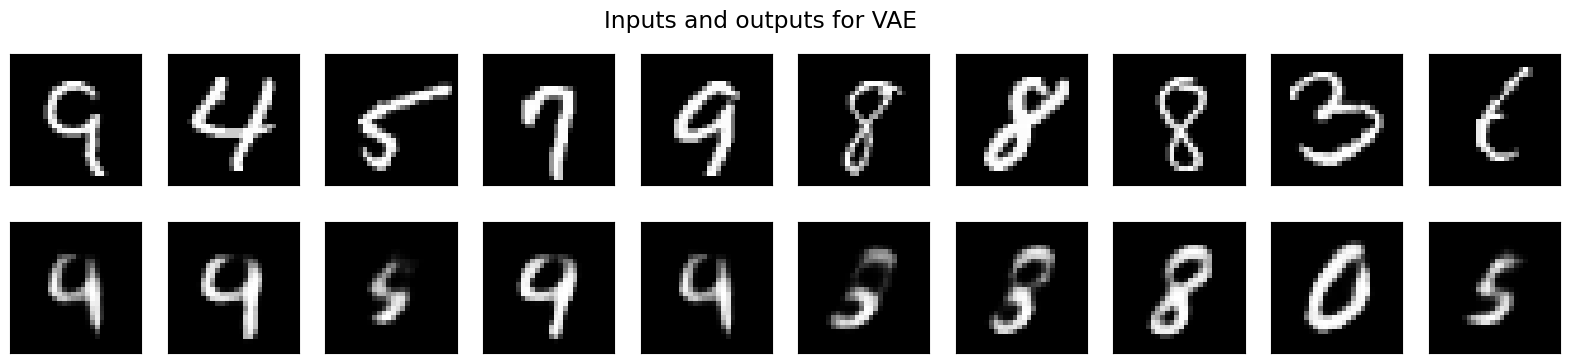

313/313 [==============================] - 1s 2ms/step


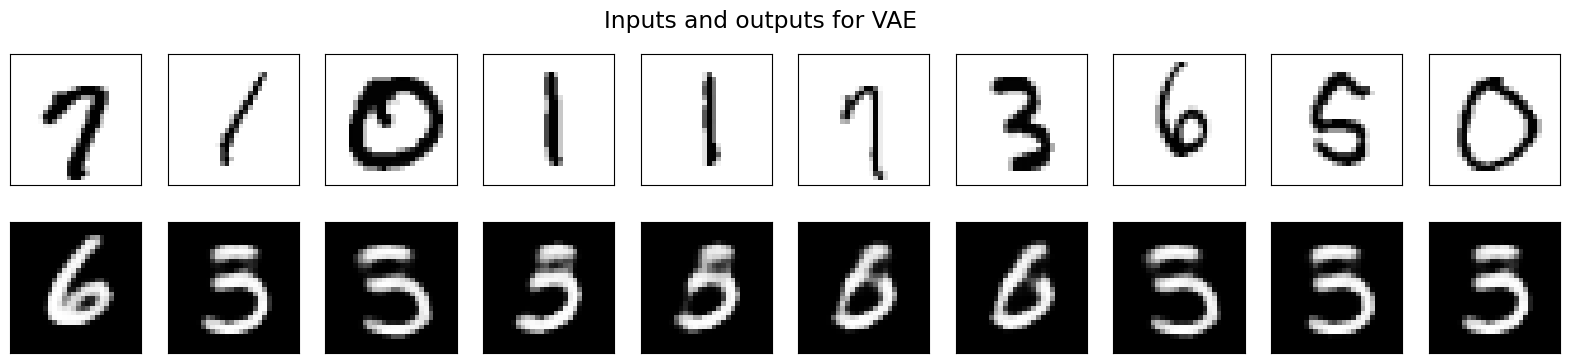

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


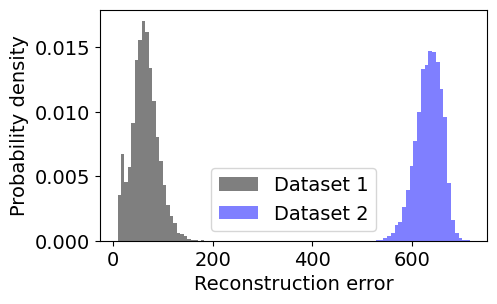

313/313 [==============================] - 1s 2ms/step


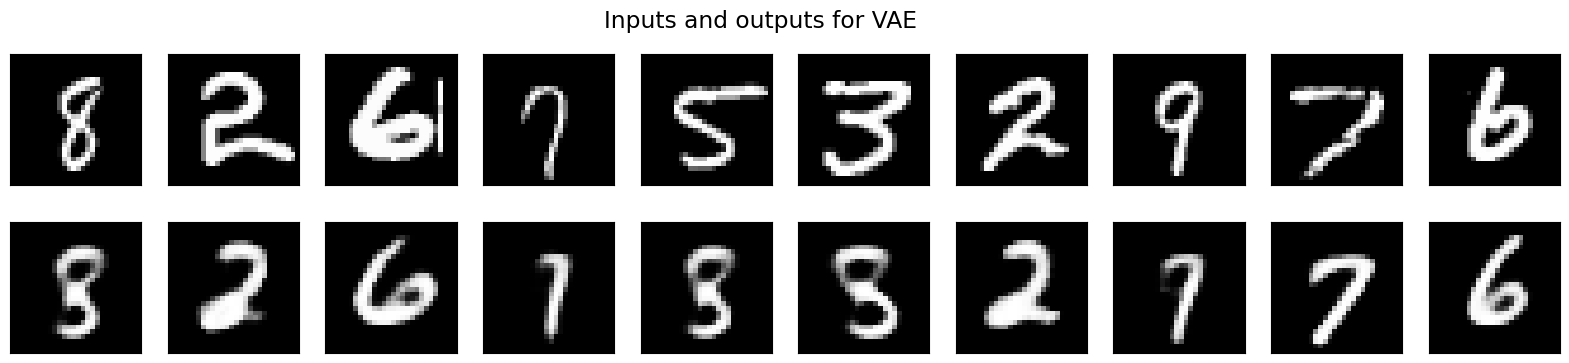

<Figure size 500x300 with 0 Axes>

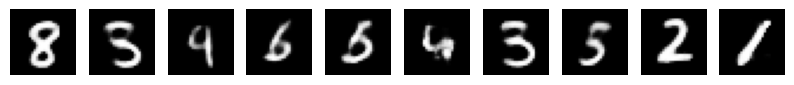

Show training samples:


<Figure size 500x300 with 0 Axes>

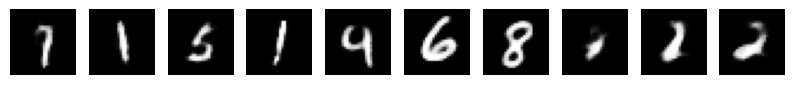

313/313 [==============================] - 1s 2ms/step


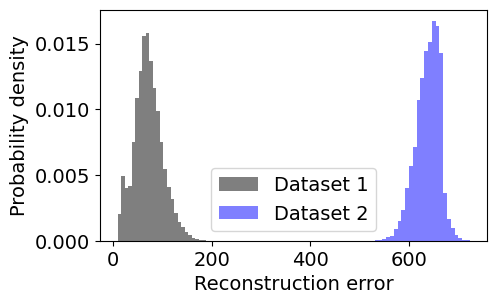

313/313 [==============================] - 1s 3ms/step


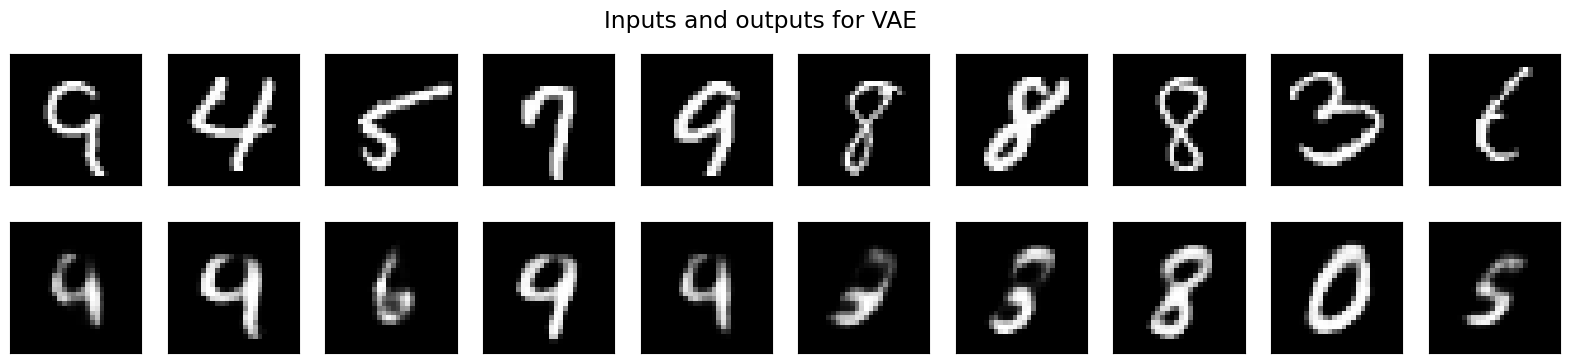

313/313 [==============================] - 1s 2ms/step


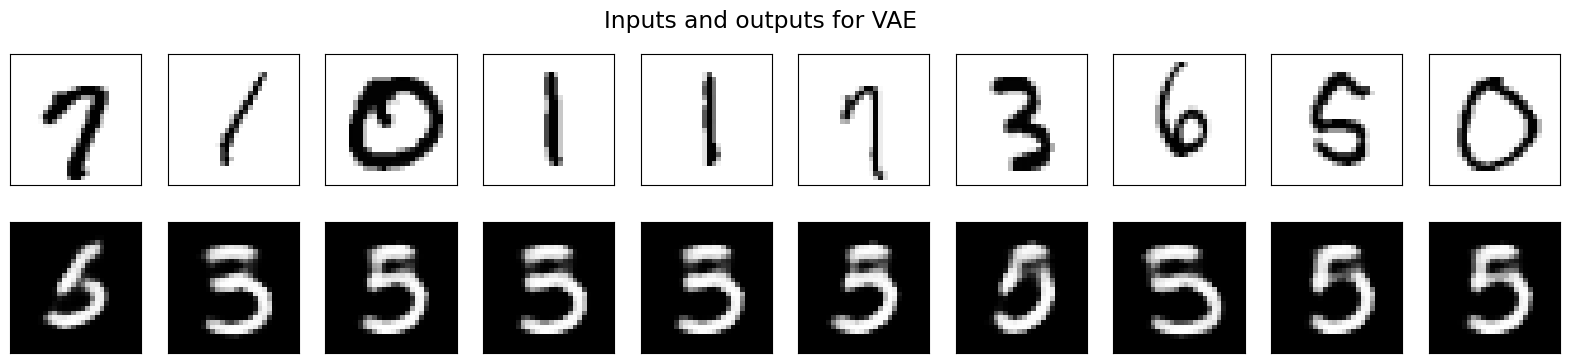

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


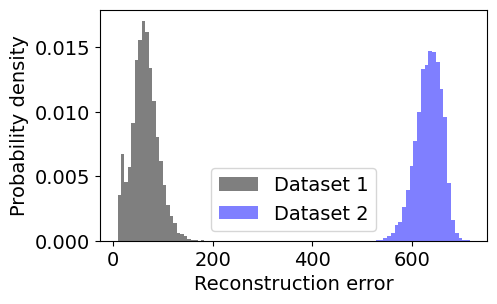

313/313 [==============================] - 1s 2ms/step


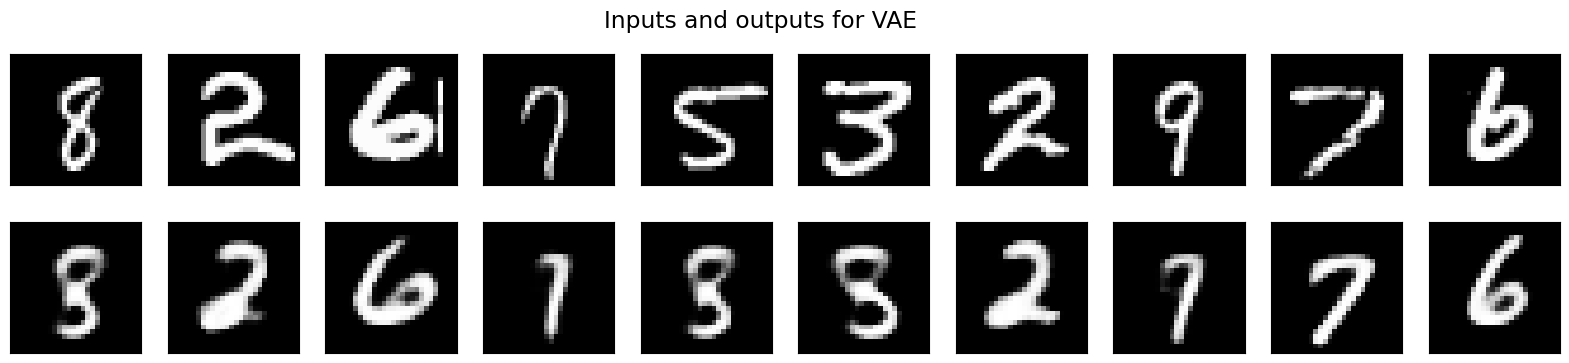

<Figure size 500x300 with 0 Axes>

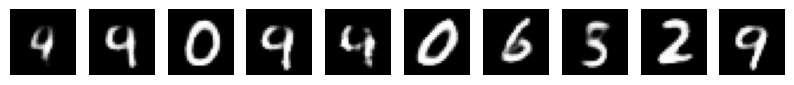

Show training samples:


<Figure size 500x300 with 0 Axes>

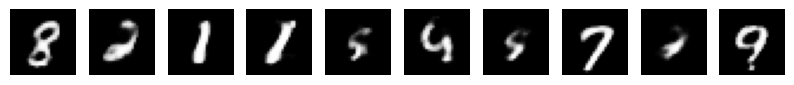

313/313 [==============================] - 1s 2ms/step


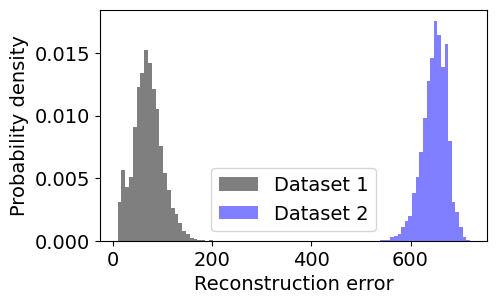

313/313 [==============================] - 1s 2ms/step


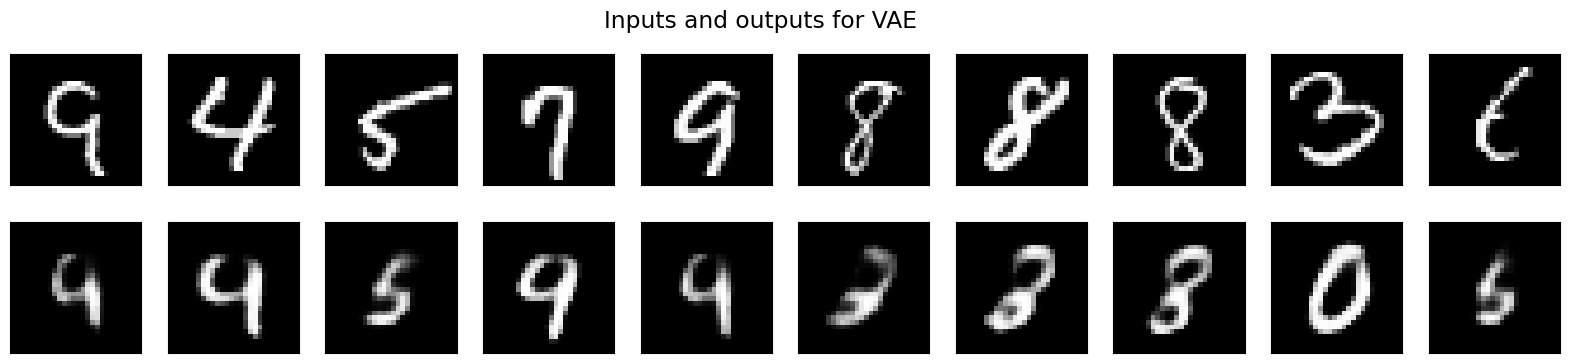

313/313 [==============================] - 1s 2ms/step


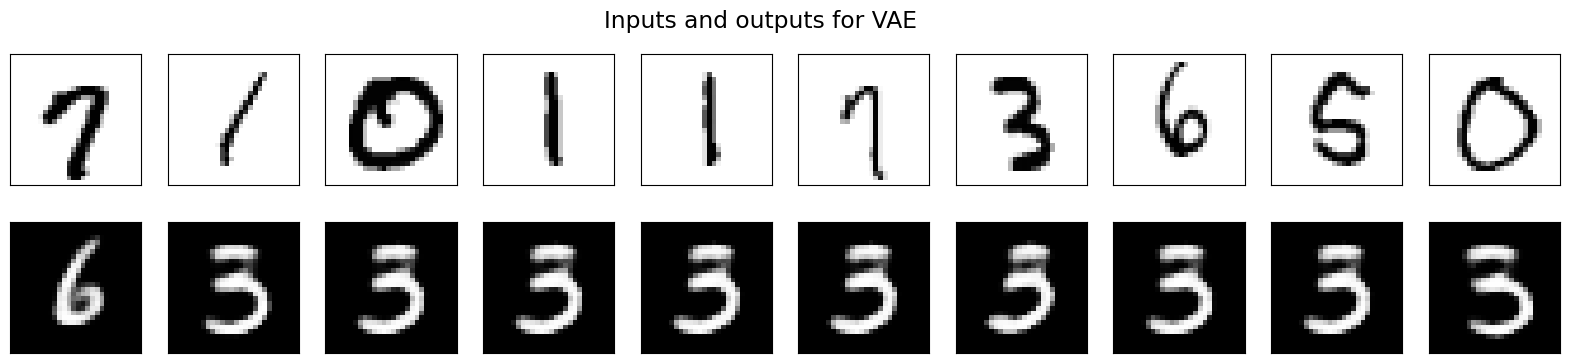

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


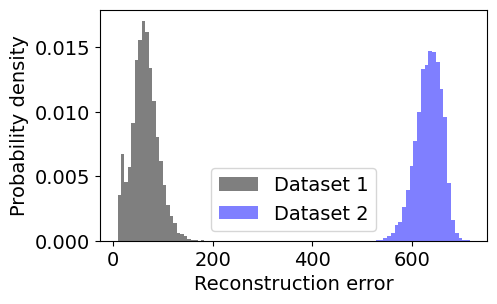

313/313 [==============================] - 1s 2ms/step


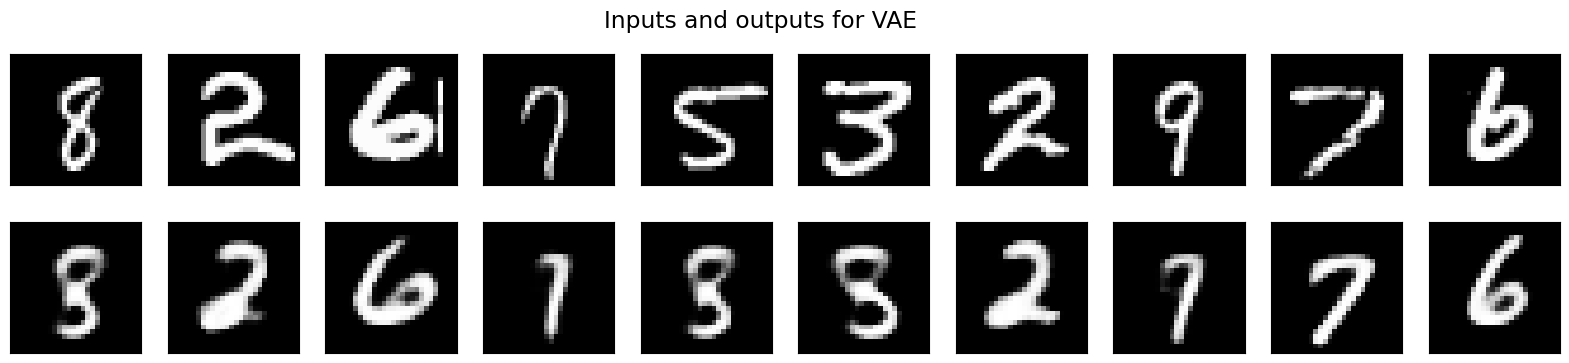

<Figure size 500x300 with 0 Axes>

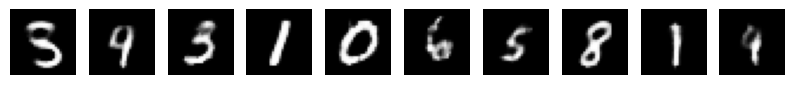

Show training samples:


<Figure size 500x300 with 0 Axes>

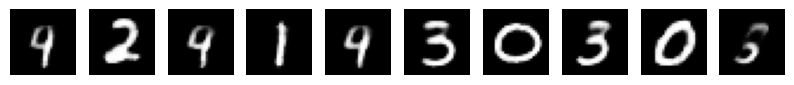

313/313 [==============================] - 1s 2ms/step


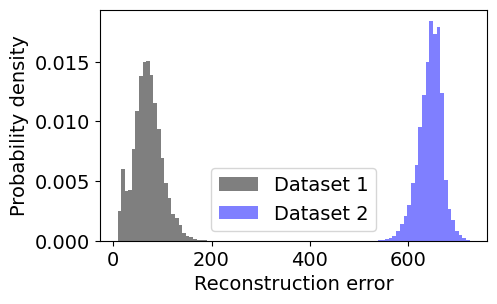

313/313 [==============================] - 1s 2ms/step


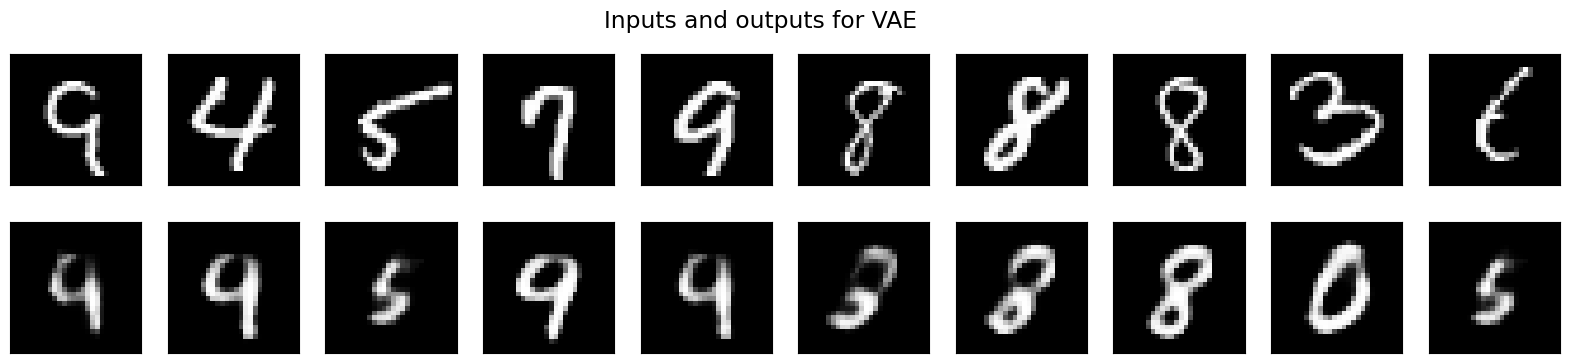

313/313 [==============================] - 1s 2ms/step


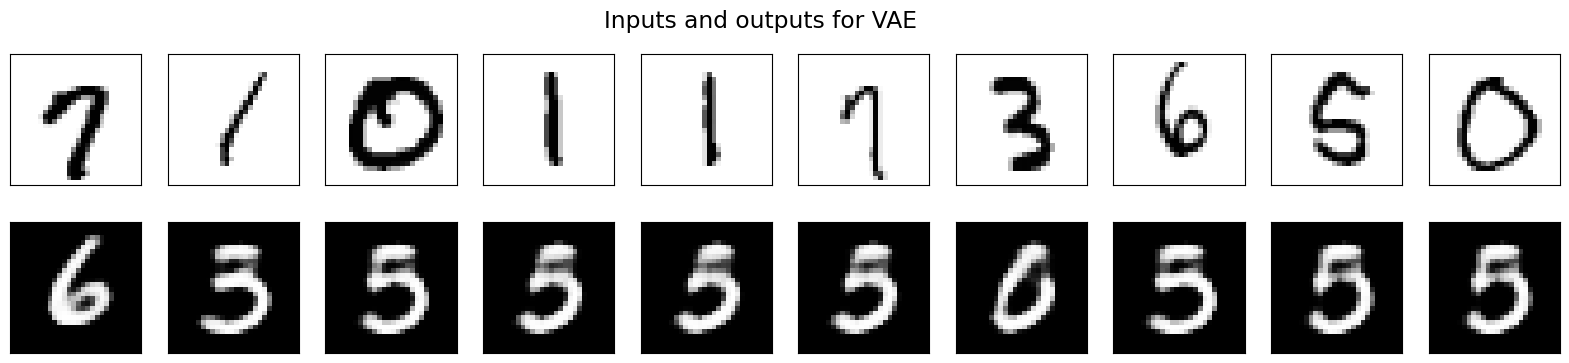

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


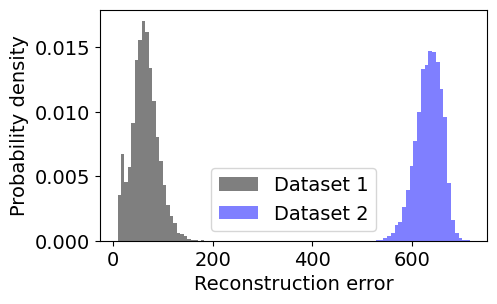

313/313 [==============================] - 1s 2ms/step


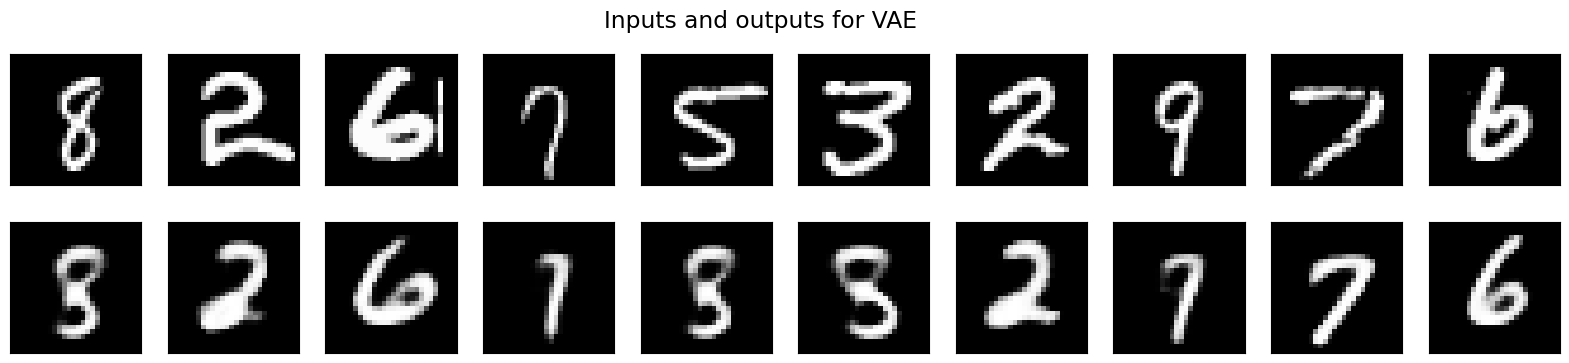

<Figure size 500x300 with 0 Axes>

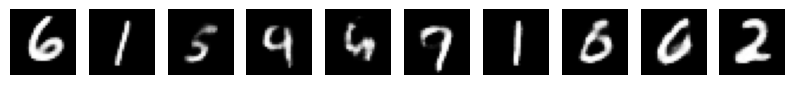

Show training samples:


<Figure size 500x300 with 0 Axes>

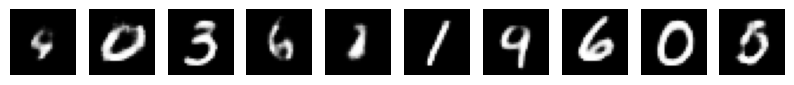

313/313 [==============================] - 1s 2ms/step


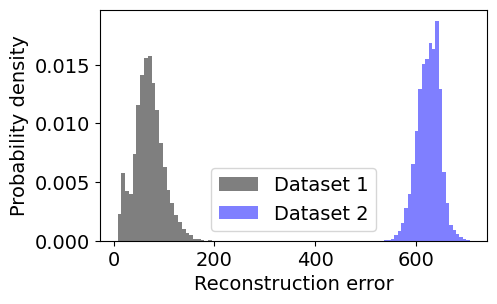

313/313 [==============================] - 1s 2ms/step


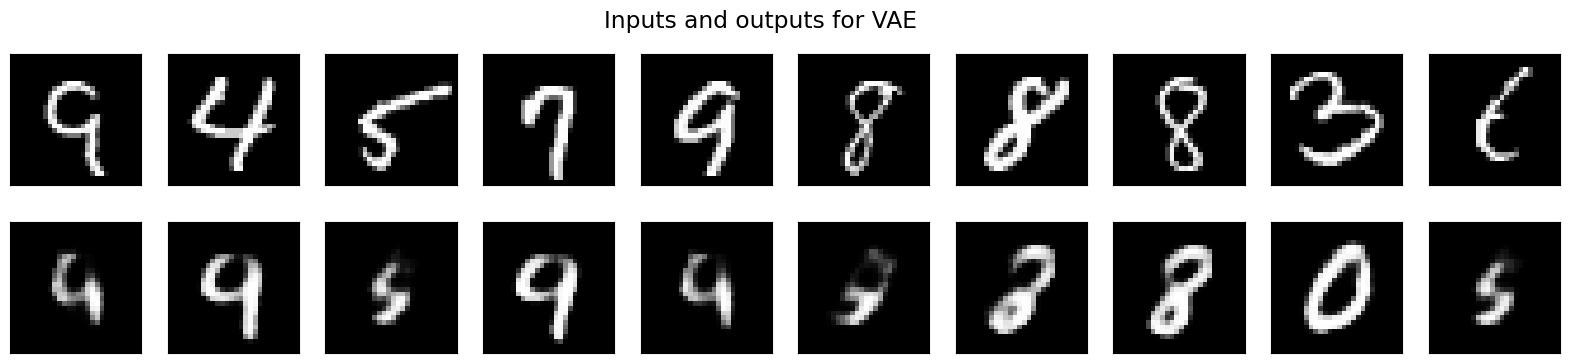

313/313 [==============================] - 1s 2ms/step


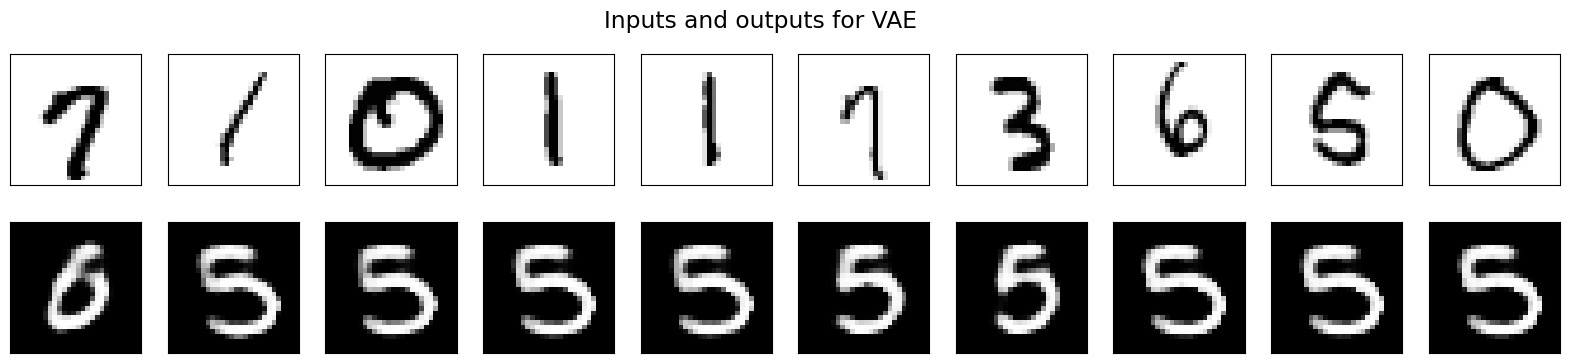

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


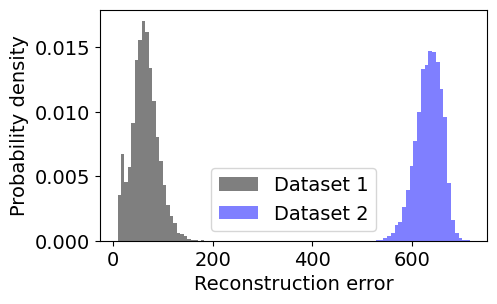

313/313 [==============================] - 1s 2ms/step


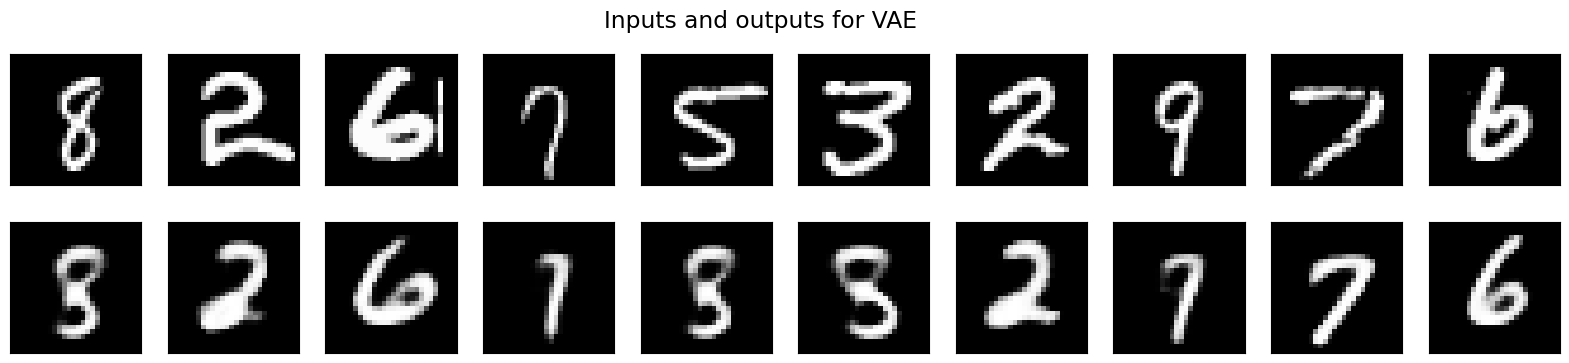

<Figure size 500x300 with 0 Axes>

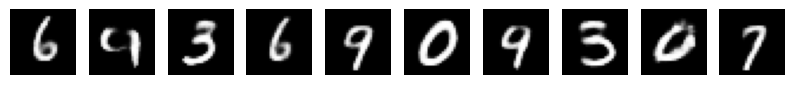

Show training samples:


<Figure size 500x300 with 0 Axes>

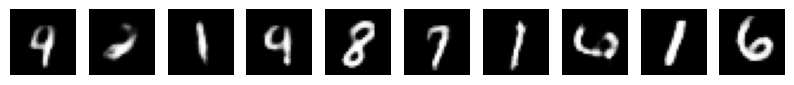

313/313 [==============================] - 1s 2ms/step


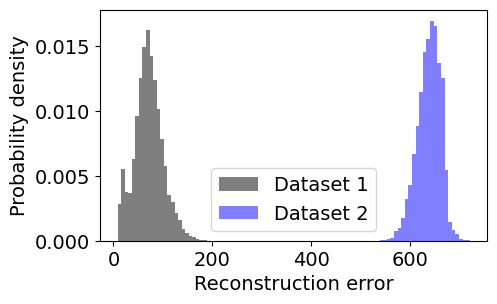

313/313 [==============================] - 1s 2ms/step


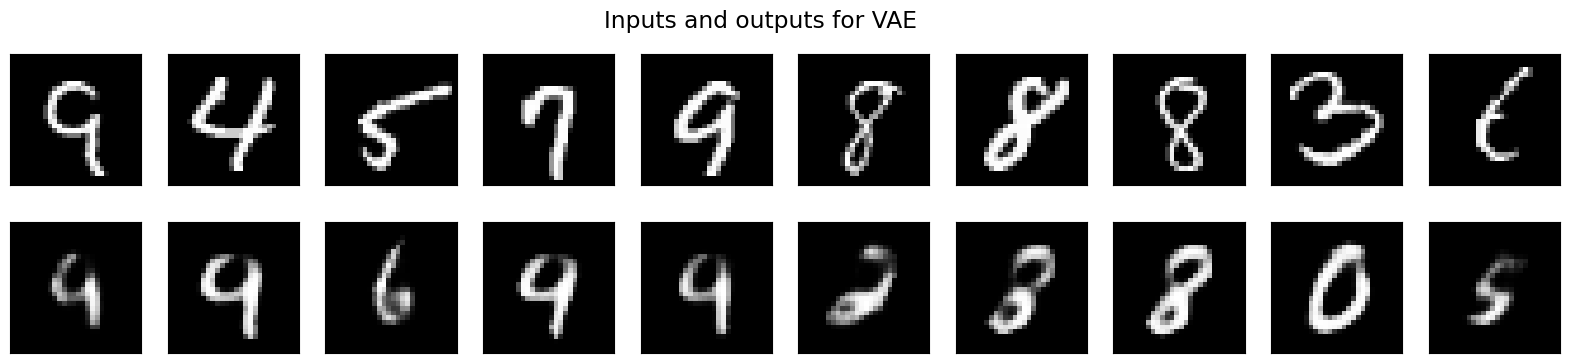

313/313 [==============================] - 1s 2ms/step


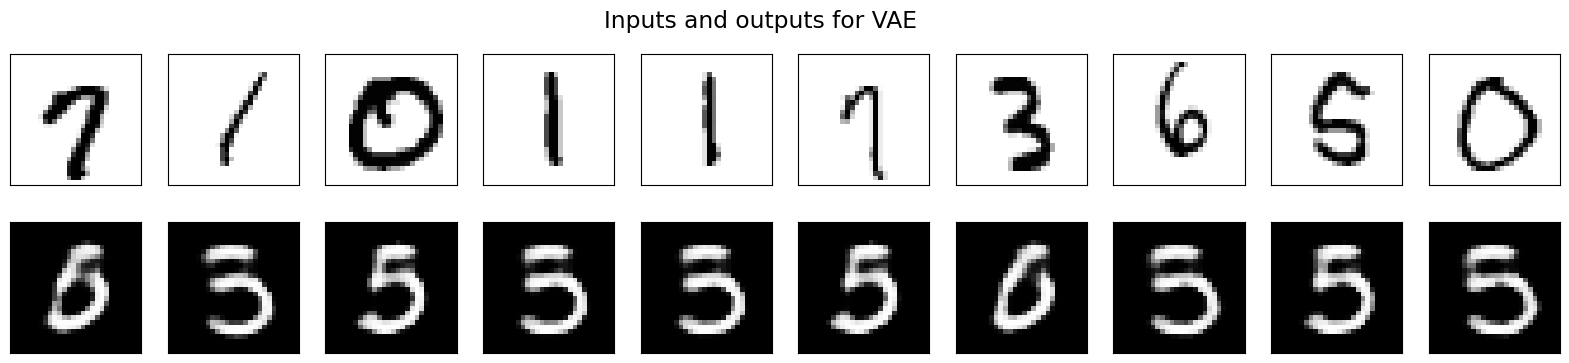

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


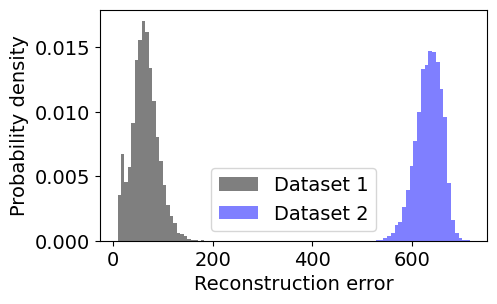

313/313 [==============================] - 1s 2ms/step


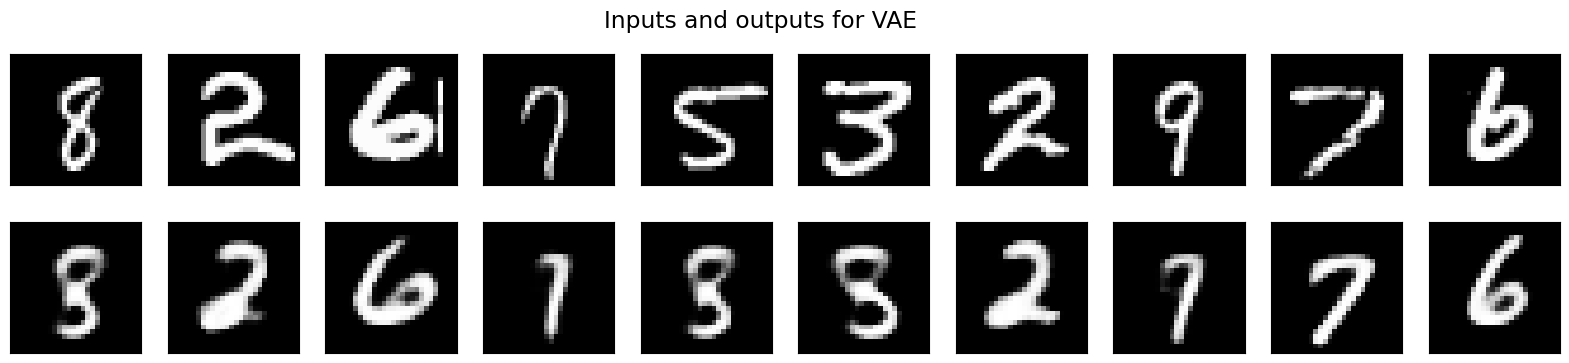

<Figure size 500x300 with 0 Axes>

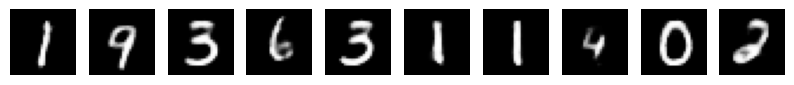

Show training samples:


<Figure size 500x300 with 0 Axes>

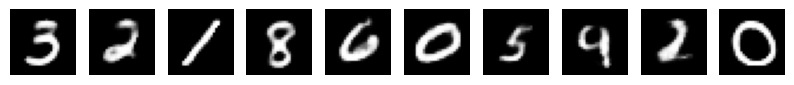

313/313 [==============================] - 1s 2ms/step


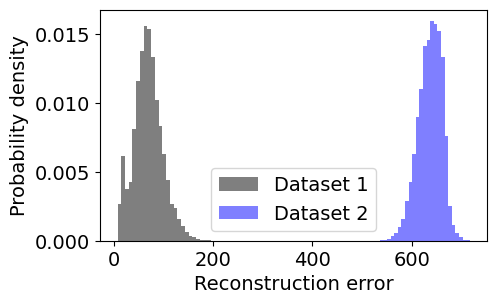

313/313 [==============================] - 1s 2ms/step


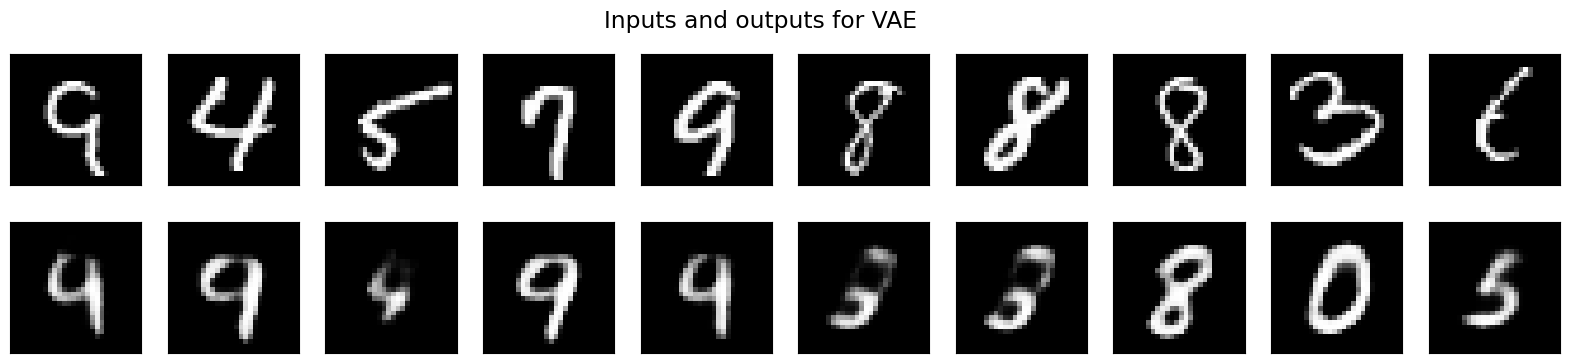

313/313 [==============================] - 1s 2ms/step


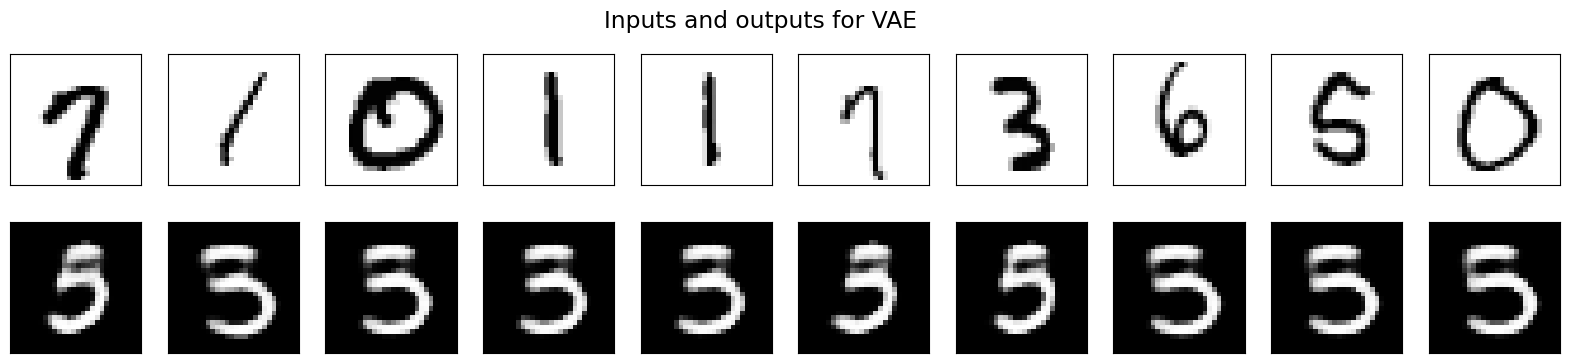

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


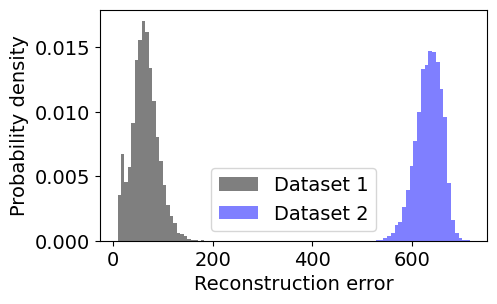

313/313 [==============================] - 1s 2ms/step


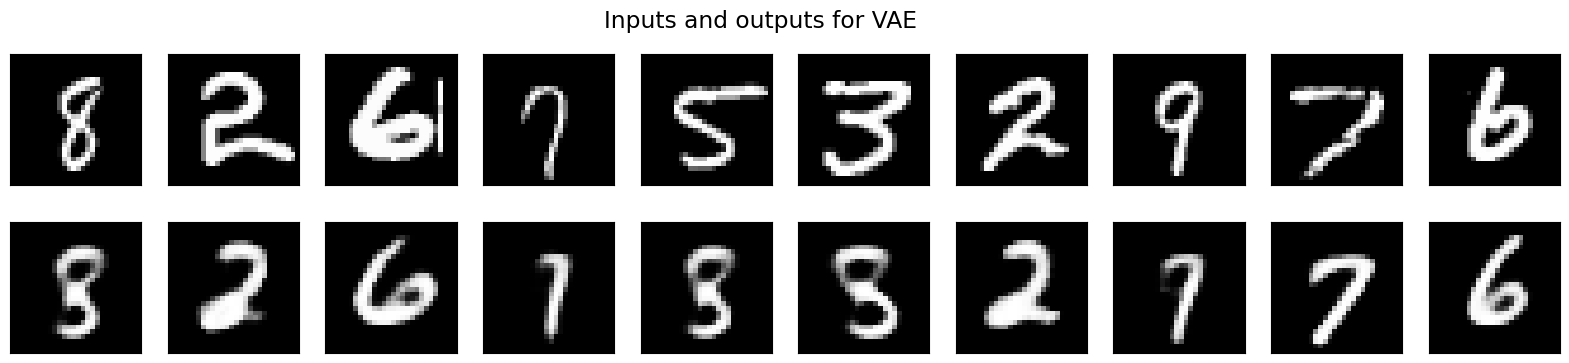

<Figure size 500x300 with 0 Axes>

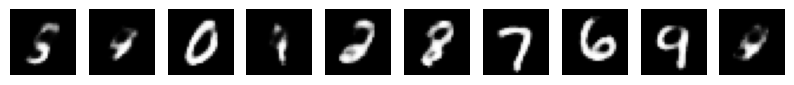

Show training samples:


<Figure size 500x300 with 0 Axes>

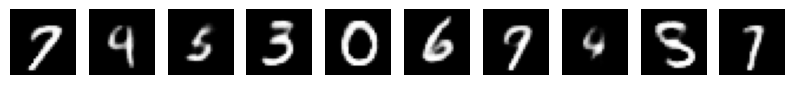

313/313 [==============================] - 1s 2ms/step


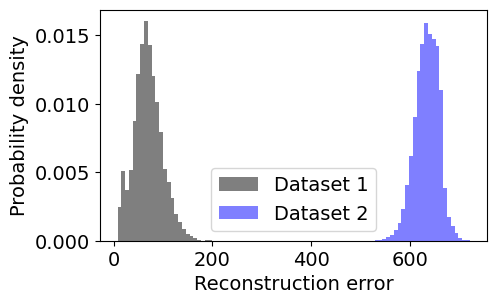

313/313 [==============================] - 1s 2ms/step


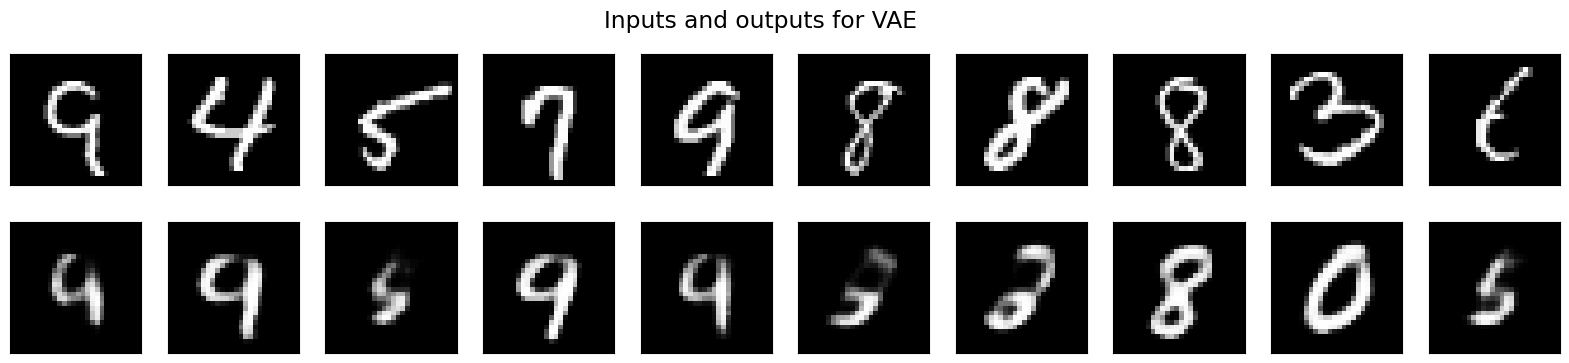

313/313 [==============================] - 1s 2ms/step


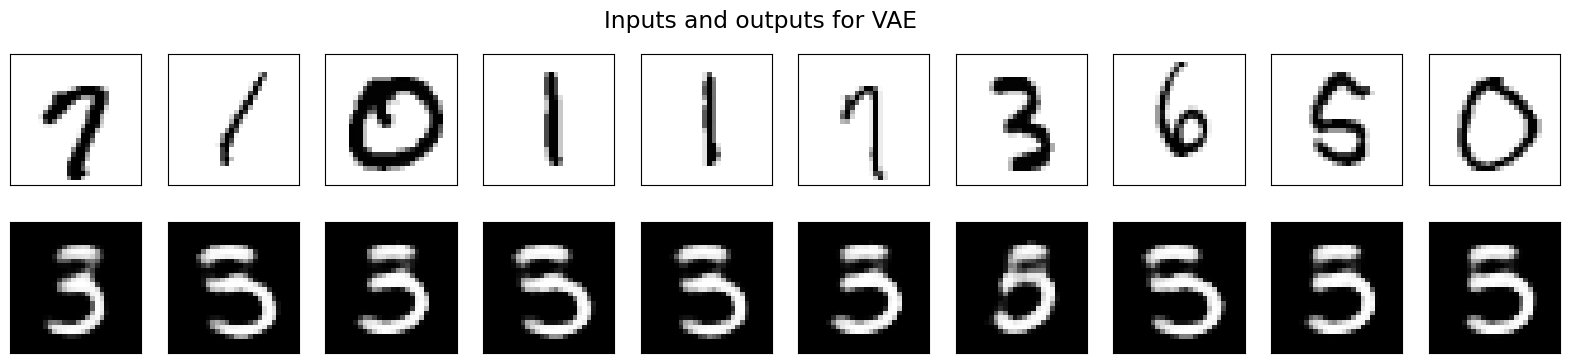

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


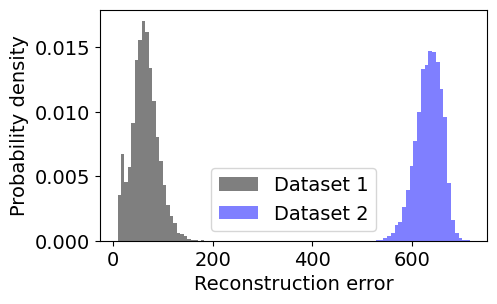

313/313 [==============================] - 1s 2ms/step


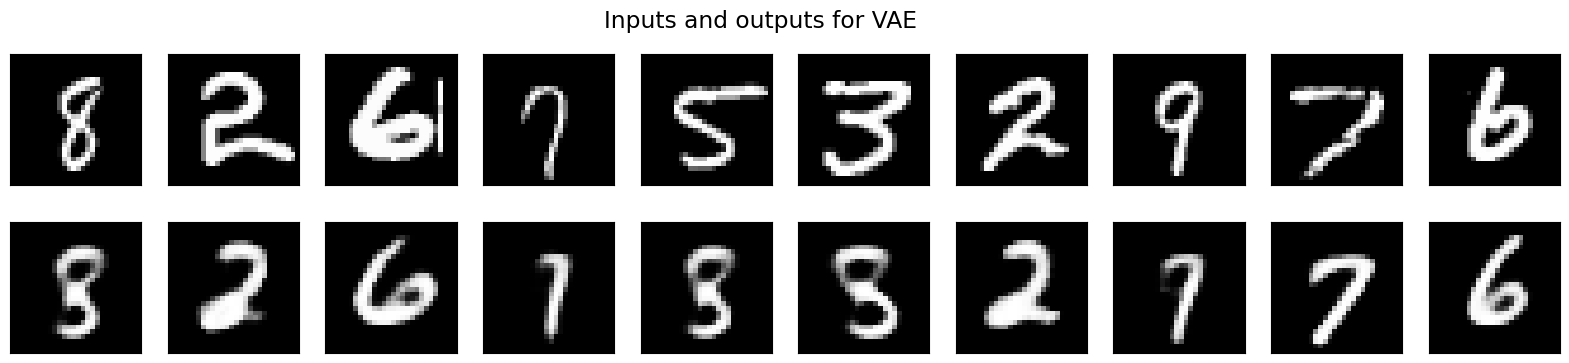

<Figure size 500x300 with 0 Axes>

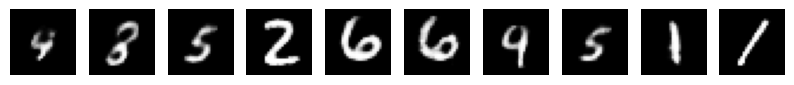

Show training samples:


<Figure size 500x300 with 0 Axes>

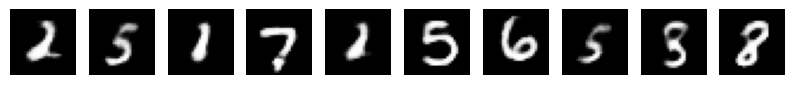

313/313 [==============================] - 1s 2ms/step


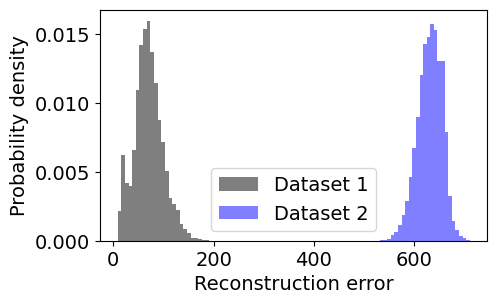

313/313 [==============================] - 1s 2ms/step


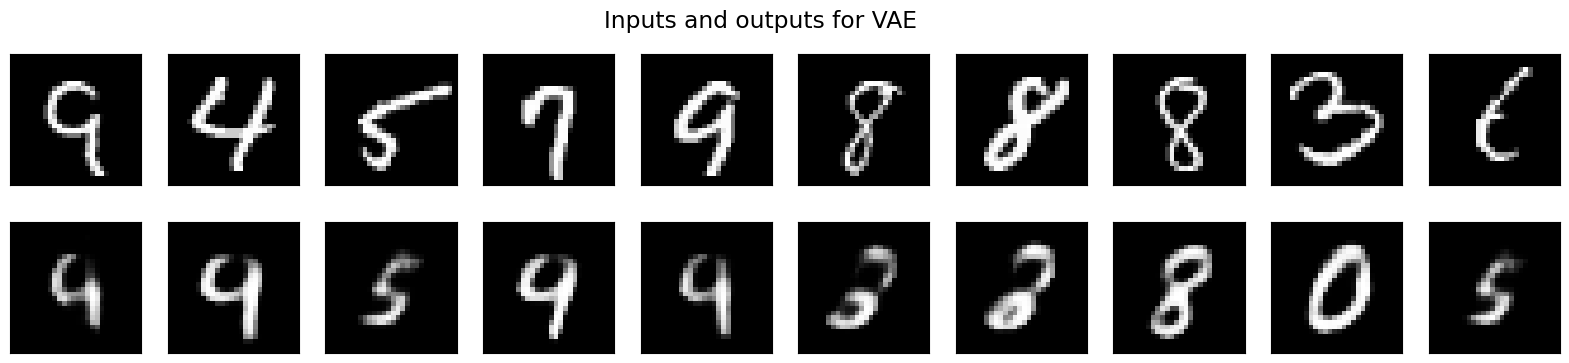

313/313 [==============================] - 1s 2ms/step


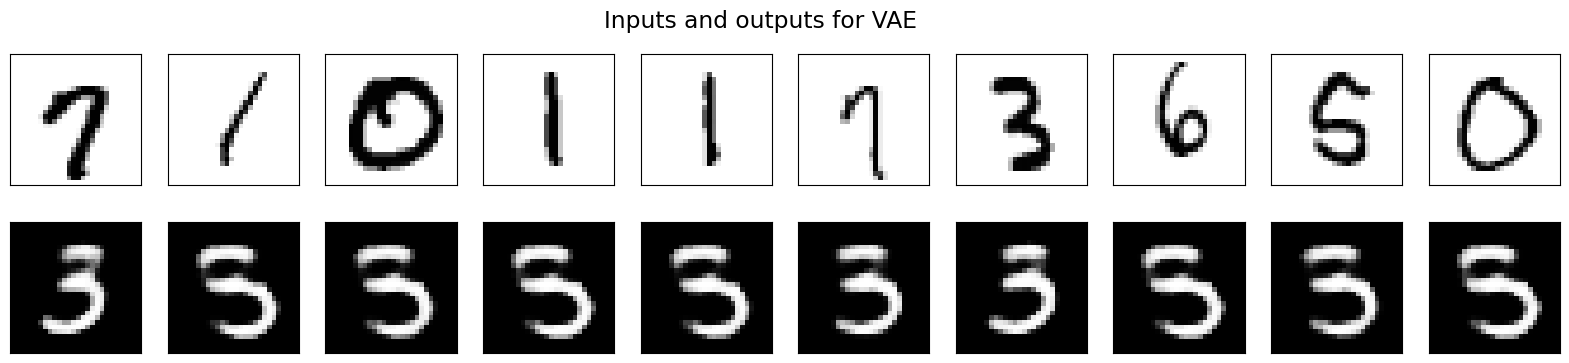

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


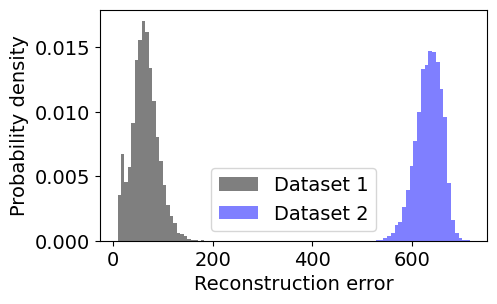

313/313 [==============================] - 1s 3ms/step


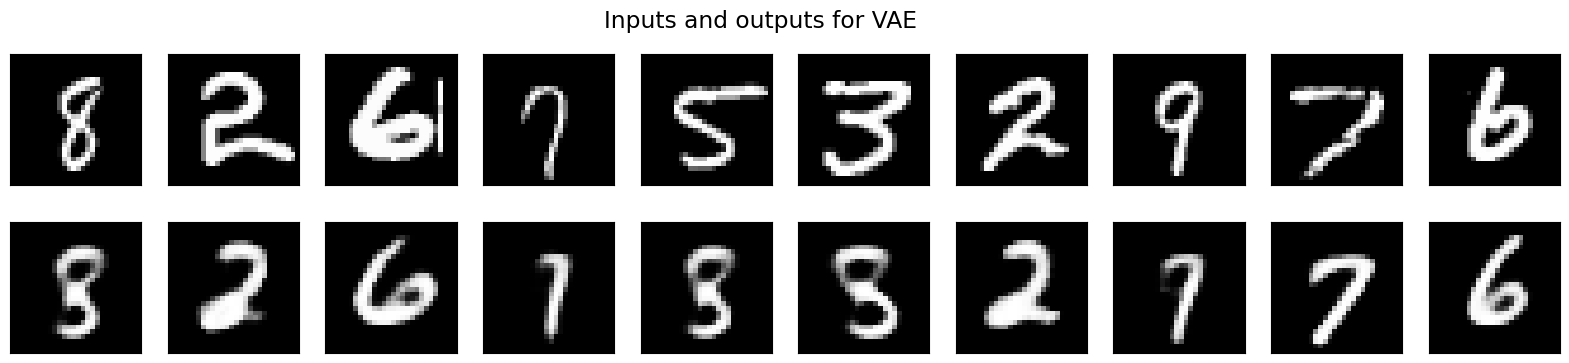

<Figure size 500x300 with 0 Axes>

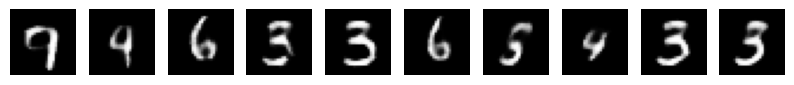

Show training samples:


<Figure size 500x300 with 0 Axes>

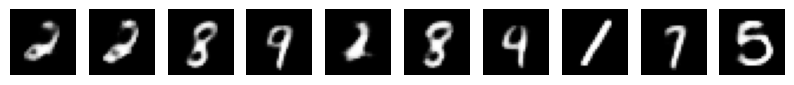

313/313 [==============================] - 1s 2ms/step


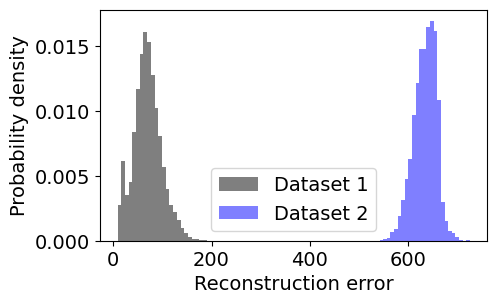

313/313 [==============================] - 1s 2ms/step


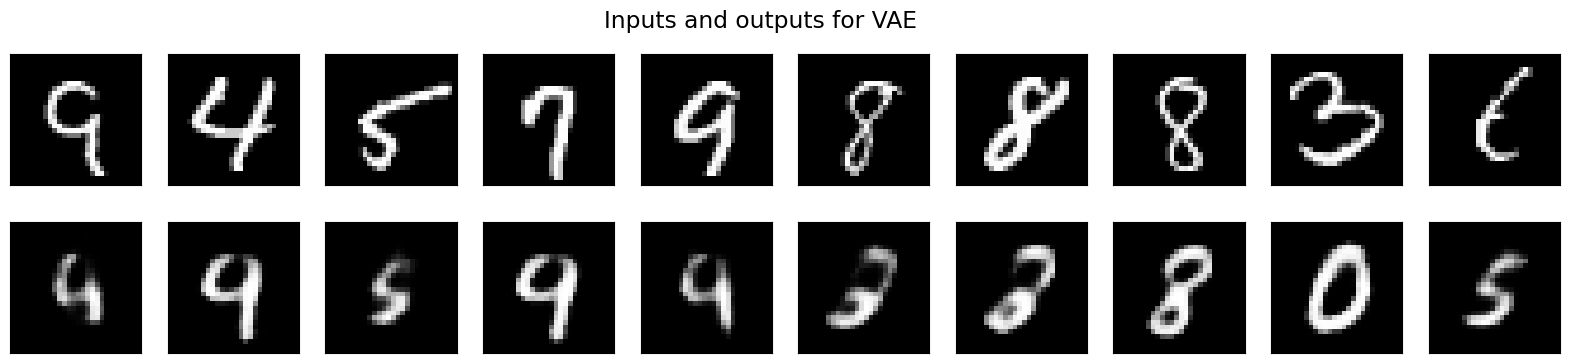

313/313 [==============================] - 1s 2ms/step


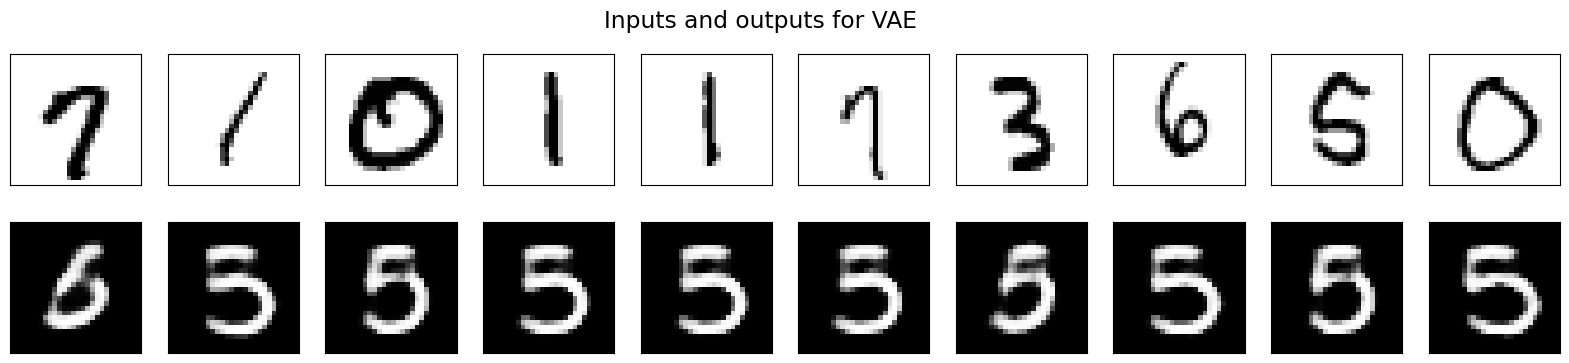

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


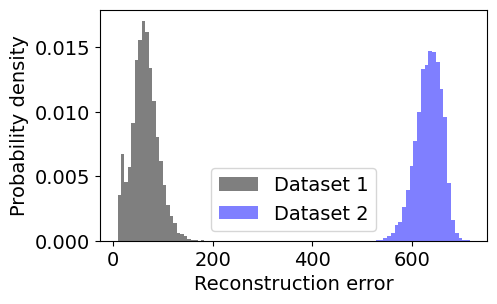

313/313 [==============================] - 1s 2ms/step


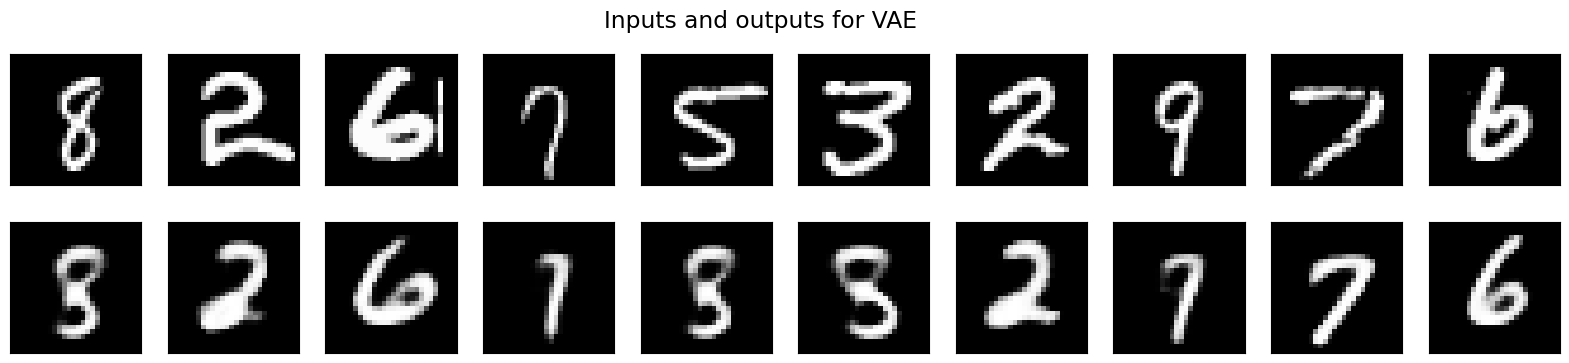

<Figure size 500x300 with 0 Axes>

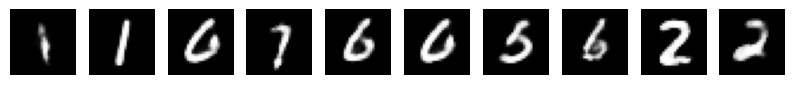

Show training samples:


<Figure size 500x300 with 0 Axes>

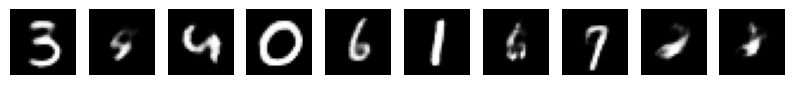

313/313 [==============================] - 1s 2ms/step


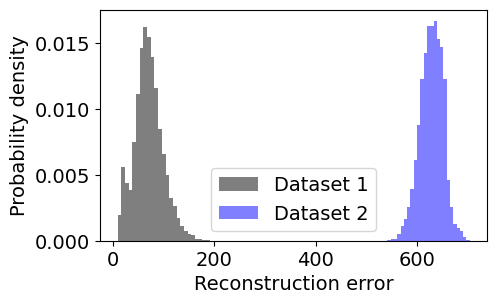

313/313 [==============================] - 1s 2ms/step


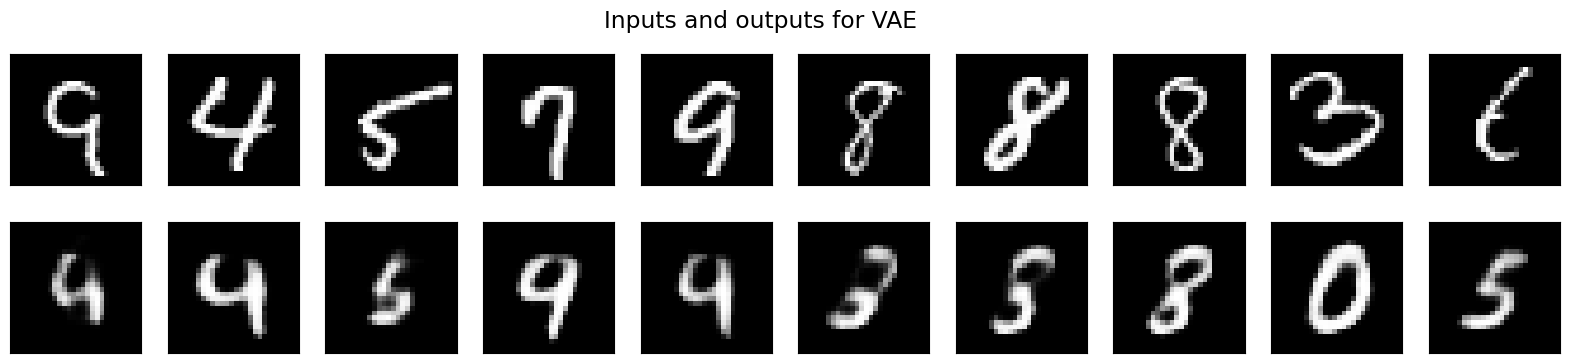

313/313 [==============================] - 1s 3ms/step


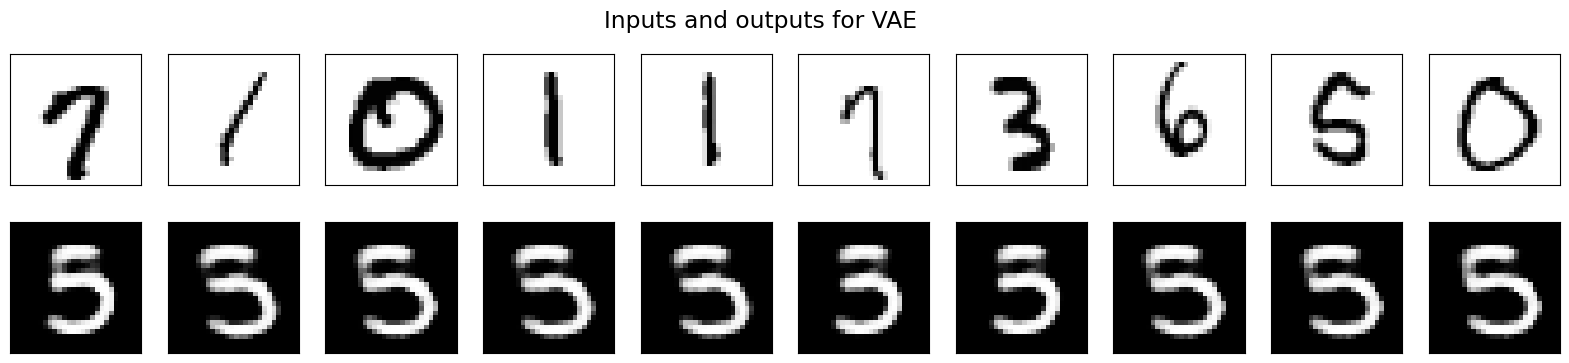

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


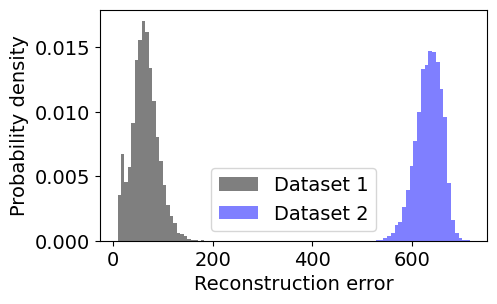

313/313 [==============================] - 1s 2ms/step


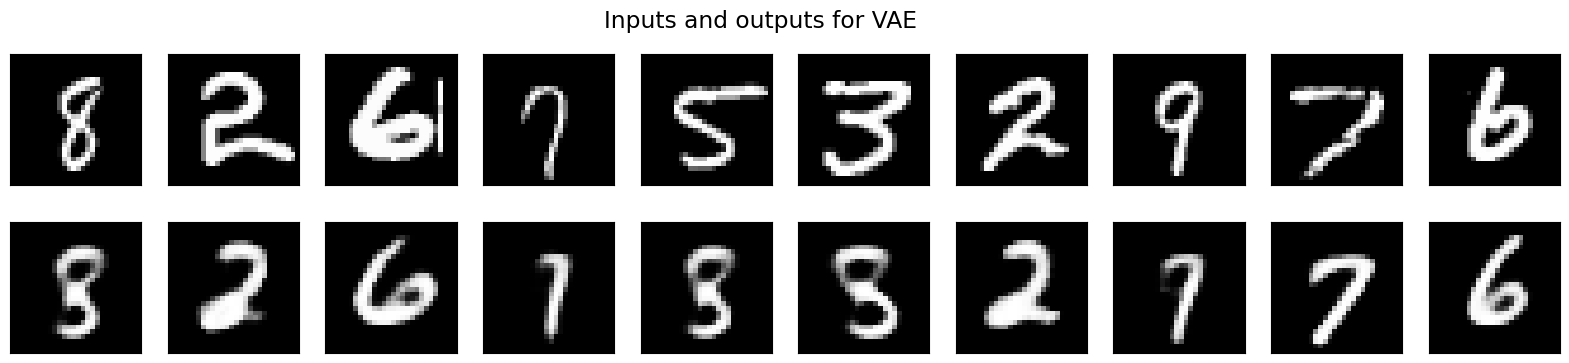

<Figure size 500x300 with 0 Axes>

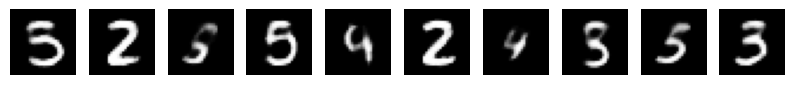

Show training samples:


<Figure size 500x300 with 0 Axes>

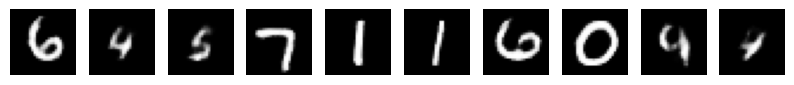

313/313 [==============================] - 1s 3ms/step


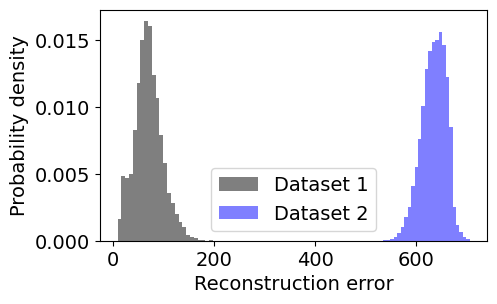

313/313 [==============================] - 1s 2ms/step


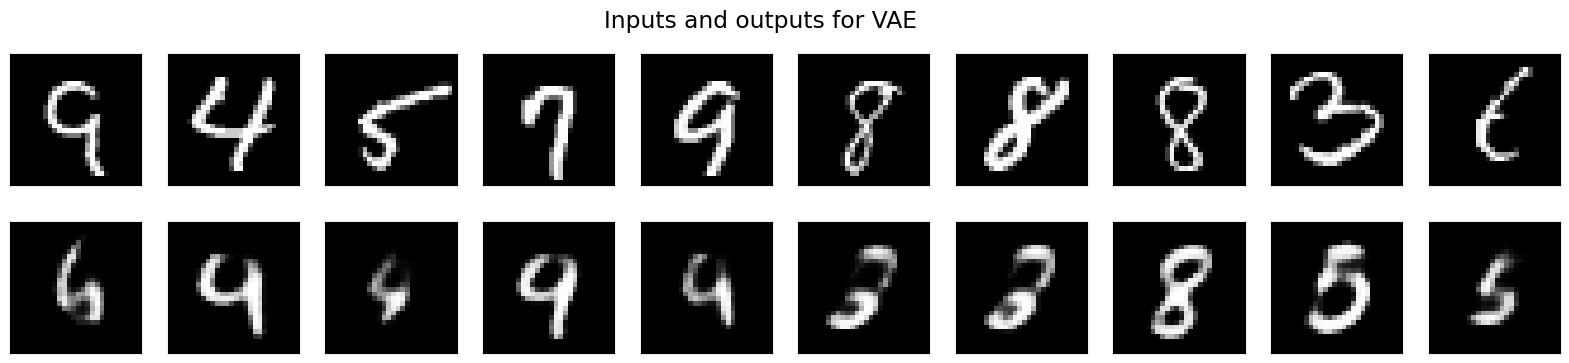

313/313 [==============================] - 1s 2ms/step


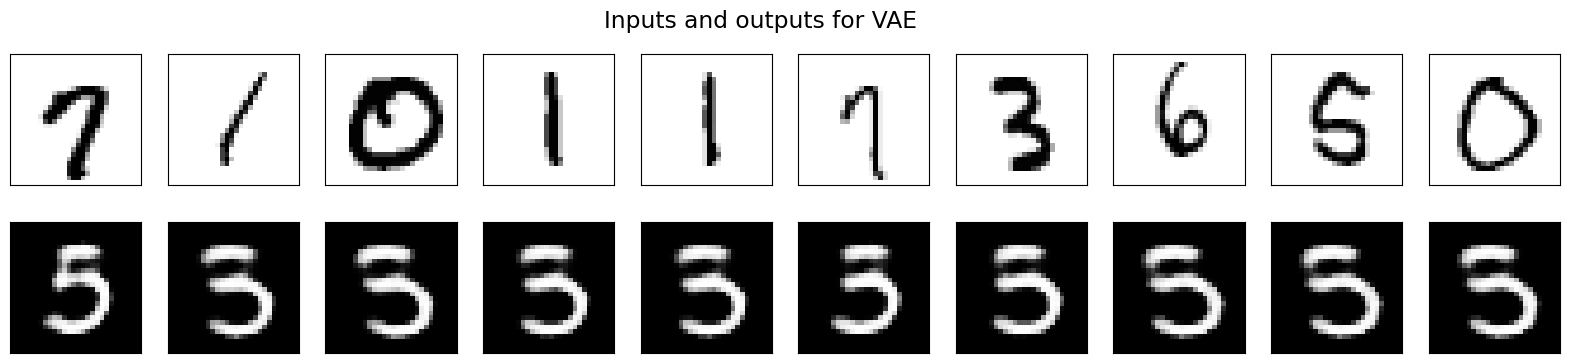

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


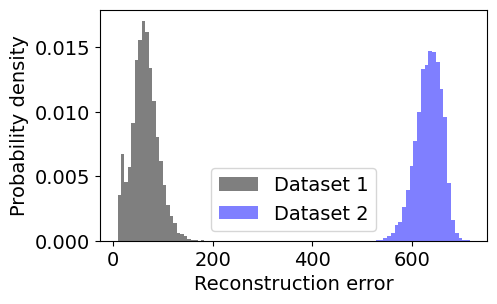

313/313 [==============================] - 1s 2ms/step


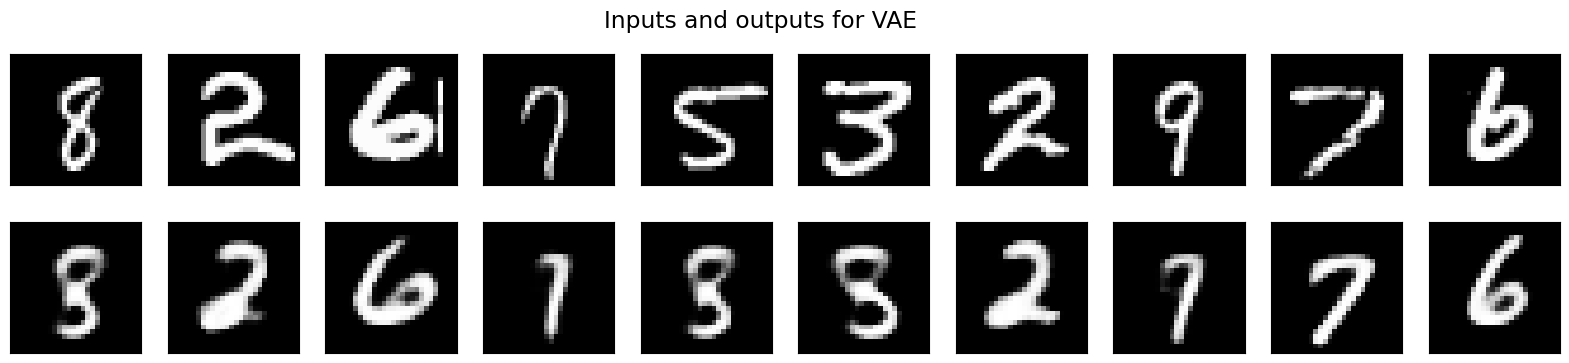

<Figure size 500x300 with 0 Axes>

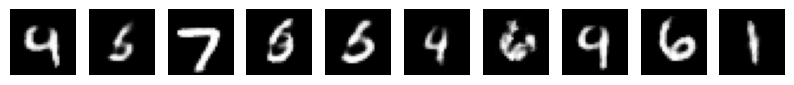

Show training samples:


<Figure size 500x300 with 0 Axes>

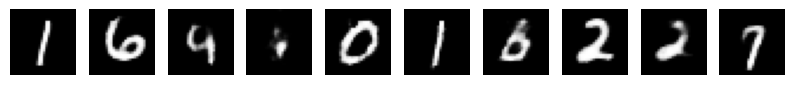

313/313 [==============================] - 1s 2ms/step


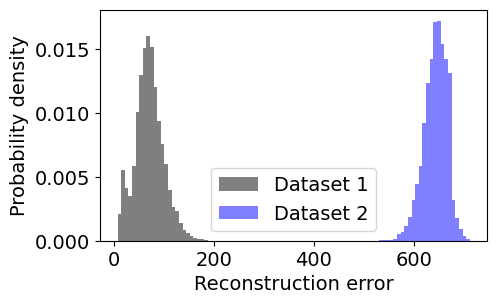

313/313 [==============================] - 1s 2ms/step


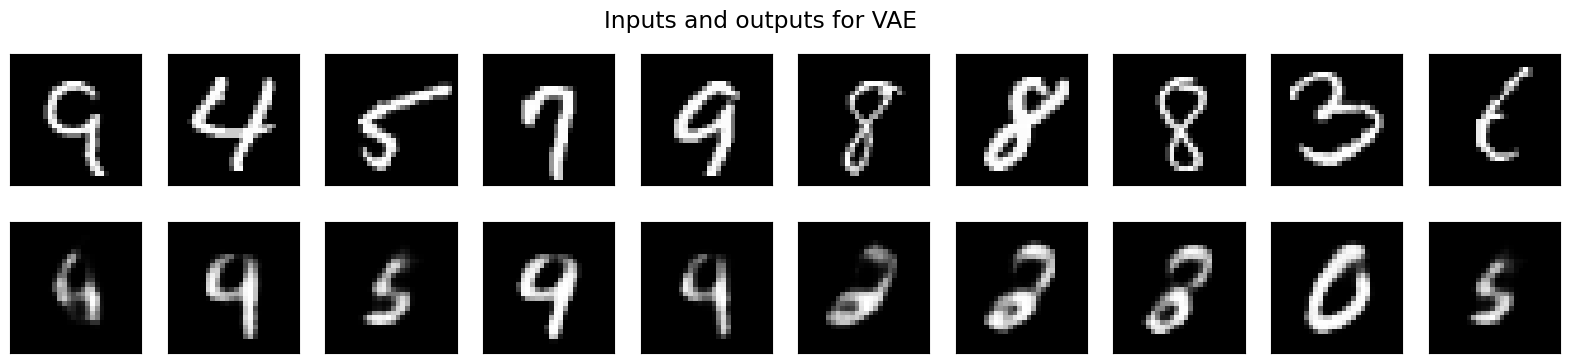

313/313 [==============================] - 1s 2ms/step


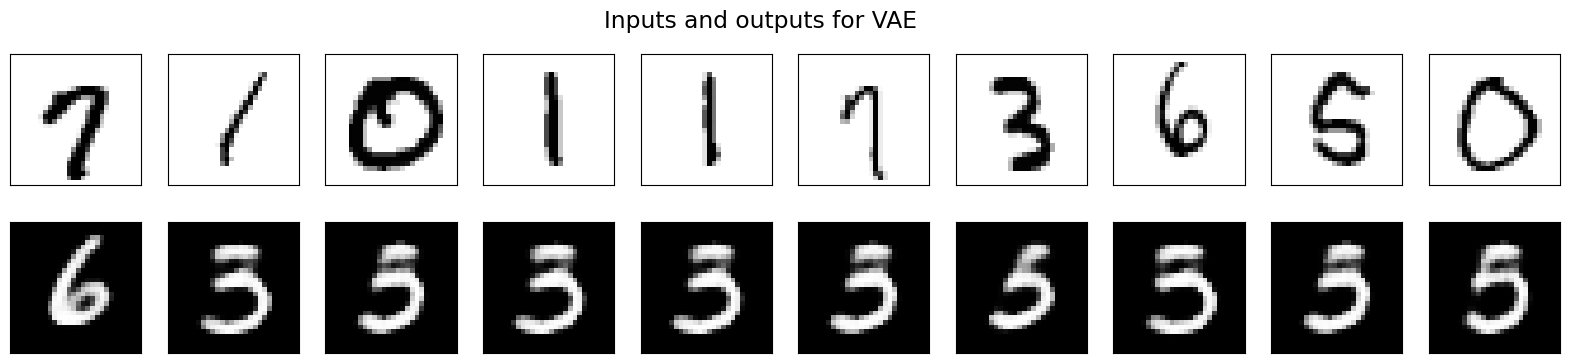

Starting with saved weights:
313/313 [==============================] - 1s 2ms/step


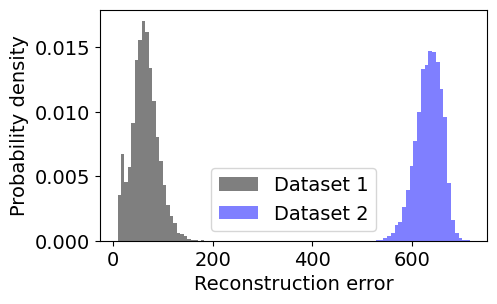

313/313 [==============================] - 1s 2ms/step


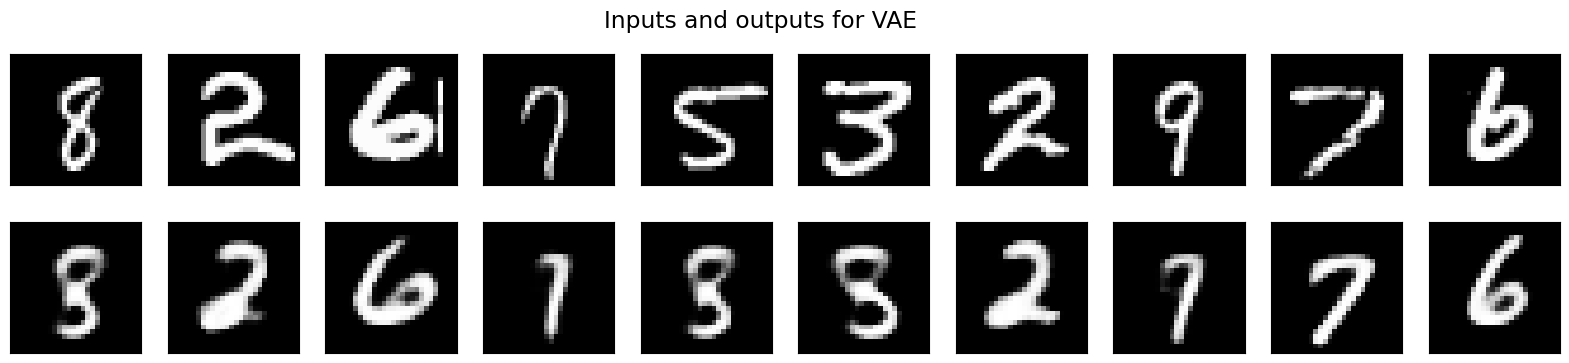

<Figure size 500x300 with 0 Axes>

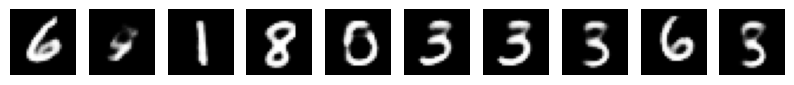

Show training samples:


<Figure size 500x300 with 0 Axes>

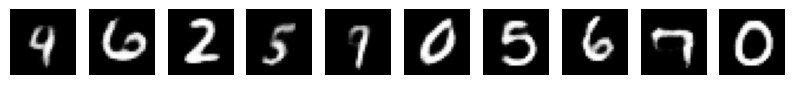

313/313 [==============================] - 1s 2ms/step


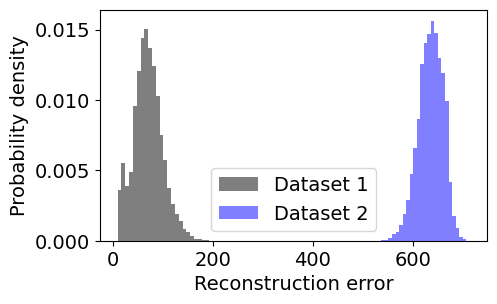

313/313 [==============================] - 1s 3ms/step


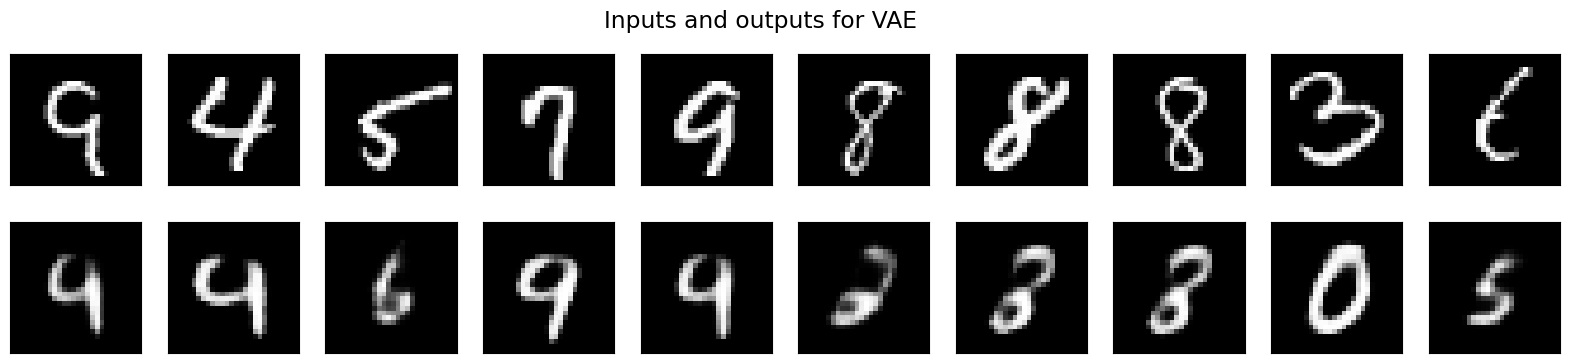

313/313 [==============================] - 1s 2ms/step


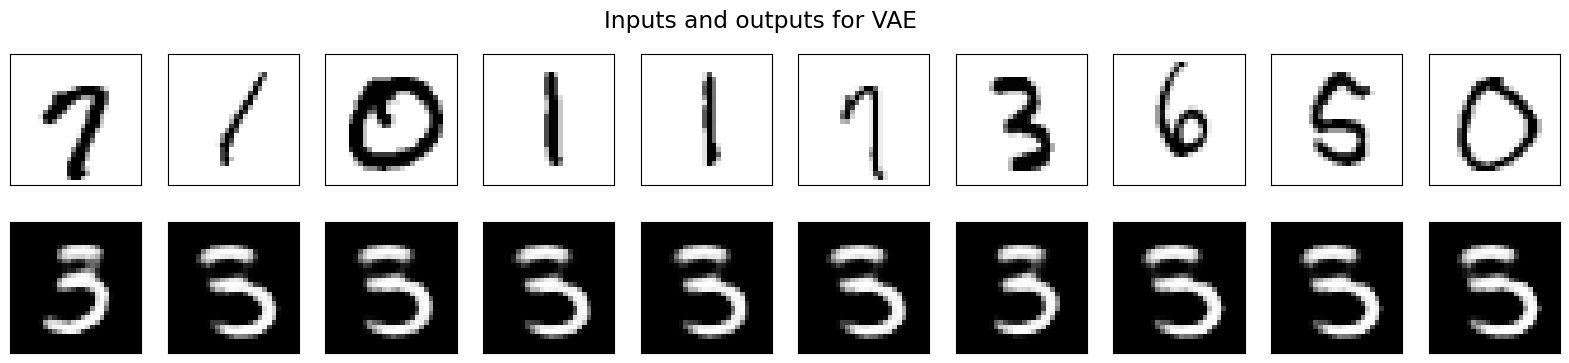

In [ ]:
all_mnist_errors = {}
all_fmnist_errors = {}

#for num_sampled in [0,10,20,25,30,35,40,50,60]:
for num_epochs in [0,200,400,600,800,1000]:
    all_mnist_errors[num_epochs] = []
    all_fmnist_errors[num_epochs] = []
    for trial in range(3):
        mnist_errors, fmnist_errors = shuffled_baselines_with_ratio(baseline_type='both',
                                                         inverted=True,
                                                         ratio_old=1,
                                                         ratio_new=0)
        all_mnist_errors[num_epochs].append(mnist_errors)
        all_fmnist_errors[num_epochs].append(fmnist_errors)

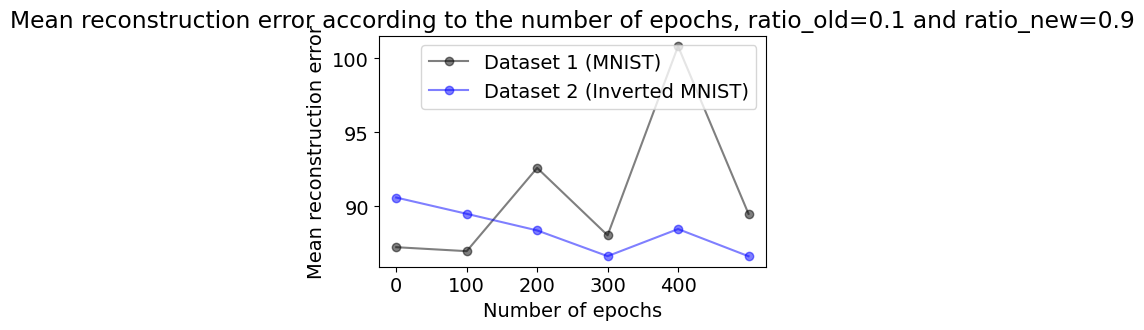

In [ ]:
epoch_sizes = sorted(all_mnist_errors.keys())

mnist_means = [np.mean([x[1] for x in all_mnist_errors[s]]) for s in epoch_sizes]
mnist_sems = [np.std([x[1] for x in all_mnist_errors[s]]) / np.sqrt(len([x[1] for x in all_mnist_errors[s]])) for s in epoch_sizes]

fmnist_means = [np.mean([x[1] for x in all_fmnist_errors[s]]) for s in epoch_sizes]
fmnist_sems = [np.std([x[1] for x in all_fmnist_errors[s]]) / np.sqrt(len([x[1] for x in all_mnist_errors[s]])) for s in epoch_sizes]

plt.figure(figsize=(5, 3))
plt.plot(epoch_sizes, mnist_means, label='Dataset 1 (MNIST)', color='black', marker='o', alpha=0.5)
plt.plot(epoch_sizes, fmnist_means, label='Dataset 2 (Inverted MNIST)', color='blue', marker='o', alpha=0.5)

plt.xlabel('Number of epochs')
plt.ylabel('Mean reconstruction error')
#plt.xticks(range(0,60,10))
plt.xticks(range(0,1000,200))
#have to change above for each plot
plt.title('Mean reconstruction error according to the number of epochs, ratio_old=1 and ratio_new=0')
# have to change above for each plot
plt.legend()
plt.savefig('number_of_epochs.png', bbox_inches='tight')
plt.show()

11490434/11490434 [==============================] - 0s 0us/step
Starting with saved weights:
313/313 [==============================] - 6s 18ms/step


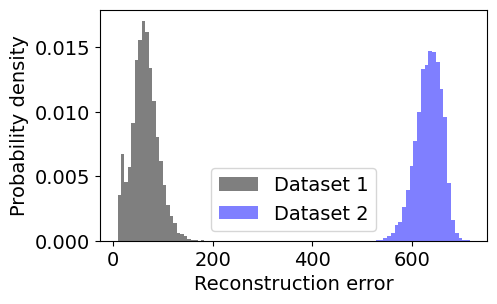

313/313 [==============================] - 4s 14ms/step


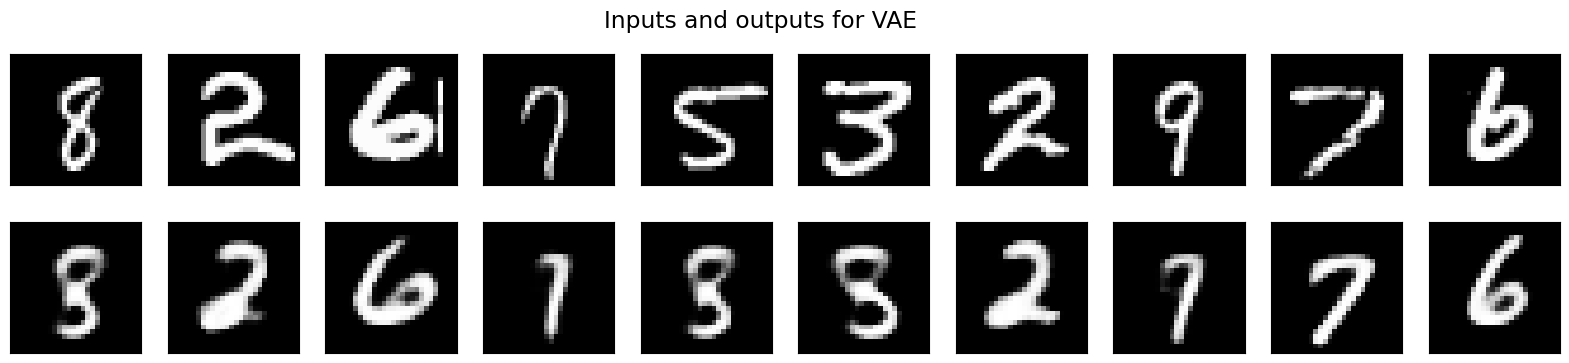

<Figure size 500x300 with 0 Axes>

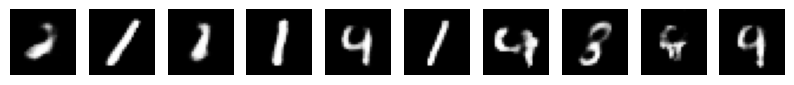

Show training samples:


<Figure size 500x300 with 0 Axes>

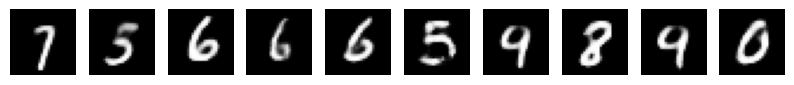

313/313 [==============================] - 4s 14ms/step


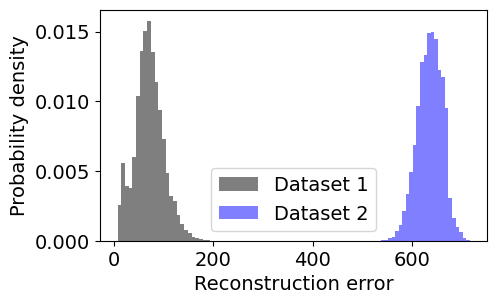

313/313 [==============================] - 6s 19ms/step


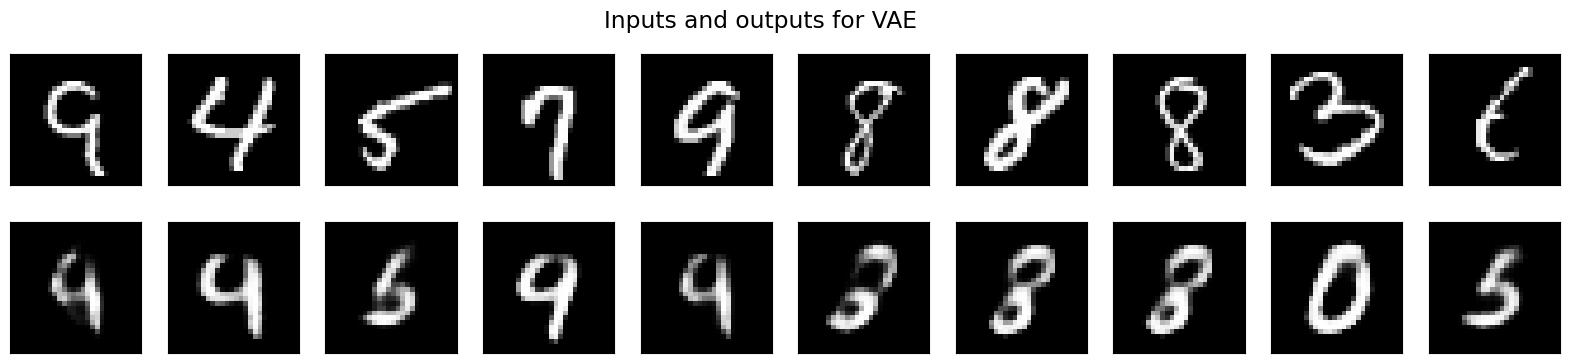

313/313 [==============================] - 4s 14ms/step


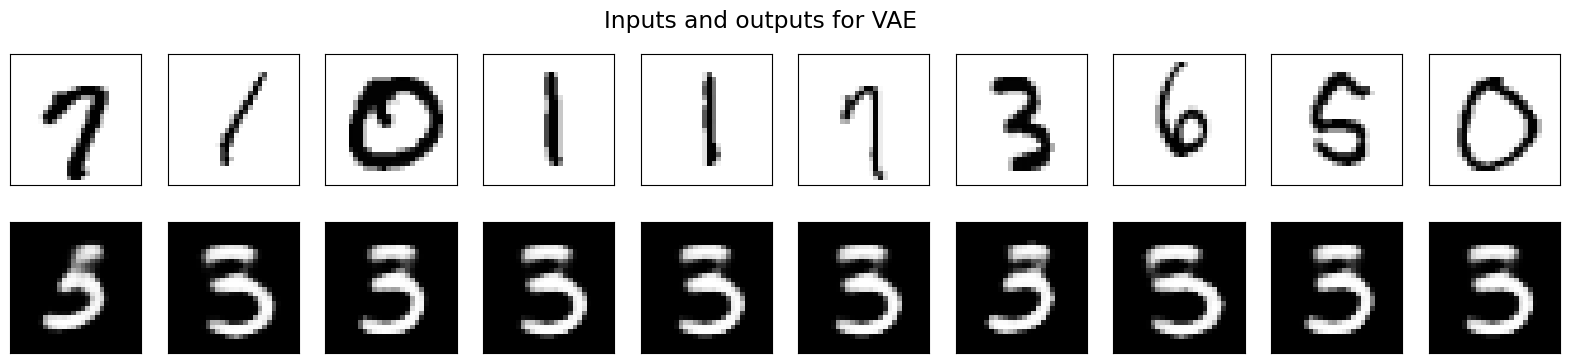

([63.9686407084465, 71.32725539598465], [633.9462630371094, 636.2517880065918])

In [ ]:
shuffled_baselines_with_ratio(baseline_type='both', ratio_old=1, ratio_new=0, inverted=True)

Starting with saved weights:
313/313 [==============================] - 4s 14ms/step


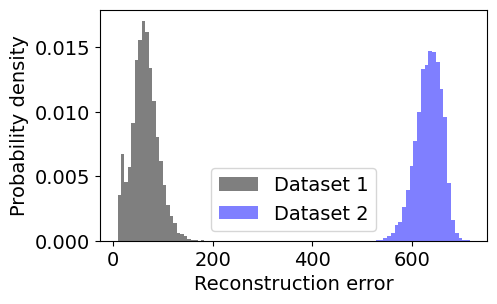

313/313 [==============================] - 6s 18ms/step


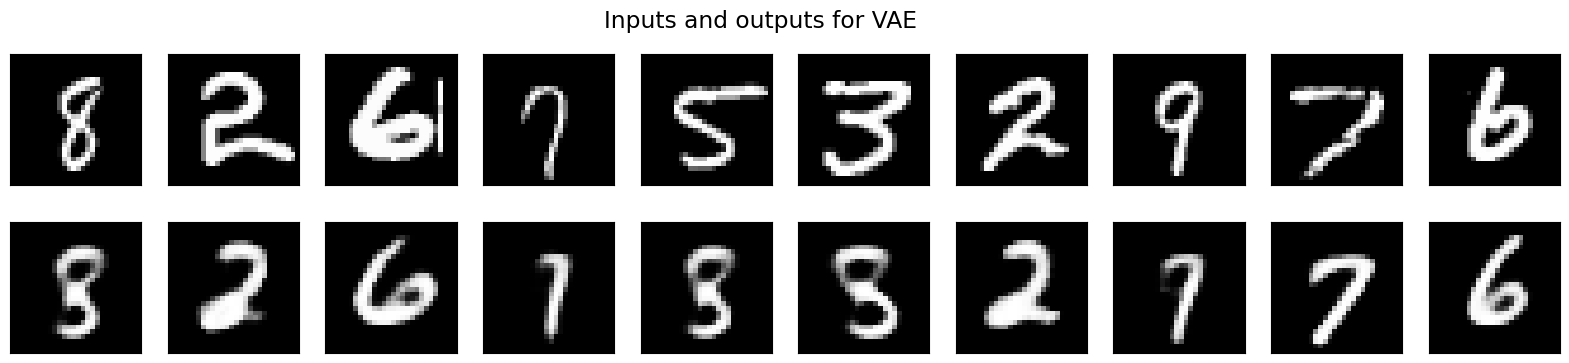

<Figure size 500x300 with 0 Axes>

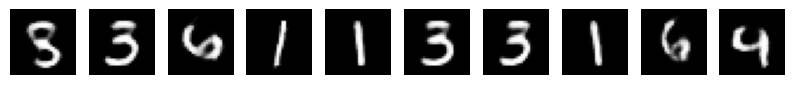

Show training samples:


<Figure size 500x300 with 0 Axes>

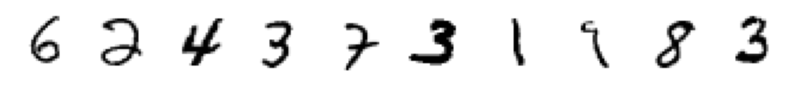

313/313 [==============================] - 5s 14ms/step


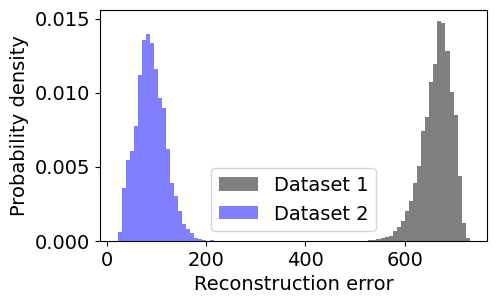

313/313 [==============================] - 6s 20ms/step


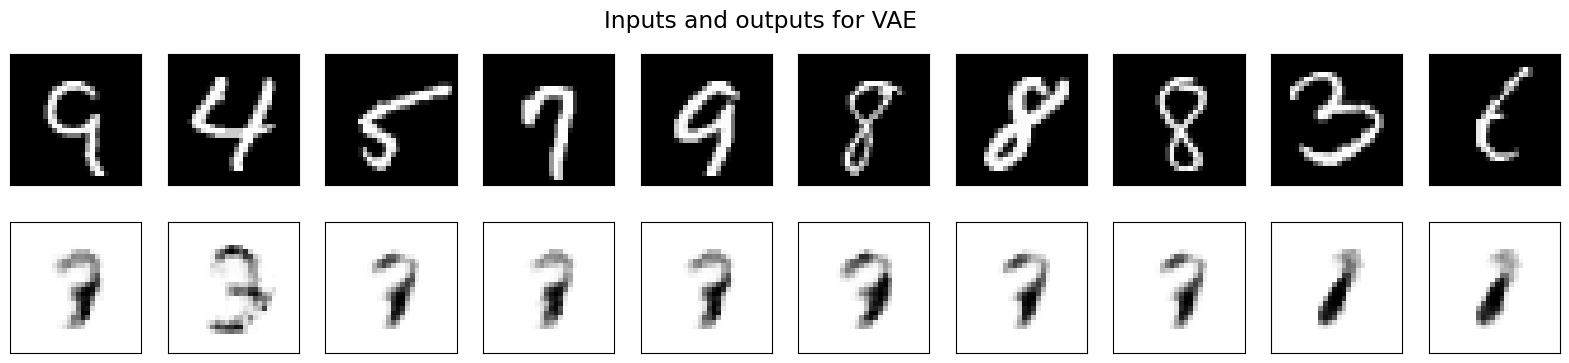

313/313 [==============================] - 5s 15ms/step


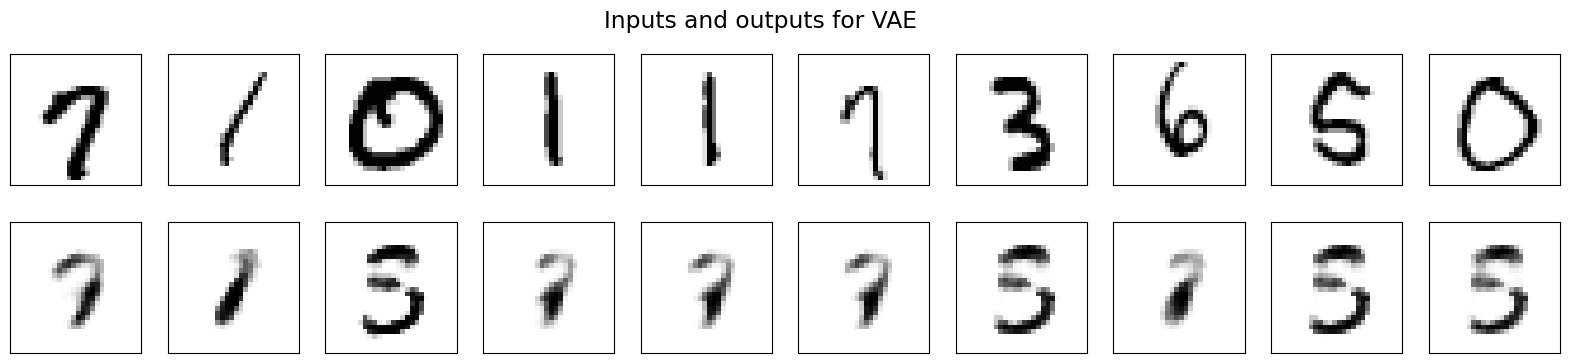

([63.9686407084465, 664.110901550293], [633.9462630371094, 88.30019550304412])

In [ ]:
shuffled_baselines_with_ratio(baseline_type='both', ratio_old=0, ratio_new=1, inverted=True)

Starting with saved weights:
313/313 [==============================] - 6s 21ms/step


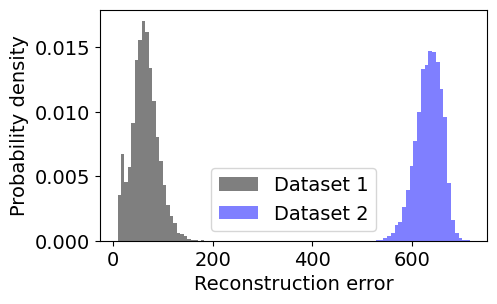

313/313 [==============================] - 6s 20ms/step


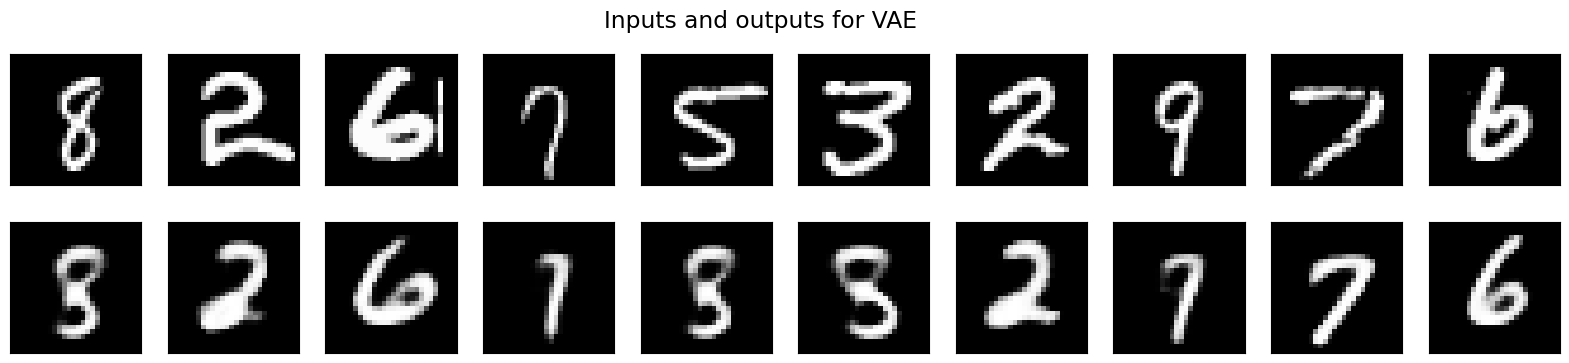

<Figure size 500x300 with 0 Axes>

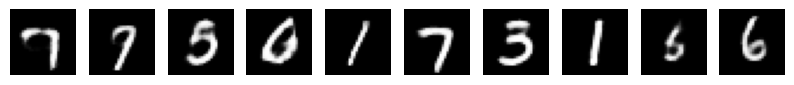

Show training samples:


<Figure size 500x300 with 0 Axes>

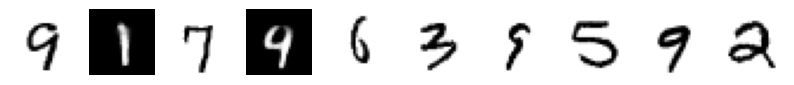

313/313 [==============================] - 5s 15ms/step


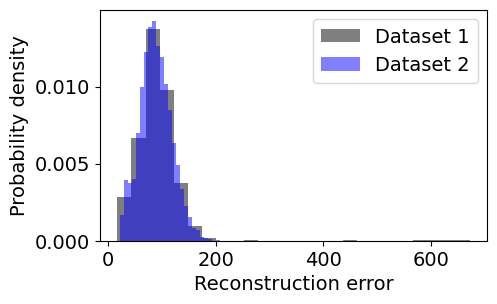

313/313 [==============================] - 6s 18ms/step


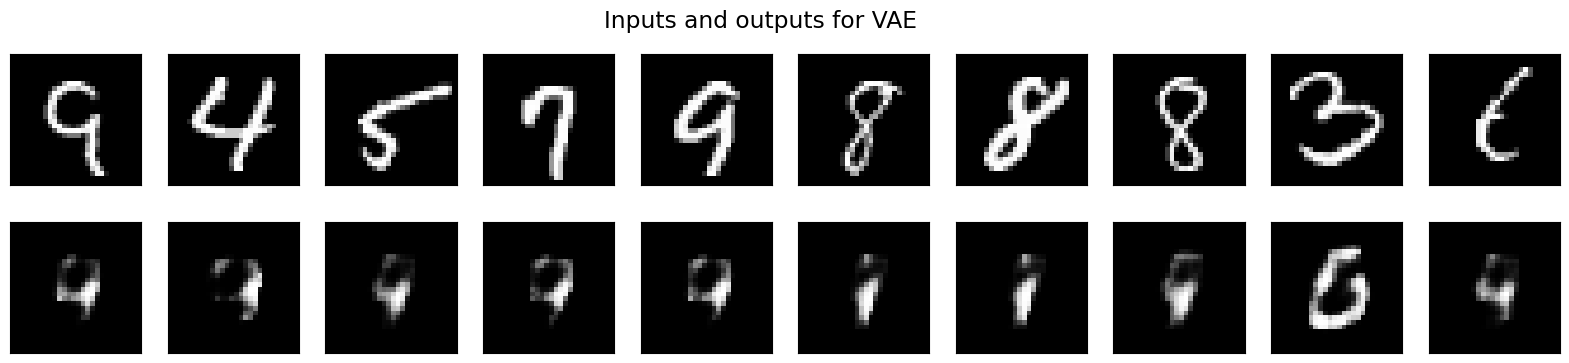

313/313 [==============================] - 6s 18ms/step


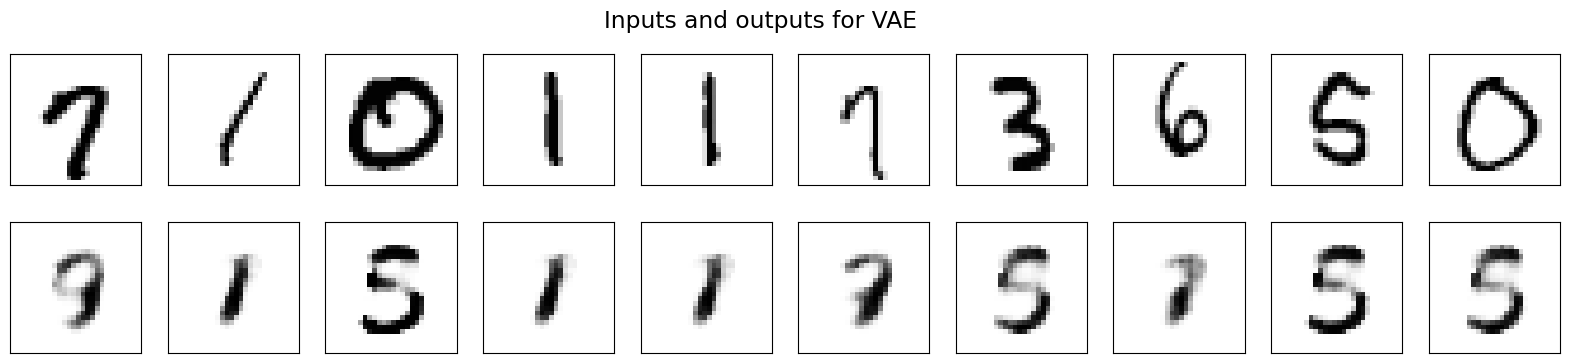

([63.9686407084465, 91.98914303588867], [633.9462630371094, 88.33255334529876])

In [ ]:
shuffled_baselines_with_ratio(baseline_type='both', ratio_old=0.1, ratio_new=0.9, inverted=True)

Starting with saved weights:
313/313 [==============================] - 6s 19ms/step


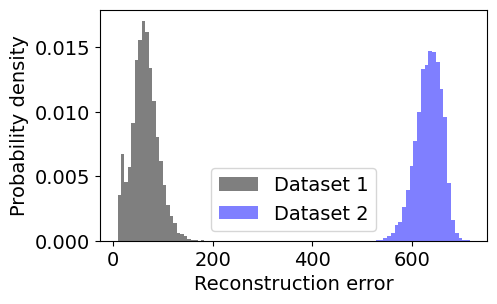

313/313 [==============================] - 6s 20ms/step


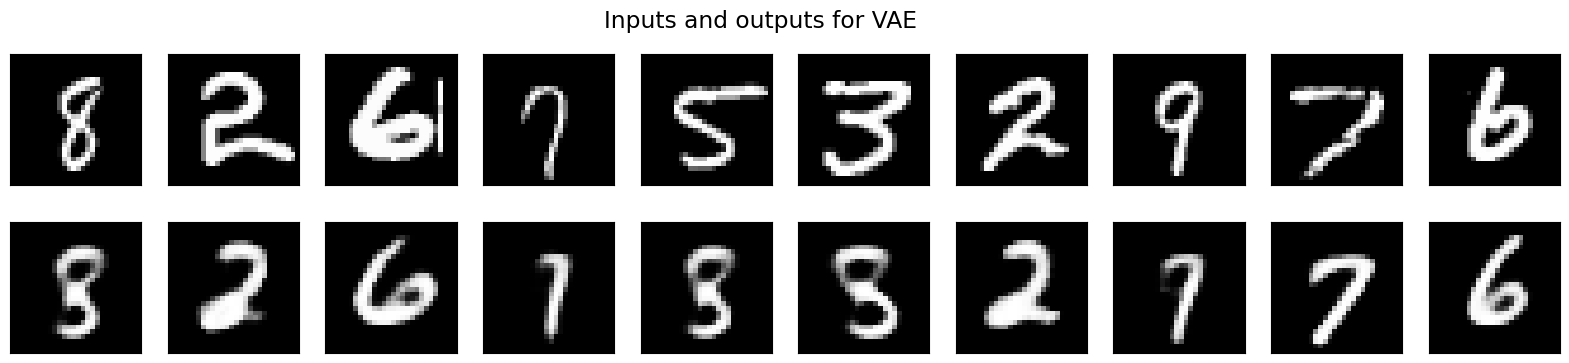

<Figure size 500x300 with 0 Axes>

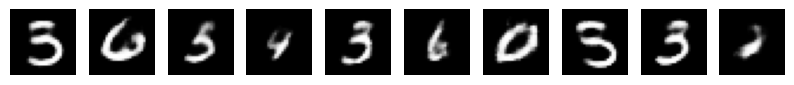

Show training samples:


<Figure size 500x300 with 0 Axes>

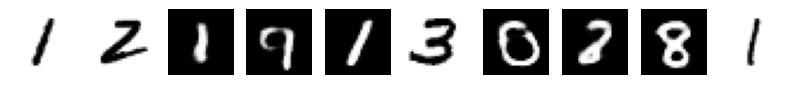

313/313 [==============================] - 6s 19ms/step


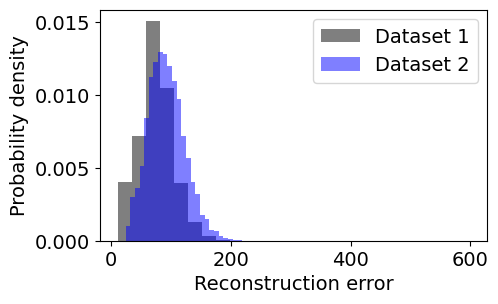

313/313 [==============================] - 6s 18ms/step


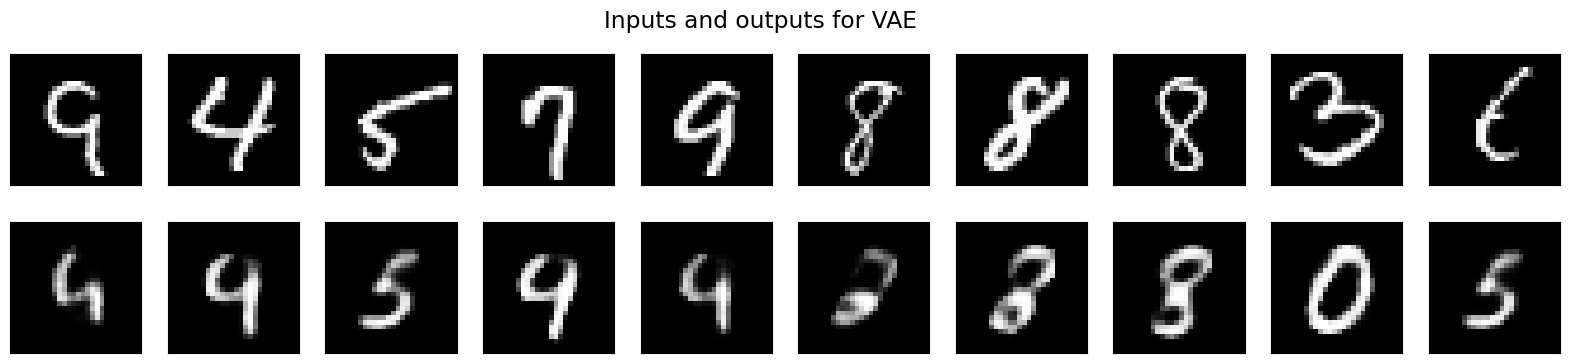

313/313 [==============================] - 6s 20ms/step


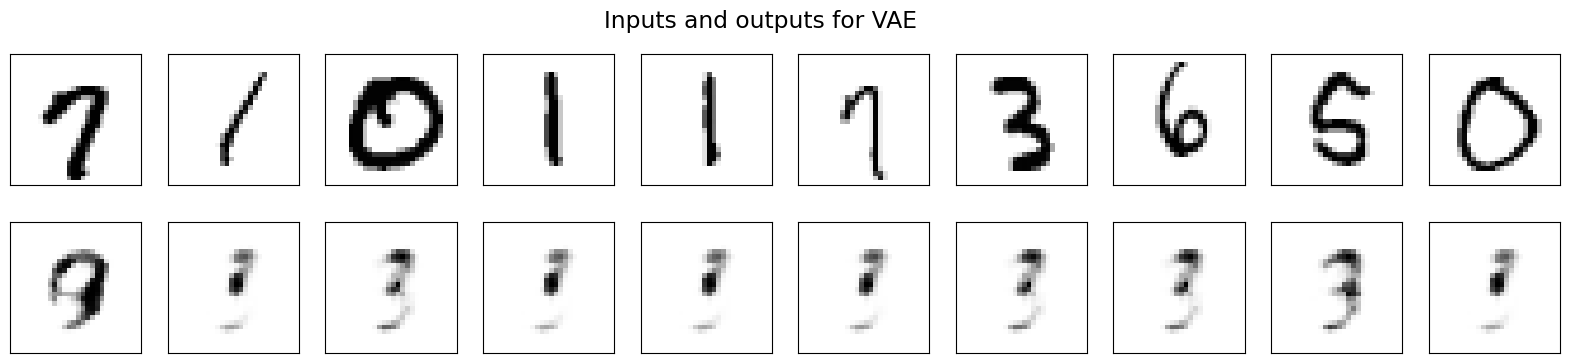

([63.9686407084465, 74.83840178499221], [633.9462630371094, 92.69344875125886])

In [ ]:
shuffled_baselines_with_ratio(baseline_type='both', ratio_old=0.5, ratio_new=0.5, inverted=True)

Starting with saved weights:
313/313 [==============================] - 5s 14ms/step


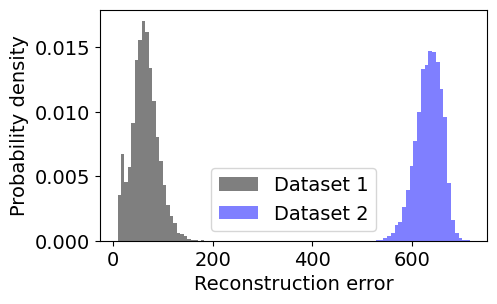

313/313 [==============================] - 6s 18ms/step


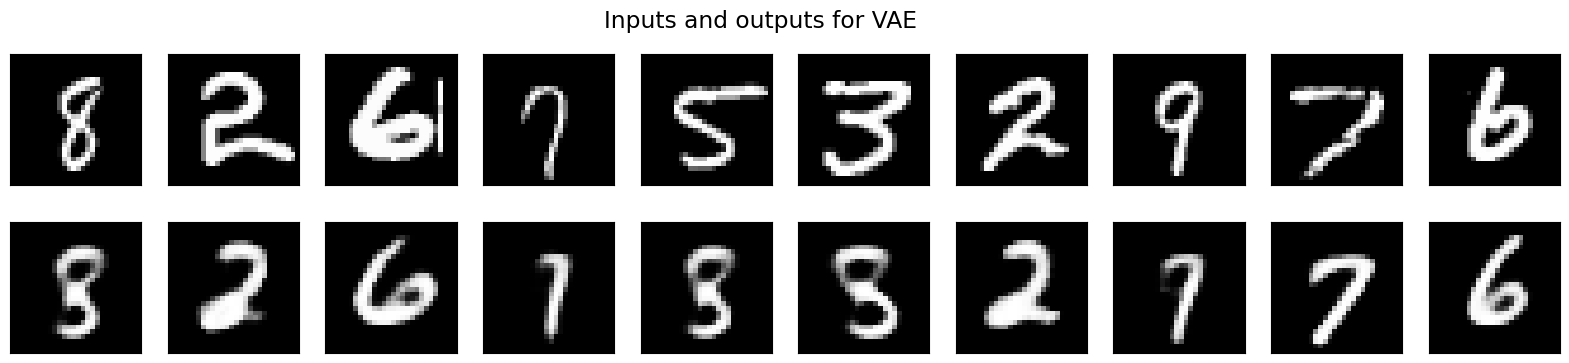

<Figure size 500x300 with 0 Axes>

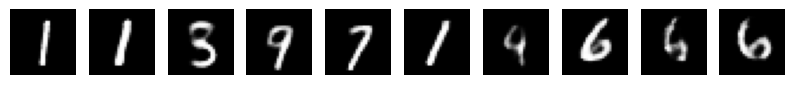

Show training samples:


<Figure size 500x300 with 0 Axes>

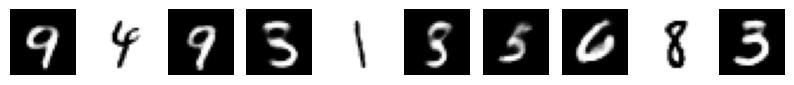

313/313 [==============================] - 4s 14ms/step


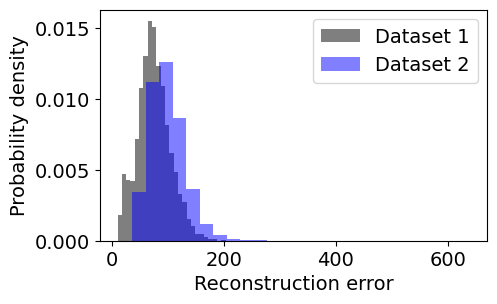

313/313 [==============================] - 6s 19ms/step


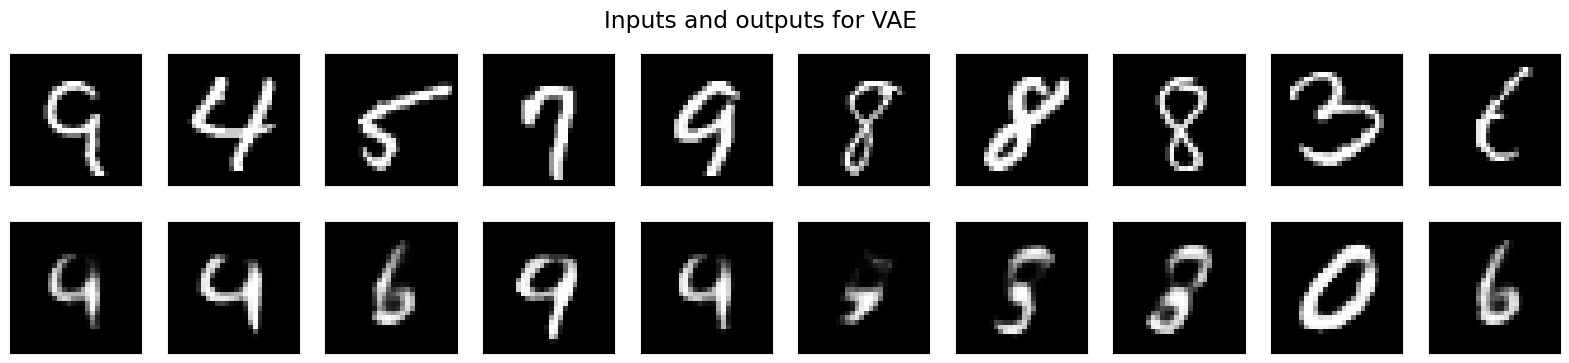

313/313 [==============================] - 4s 14ms/step


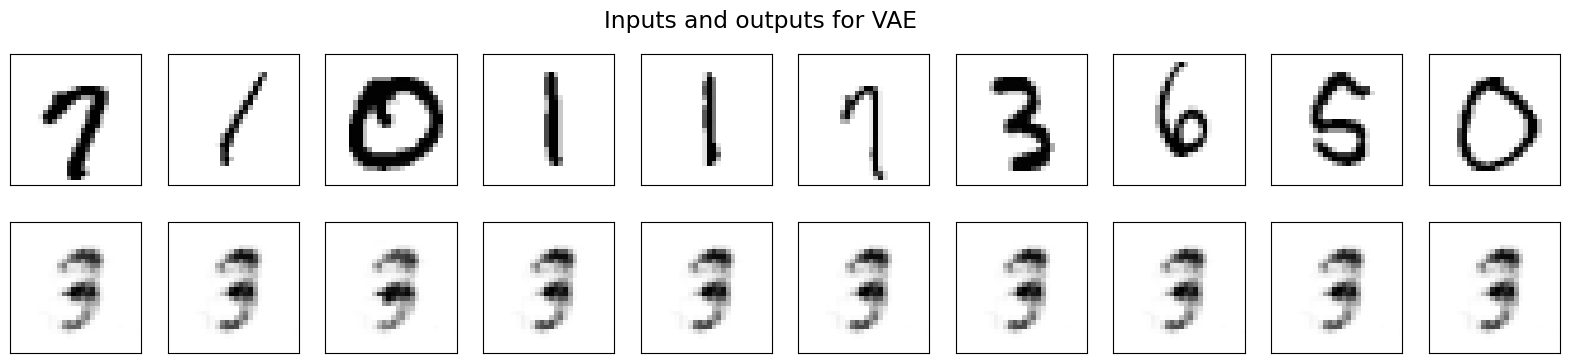

([63.9686407084465, 74.77513670864106], [633.9462630371094, 99.60084713783264])

In [ ]:
shuffled_baselines_with_ratio(baseline_type='both', ratio_old=0.7, ratio_new=0.3, inverted=True)

Starting with saved weights:
313/313 [==============================] - 6s 18ms/step


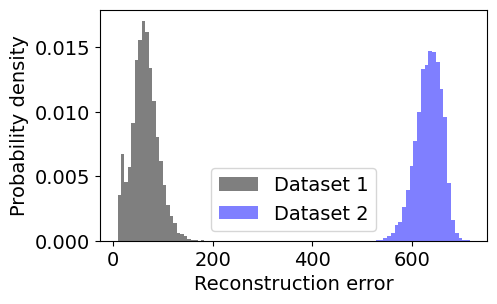

313/313 [==============================] - 5s 16ms/step


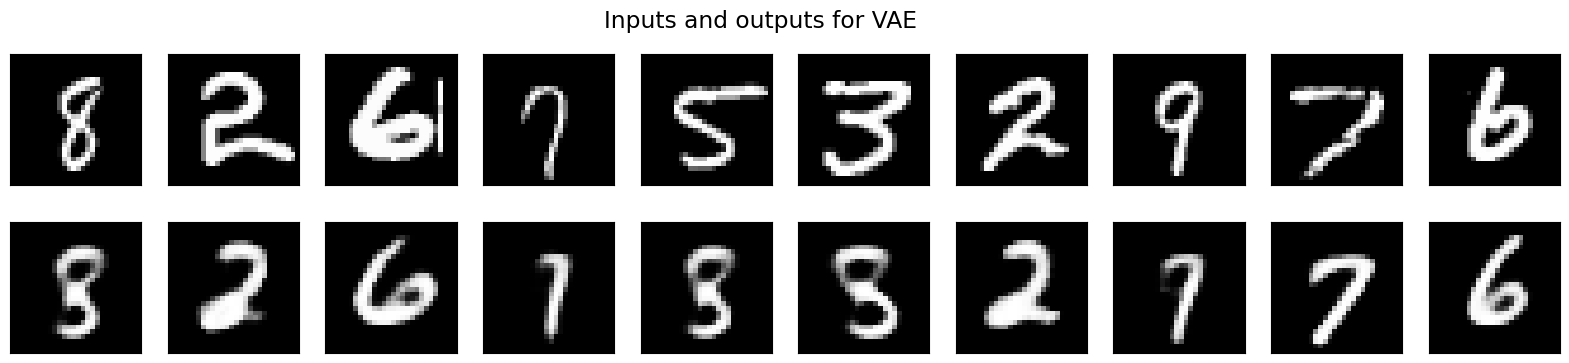

<Figure size 500x300 with 0 Axes>

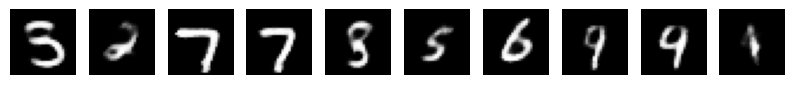

Show training samples:


<Figure size 500x300 with 0 Axes>

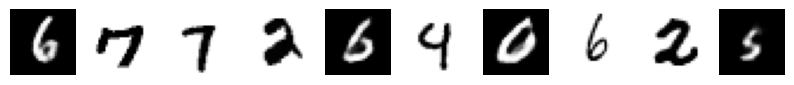

313/313 [==============================] - 5s 15ms/step


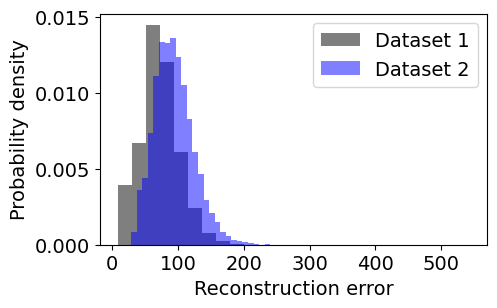

313/313 [==============================] - 6s 18ms/step


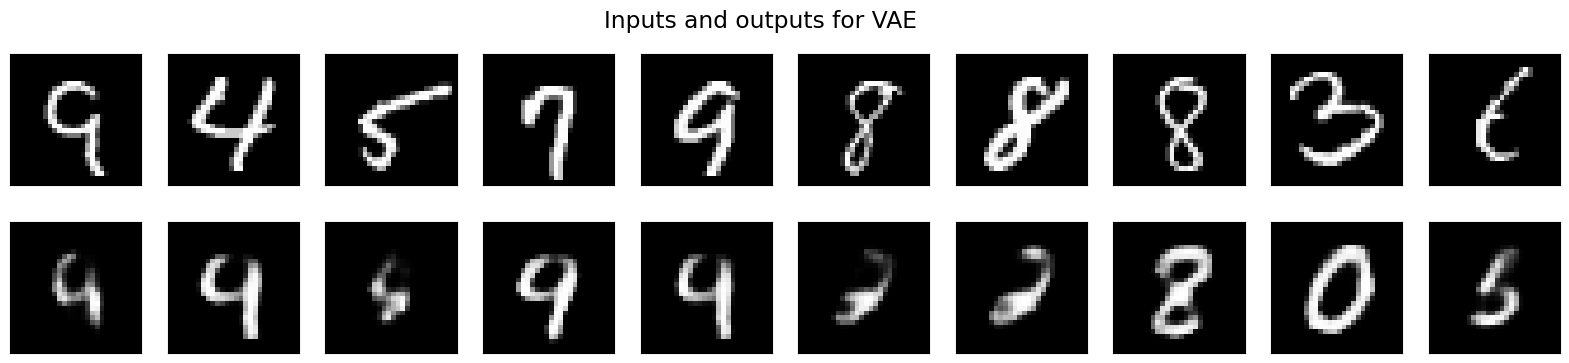

313/313 [==============================] - 6s 19ms/step


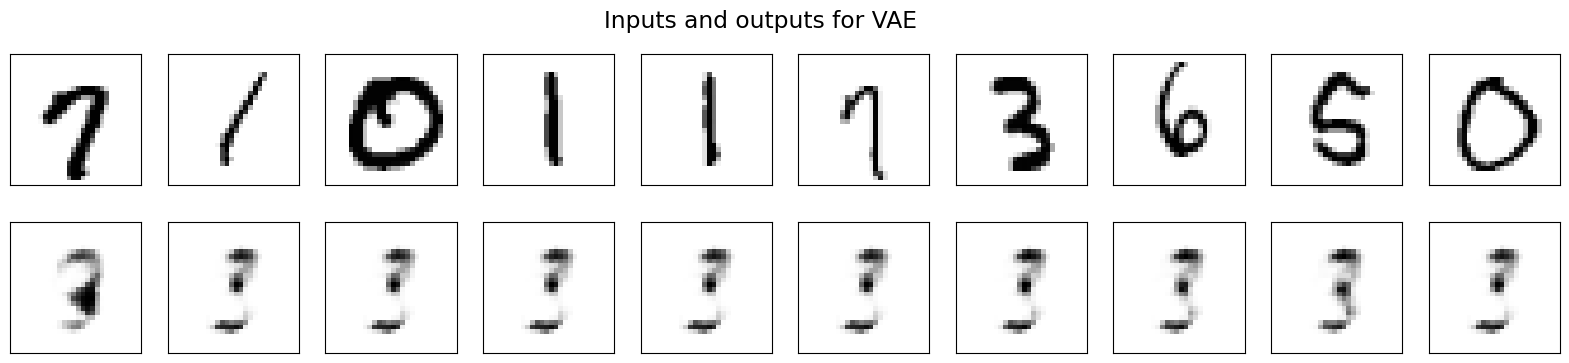

([63.9686407084465, 72.00633389530182], [633.9462630371094, 94.17305141944885])

In [ ]:
shuffled_baselines_with_ratio(baseline_type='both', ratio_old=0.6, ratio_new=0.4, inverted=True)

Starting with saved weights:
313/313 [==============================] - 8s 27ms/step


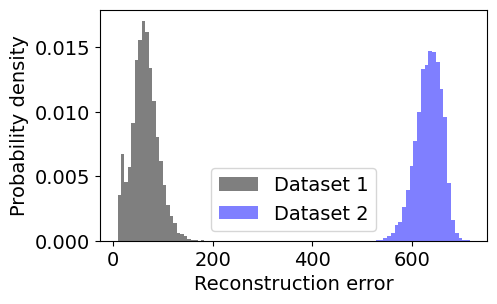

313/313 [==============================] - 6s 18ms/step


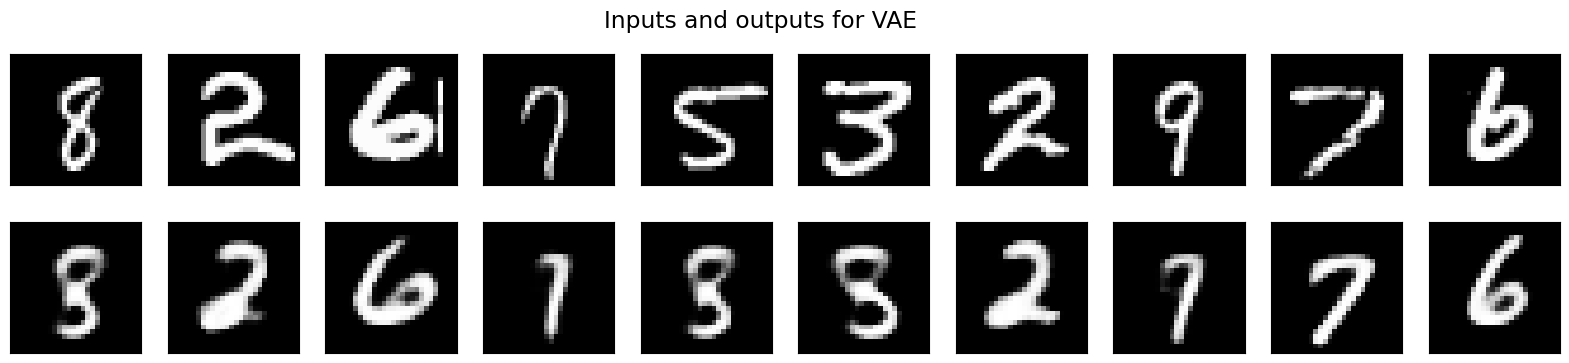

<Figure size 500x300 with 0 Axes>

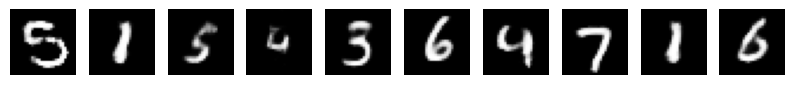

Show training samples:


<Figure size 500x300 with 0 Axes>

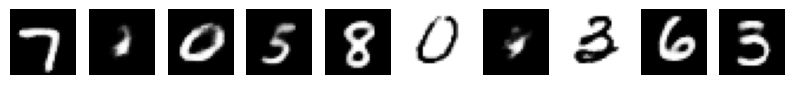

313/313 [==============================] - 7s 22ms/step


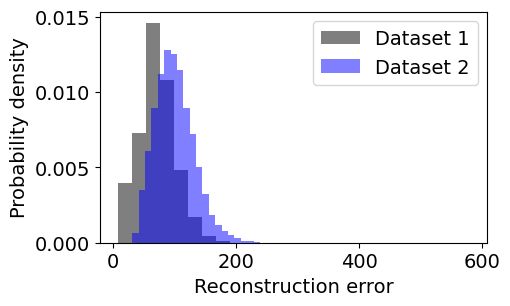

313/313 [==============================] - 5s 17ms/step


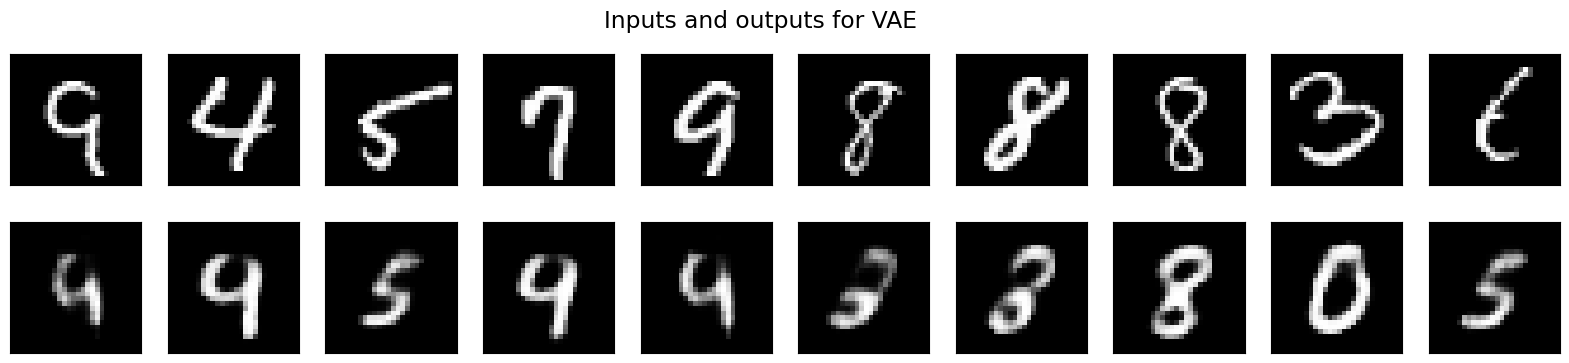

313/313 [==============================] - 6s 19ms/step


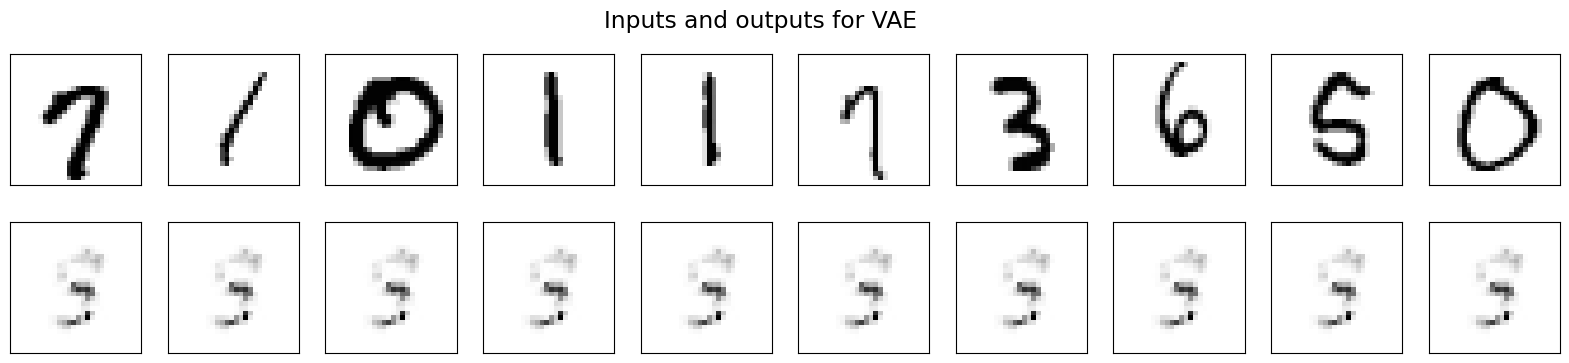

([63.9686407084465, 72.07018514318466],
 [633.9462630371094, 101.08348823623658])

In [ ]:
shuffled_baselines_with_ratio(baseline_type='both', ratio_old=0.9, ratio_new=0.1, inverted=True)

Starting with saved weights:
313/313 [==============================] - 6s 18ms/step


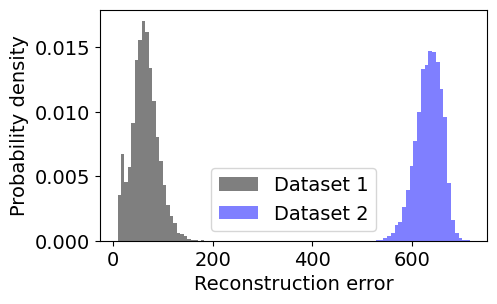

313/313 [==============================] - 7s 21ms/step


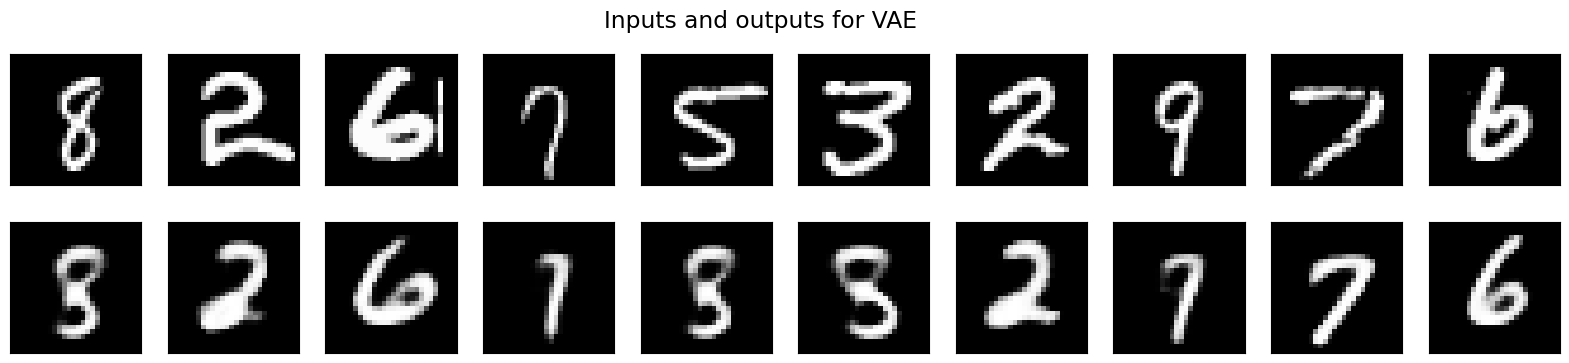

<Figure size 500x300 with 0 Axes>

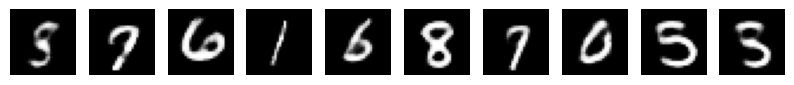

Show training samples:


<Figure size 500x300 with 0 Axes>

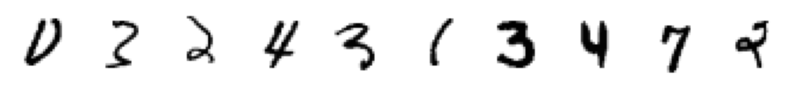

313/313 [==============================] - 6s 19ms/step


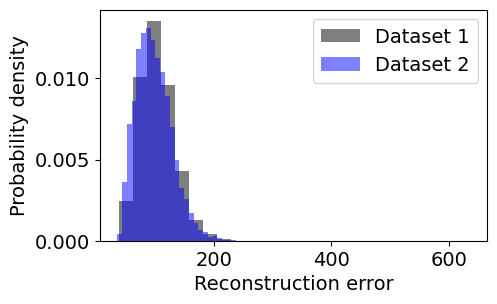

313/313 [==============================] - 6s 19ms/step


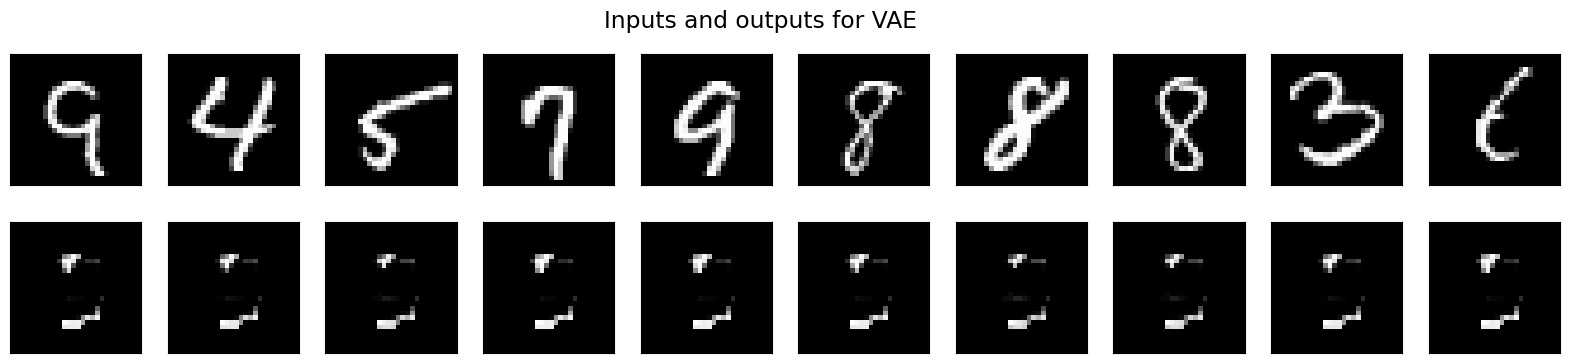

313/313 [==============================] - 7s 23ms/step


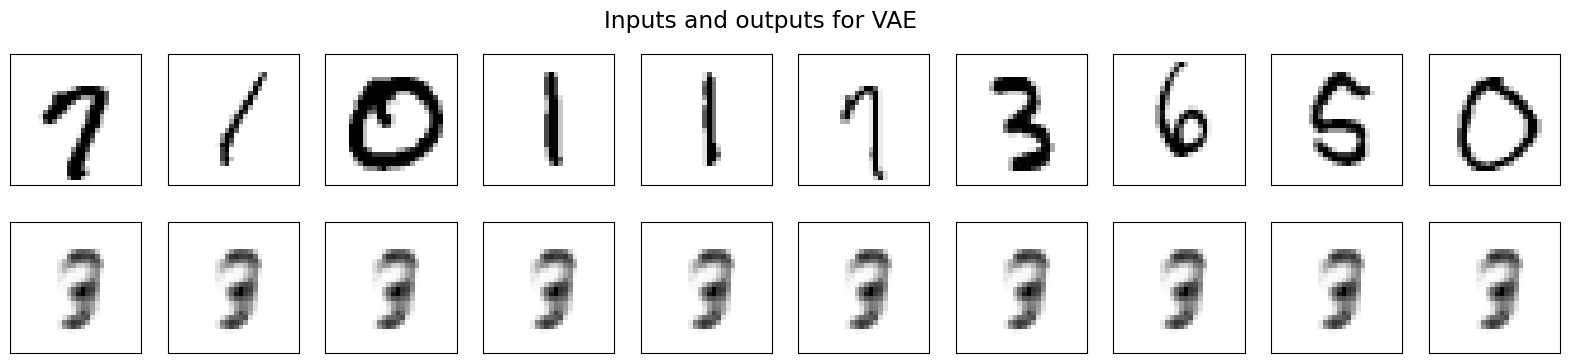

([63.9686407084465, 103.86944081993103],
 [633.9462630371094, 98.60483538665771])

In [ ]:
shuffled_baselines_with_ratio(baseline_type='both', ratio_old=0.01, ratio_new=0.99, inverted=True)

Starting with saved weights:
313/313 [==============================] - 5s 17ms/step


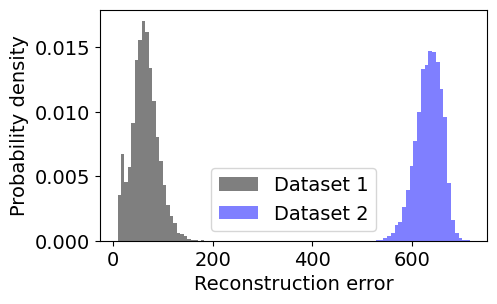

313/313 [==============================] - 5s 17ms/step


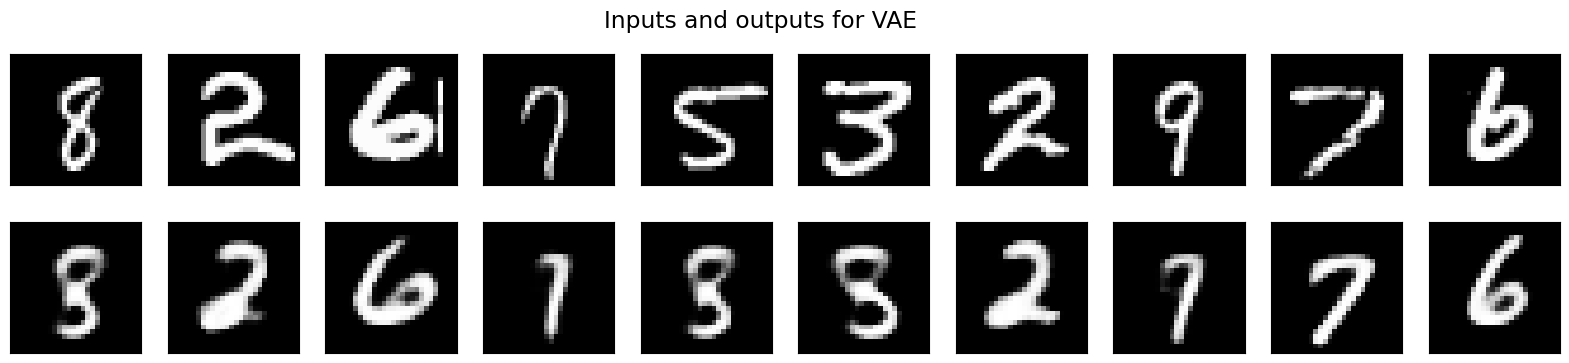

<Figure size 500x300 with 0 Axes>

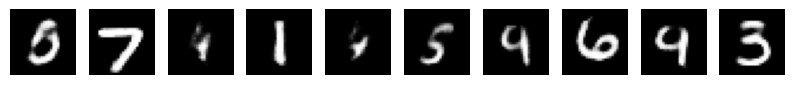

Show training samples:


<Figure size 500x300 with 0 Axes>

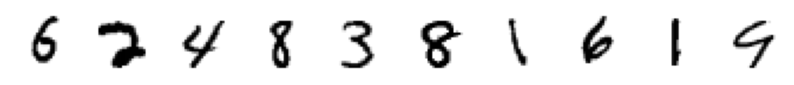

313/313 [==============================] - 5s 17ms/step


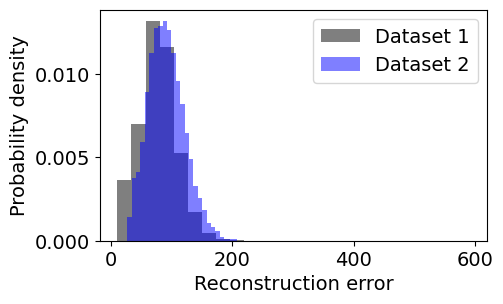

313/313 [==============================] - 6s 18ms/step


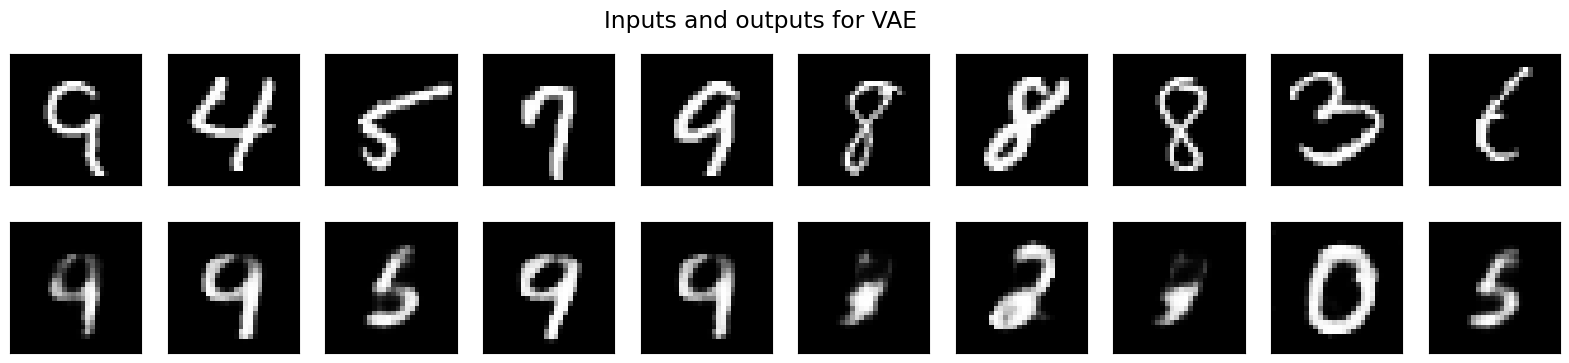

313/313 [==============================] - 5s 17ms/step


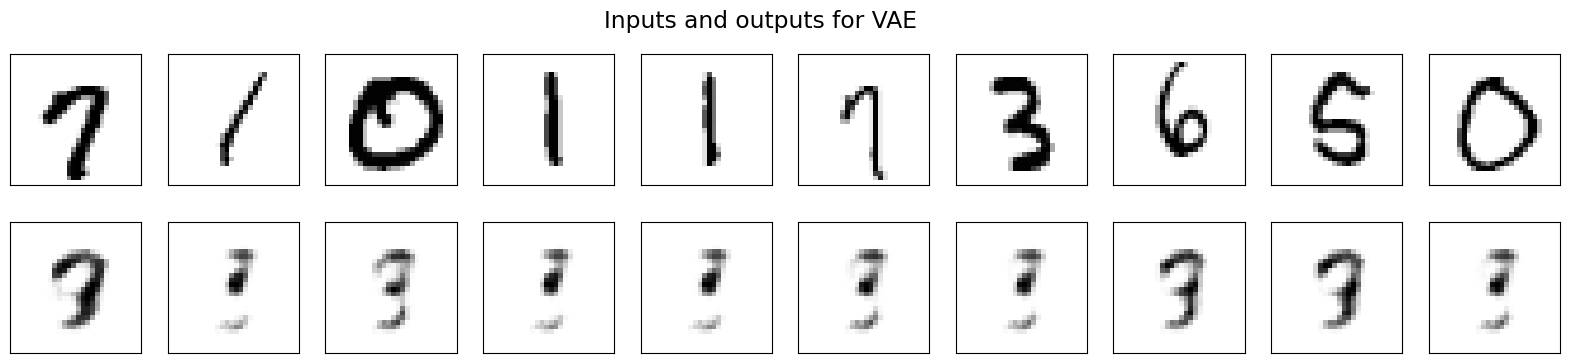

([63.9686407084465, 78.07595744667053], [633.9462630371094, 91.86131897888184])

In [ ]:
shuffled_baselines_with_ratio(baseline_type='both', ratio_old=0.29, ratio_new=0.71, inverted=True)
# this could be similar to sleeping 7 hours a day? (7/24=0.29)

In [ ]:
shuffled_baselines_with_ratio(baseline_type='old', ratio_old=0.6, ratio_new=0.4, inverted=True)

ValueError: baseline type can only be both

In [ ]:
shuffled_baselines_with_ratio(baseline_type='both', ratio_old=2, ratio_new=0, inverted=True)

ValueError: incorrect ratio

In [ ]:
float(0.5)

0.5

In [ ]:
print(1000*0.7)

700.0


In [ ]:
print((1000*0.7).astype(int))

AttributeError: 'float' object has no attribute 'astype'

Starting with saved weights:
313/313 [==============================] - 4s 14ms/step


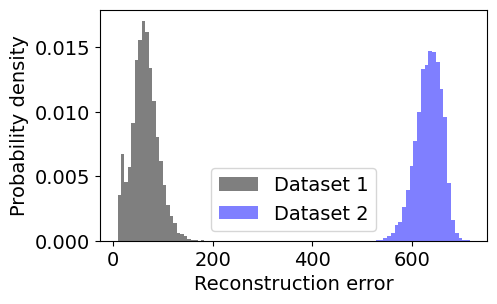

313/313 [==============================] - 4s 14ms/step


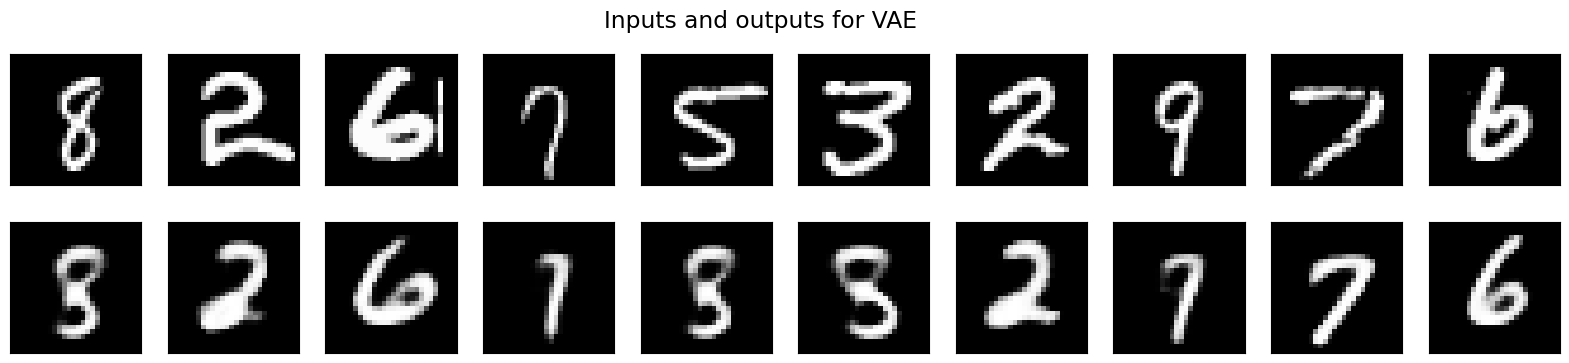

<Figure size 500x300 with 0 Axes>

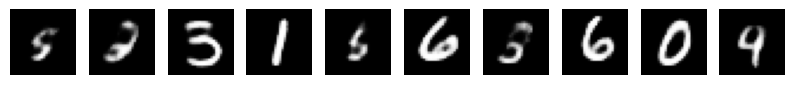

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<Figure size 500x300 with 0 Axes>

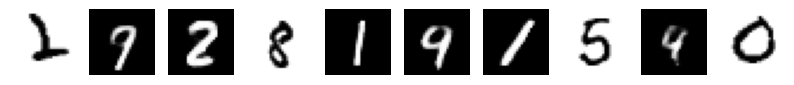

313/313 [==============================] - 4s 14ms/step


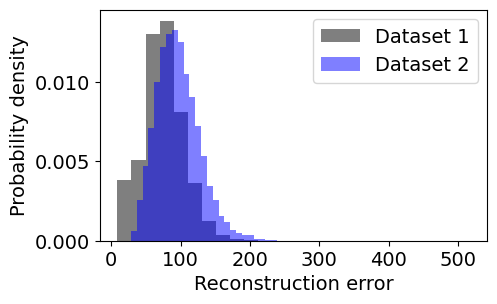

313/313 [==============================] - 4s 14ms/step


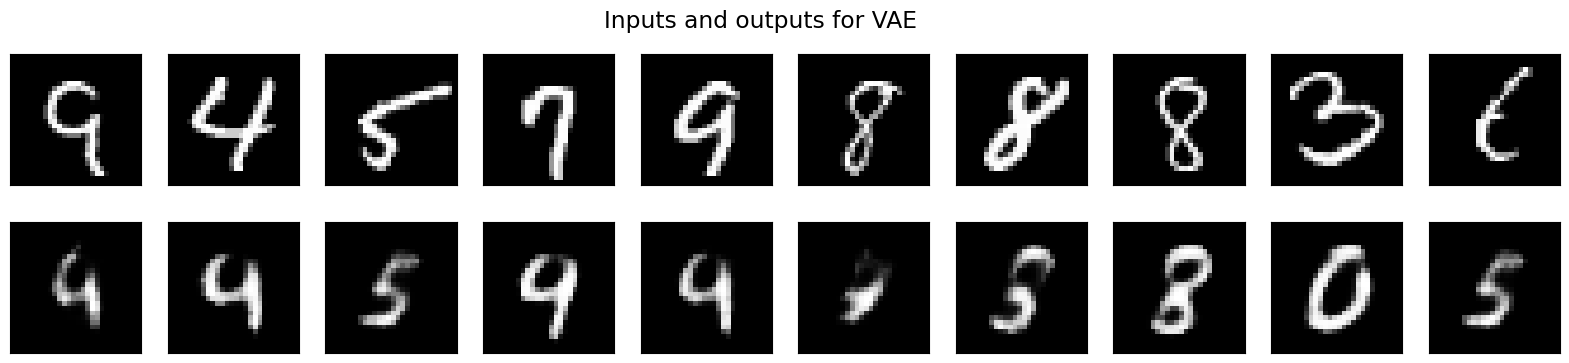

313/313 [==============================] - 6s 17ms/step


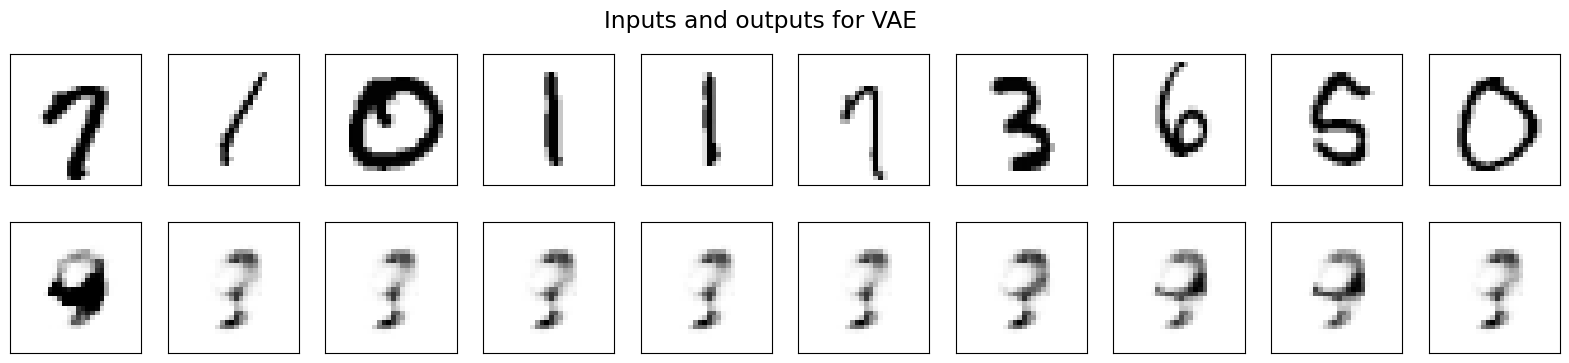

([63.9686407084465, 74.57155064620972], [633.9462630371094, 96.18660876464844])

In [ ]:
shuffled_baselines_with_ratio(baseline_type='both',inverted=True)

#### Try different schedules

For example, here we vary just the number of cycles (for a fixed total number of epochs of training).

In [ ]:
rem_fraction_pairs = [(0.5,0.5), (0,0), (1,1)]
cycles_values = [50,20,10,5]
lrs = [0.001]

seeds = range(0, 3)

for lr in lrs:
    for num_cycles in cycles_values:
        for (start_fraction_rem, end_fraction_rem) in rem_fraction_pairs:
            train_with_schedule_multiple_seeds(seeds,
                                               total_eps=50,
                                               num_cycles=25,
                                               start_fraction_rem=start_fraction_rem,
                                               end_fraction_rem=end_fraction_rem,
                                               inverted=True,
                                               lr=lr,
                                               num=5,
                                               continue_training=True)
